## Importing Libraries

In [2]:
#Importing all libraries
import pandas as pd

#Plotters
import seaborn as sns
import matplotlib.pyplot as plt

#Statistical
from scipy.stats import norm, shapiro, zscore, skew
from scipy import stats 
import numpy as np

#Encoders
from sklearn.preprocessing import LabelEncoder

#Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Reducers
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix

# Warning ignore
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [3]:
# Converting our xlsx dataset document to csv

excel_file = "biking_dataset.xlsx" 
df = pd.read_excel(excel_file)

csv_file = "biking_dataset.csv"
df.to_csv(csv_file, index=False) 

## Exploratory Data Analysis

1 - Checking the size of dataset

2 - Check the statistical distribution of numerical variables within the dataset

3 - Checking missing values

4 - Checking data types of each column

5 - Checking unique values on each column

In [5]:
# Checking the size of the dataset
df.shape

(900, 8)

In [6]:
df.head()

City Weather Condition  Rider Age Bike Model  Ride Duration (min)  \
0         Berlin             Rainy       53.0   Standard                 62.0   
1  San Francisco            Cloudy       39.0   Standard                  5.0   
2         Berlin             Sunny       43.0   Electric                106.0   
3  San Francisco            Cloudy       24.0   Standard                119.0   
4       New York             Sunny       24.0   Mountain                 11.0   

   Distance Covered (km) Rider Satisfaction  Bike Rental Cost ($)  
0                   2.25               High                 22.63  
1                  21.67             Medium                  7.87  
2                  28.40               High                 39.40  
3                   5.66                Low                 37.63  
4                  25.74                Low                 13.12

In [7]:
# Checking the meanstandard deviation and quartiles of numerical columns
df.describe()

Rider Age  Ride Duration (min)  Distance Covered (km)  \
count  885.000000           887.000000             887.000000   
mean    39.264407            62.225479              20.130530   
std     12.373803            33.956434              11.178777   
min     18.000000             5.000000               0.510000   
25%     29.000000            32.000000              10.830000   
50%     39.000000            62.000000              19.990000   
75%     50.000000            92.000000              29.155000   
max     60.000000           120.000000              39.870000   

       Bike Rental Cost ($)  
count            891.000000  
mean              26.581470  
std                9.438224  
min                7.330000  
25%               19.210000  
50%               27.040000  
75%               33.955000  
max               48.380000

The data does not seem to be too skewed

In [9]:
#Checking if the dataset contains missing values
df.isnull().sum()

City                     10
Weather Condition        11
Rider Age                15
Bike Model               10
Ride Duration (min)      13
Distance Covered (km)    13
Rider Satisfaction       11
Bike Rental Cost ($)      9
dtype: int64

In [10]:
# Checking the typoe of the data within the dataset
df.dtypes

City                      object
Weather Condition         object
Rider Age                float64
Bike Model                object
Ride Duration (min)      float64
Distance Covered (km)    float64
Rider Satisfaction        object
Bike Rental Cost ($)     float64
dtype: object

In [11]:
# Checking the unique values
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique valeus in '{column}': {unique_values}")

Unique valeus in 'City': ['Berlin' 'San Francisco' 'New York' 'London' 'Chicago' 'Dublin' nan]
Unique valeus in 'Weather Condition': ['Rainy' 'Cloudy' 'Sunny' 'Snowy' nan]
Unique valeus in 'Rider Age': [53. 39. 43. 24. 25. 41. 57. 26. 20. 38. 48. 21. 37. 33. 27. 60. 22. 28.
 46. 32. 23. 51. 19. 36. 31. 49. 54. 40. 44. 59. 45. 34. 56. 35. 30. 18.
 47. nan 55. 42. 52. 50. 58. 29.]
Unique valeus in 'Bike Model': ['Standard' 'Electric' 'Mountain' nan 'Manual']
Unique valeus in 'Ride Duration (min)': [ 62.   5. 106. 119.  11.  92.  73.  89.  96.  22.  36.  49.  37.  78.
  77.  53. 101.  75.  72.  32.  91. 100.  48.  84. 114.  59.  14. 107.
  40.  38.  20. 109.  41.  29.  12.  88. 116.  98.  52. 104.  74.  71.
 108.  60.  27.  10.  30.  19.  16.   9.  90.  31.  83.  39.  17.  94.
   7.  33.  nan  68. 117.  15.  42.  85.  50. 102.  58.  97.  81.  79.
  99.  56. 110.  76.  18. 115.   6.  65. 112.  21.  82.  93.  95.  45.
  46.  80.  57. 113.  35.  66.  34.  70. 103.  23.  54.  43.  67.  63.
  

# Data Preparation Part I

## Imputation of Missing Values

1 - filling up missing values in some cases with mean, or getting directly relation to other observations

2 - Confirming there is no missing values in the dataset

3 - Modifying column names for better readability and management

4 - Checking duplicate data

5 - Replace observation "Manual" to "Standard" on Bike Model

In [14]:
import itertools
import pandas as pd

def fill_missing_values(df, target_column, reference_columns):
    """
    Fills missing values in a target column based on reference columns.
    Uses median for numerical columns and mode for categorical columns.

    Args:
    df (pd.DataFrame): The DataFrame with missing values.
    target_column (str): The column to fill missing values for.
    reference_columns (list): List of reference columns to determine matching patterns.

    Returns:
    pd.DataFrame: DataFrame with filled values.
    """
    # Check if the target column is numeric
    is_numeric = pd.api.types.is_numeric_dtype(df[target_column])

    def fill_row(row):
        # If the value already exists, return it without changes
        if pd.notnull(row[target_column]):
            return row[target_column]
        
        # Find rows with exact matches based on all reference columns
        similar_rows = df
        for col in reference_columns:
            similar_rows = similar_rows[similar_rows[col] == row[col]]
        
        # If exact matches exist, use median (for numeric) or mode (for categorical)
        if not similar_rows.empty:
            if is_numeric and not similar_rows[target_column].isnull().all():
                return similar_rows[target_column].median()  # Use median for numerical columns
            elif not is_numeric and not similar_rows[target_column].mode().empty:
                return similar_rows[target_column].mode().iloc[0]  # Use mode for categorical columns
        
        # If no exact matches, relax criteria: use subsets of reference columns
        for subset_size in range(len(reference_columns) - 1, 0, -1):  # Gradually reduce the number of reference columns
            for subset in itertools.combinations(reference_columns, subset_size):
                relaxed_rows = df
                for col in subset:
                    relaxed_rows = relaxed_rows[relaxed_rows[col] == row[col]]
                if not relaxed_rows.empty:
                    if is_numeric and not relaxed_rows[target_column].isnull().all():
                        return relaxed_rows[target_column].median()  # Use median here too
                    elif not is_numeric and not relaxed_rows[target_column].mode().empty:
                        return relaxed_rows[target_column].mode().iloc[0]
        
        # If no matches are found, keep the value as NaN
        return row[target_column]

    # Apply the fill_row function to each row of the DataFrame
    df[target_column] = df.apply(fill_row, axis=1)

    # Print the number of missing values remaining
    missing_after = df[target_column].isna().sum()
    print(f"Missing values remaining in '{target_column}': {missing_after}")
    return df


In [15]:
reference_columns = ["Weather Condition", "Bike Model","Distance Covered (km)"]
df = fill_missing_values(df, target_column="City", reference_columns=reference_columns)

Missing values remaining in 'City': 0


In [16]:
reference_columns = ["City", "Rider Satisfaction","Ride Duration (min)"]
df = fill_missing_values(df, target_column="Weather Condition", reference_columns=reference_columns)

Missing values remaining in 'Weather Condition': 0


In [17]:
reference_columns = ["City","Bike Model","Distance Covered (km)"]
df = fill_missing_values(df, target_column="Rider Age", reference_columns=reference_columns)

Missing values remaining in 'Rider Age': 0


In [18]:
reference_columns = ["City","Ride Duration (min)","Distance Covered (km)","Rider Satisfaction"]
df = fill_missing_values(df, target_column="Bike Model", reference_columns=reference_columns)

Missing values remaining in 'Bike Model': 0


In [19]:
reference_columns = ["Rider Age","Weather Condition","Distance Covered (km)","Bike Model"]
df = fill_missing_values(df, target_column="Ride Duration (min)", reference_columns=reference_columns)

Missing values remaining in 'Ride Duration (min)': 0


In [20]:
reference_columns = ["Rider Age","Weather Condition","Ride Duration (min)","Bike Model"]
df = fill_missing_values(df, target_column="Distance Covered (km)", reference_columns=reference_columns)

Missing values remaining in 'Distance Covered (km)': 0


In [21]:
reference_columns = ["Ride Duration (min)","Weather Condition","Distance Covered (km)","Bike Model"]
df = fill_missing_values(df, target_column="Rider Satisfaction", reference_columns=reference_columns)

Missing values remaining in 'Rider Satisfaction': 0


In [22]:
reference_columns = ["Ride Duration (min)","City","Distance Covered (km)","Bike Model"]
df = fill_missing_values(df, target_column="Bike Rental Cost ($)", reference_columns=reference_columns)

Missing values remaining in 'Bike Rental Cost ($)': 0


In [23]:
#Checking if teh dataset contains missing values one more time
df.isnull().sum()

City                     0
Weather Condition        0
Rider Age                0
Bike Model               0
Ride Duration (min)      0
Distance Covered (km)    0
Rider Satisfaction       0
Bike Rental Cost ($)     0
dtype: int64

In [24]:
#Modifying the name of columns
df = df.rename(columns={"Ride Duration (min)": "Duration", "Distance Covered (km)": "Distance", "Bike Rental Cost ($)": "Cost"})
print(df)

              City Weather Condition  Rider Age Bike Model  Duration  \
0           Berlin             Rainy       53.0   Standard      62.0   
1    San Francisco            Cloudy       39.0   Standard       5.0   
2           Berlin             Sunny       43.0   Electric     106.0   
3    San Francisco            Cloudy       24.0   Standard     119.0   
4         New York             Sunny       24.0   Mountain      11.0   
..             ...               ...        ...        ...       ...   
895       New York             Rainy       55.0   Electric      55.0   
896         London            Cloudy       47.0   Mountain      14.0   
897  San Francisco             Sunny       49.0   Mountain      23.0   
898        Chicago             Sunny       19.0   Mountain     110.0   
899         Dublin             Rainy       37.0   Standard      17.0   

     Distance Rider Satisfaction   Cost  
0        2.25               High  22.63  
1       21.67             Medium   7.87  
2       2

In [25]:
#Checking if the dataset contains duplicated observations
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate observation: {duplicate_count}")

Number of duplicate observation: 0


In [26]:
#Replacing Manual observation to Standard
df["Bike Model"] = df["Bike Model"].replace("Manual", "Standard")
df["Bike Model"].unique()

array(['Standard', 'Electric', 'Mountain'], dtype=object)

In [27]:
# Checking the results
df.head(10)

City Weather Condition  Rider Age Bike Model  Duration  Distance  \
0         Berlin             Rainy       53.0   Standard      62.0      2.25   
1  San Francisco            Cloudy       39.0   Standard       5.0     21.67   
2         Berlin             Sunny       43.0   Electric     106.0     28.40   
3  San Francisco            Cloudy       24.0   Standard     119.0      5.66   
4       New York             Sunny       24.0   Mountain      11.0     25.74   
5         Berlin             Rainy       25.0   Mountain      92.0     19.34   
6  San Francisco            Cloudy       43.0   Mountain      73.0     39.50   
7         London             Snowy       41.0   Standard      89.0     28.84   
8        Chicago             Rainy       41.0   Mountain      96.0     26.47   
9  San Francisco            Cloudy       57.0   Electric      22.0     23.03   

  Rider Satisfaction   Cost  
0               High  22.63  
1             Medium   7.87  
2               High  39.40  
3                Low  37.63  
4                Low  13.12  
5               High  30.61  
6                Low  31.23  
7               High  29.84  
8             Medium  36.27  
9               High  25.04

## Outliers Study

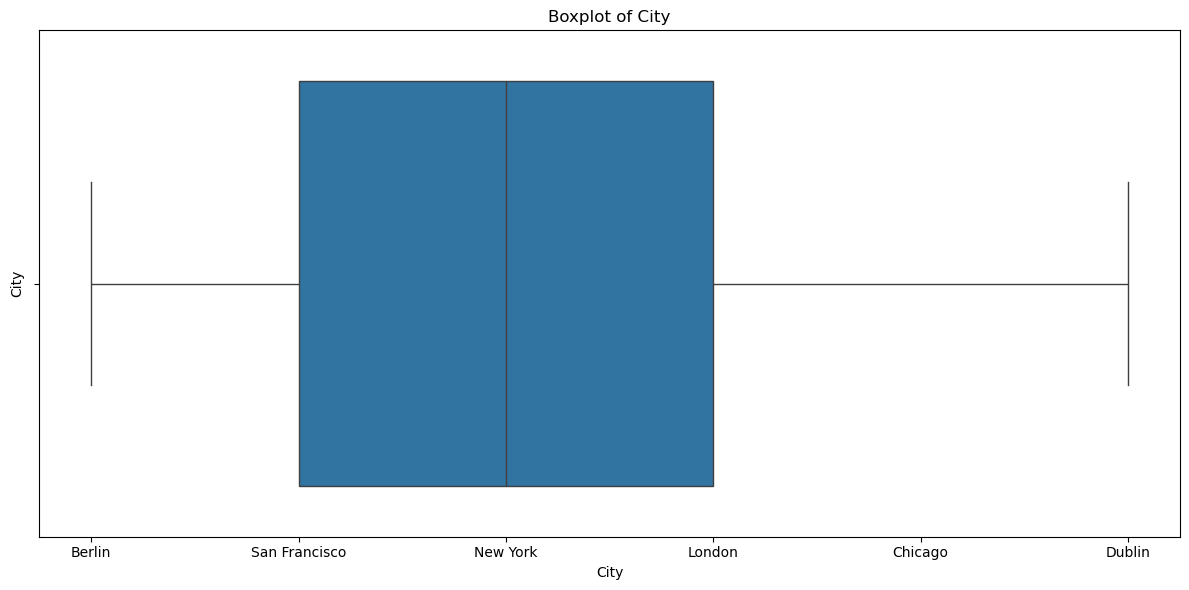

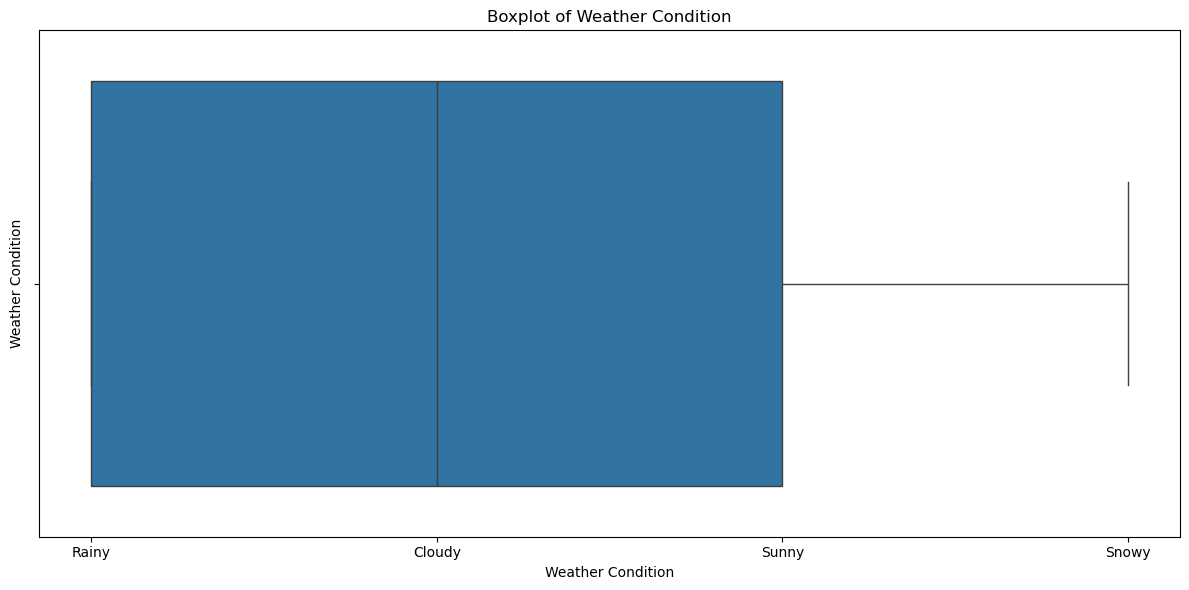

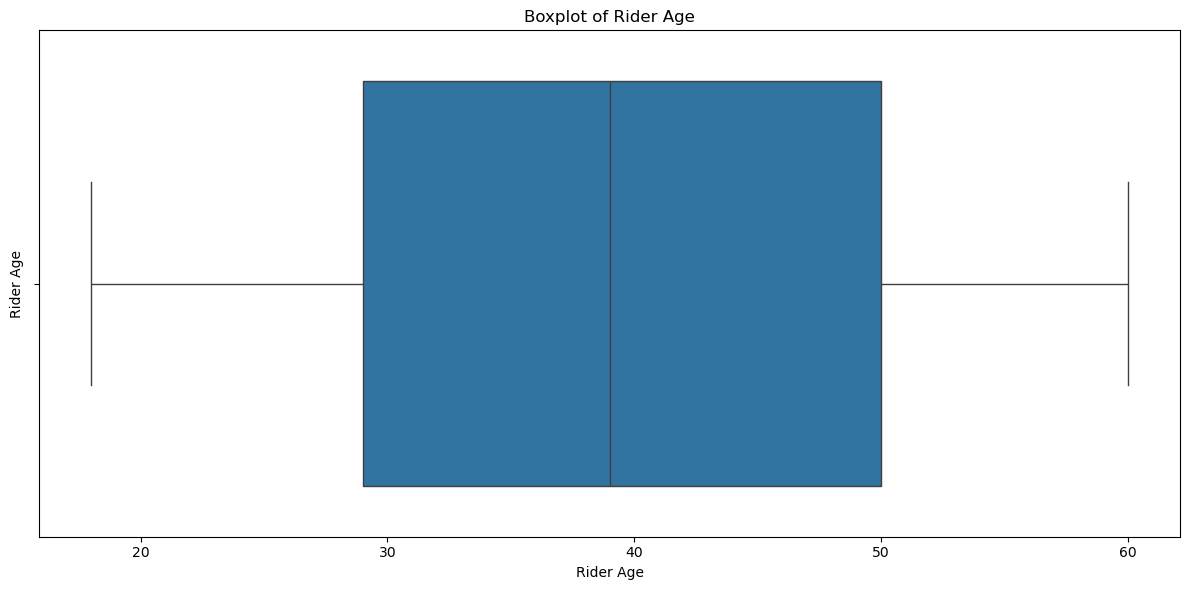

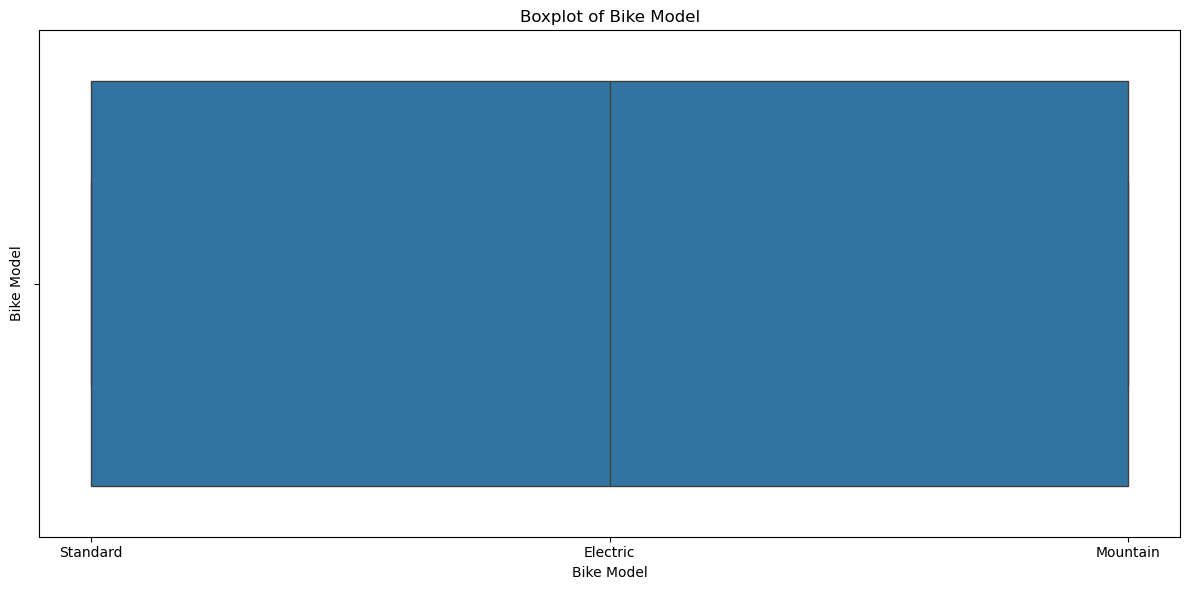

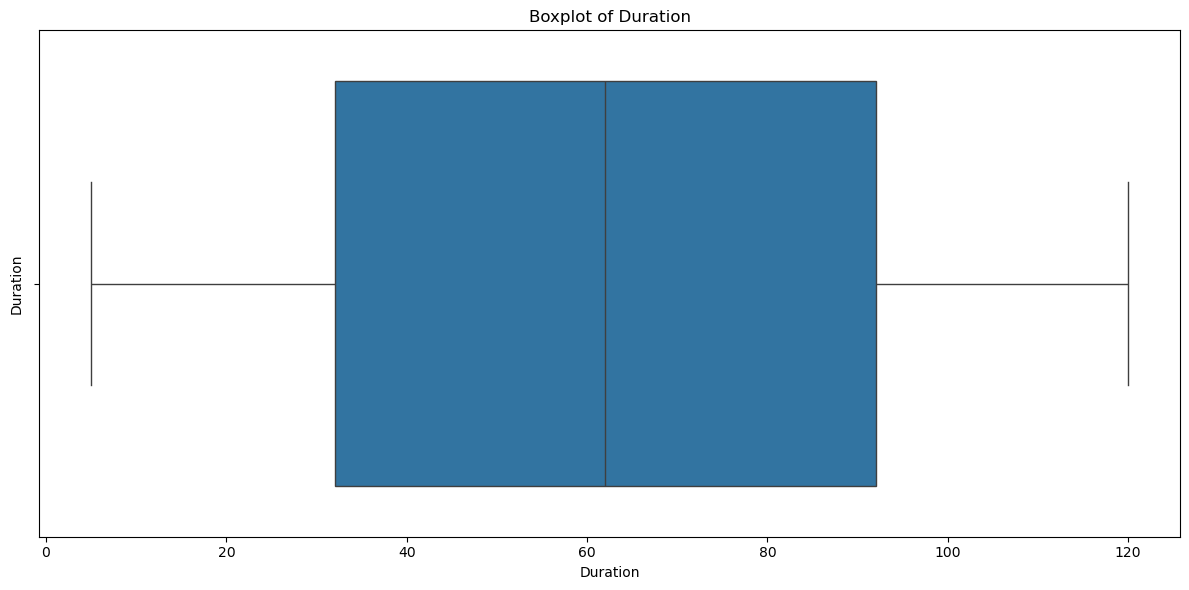

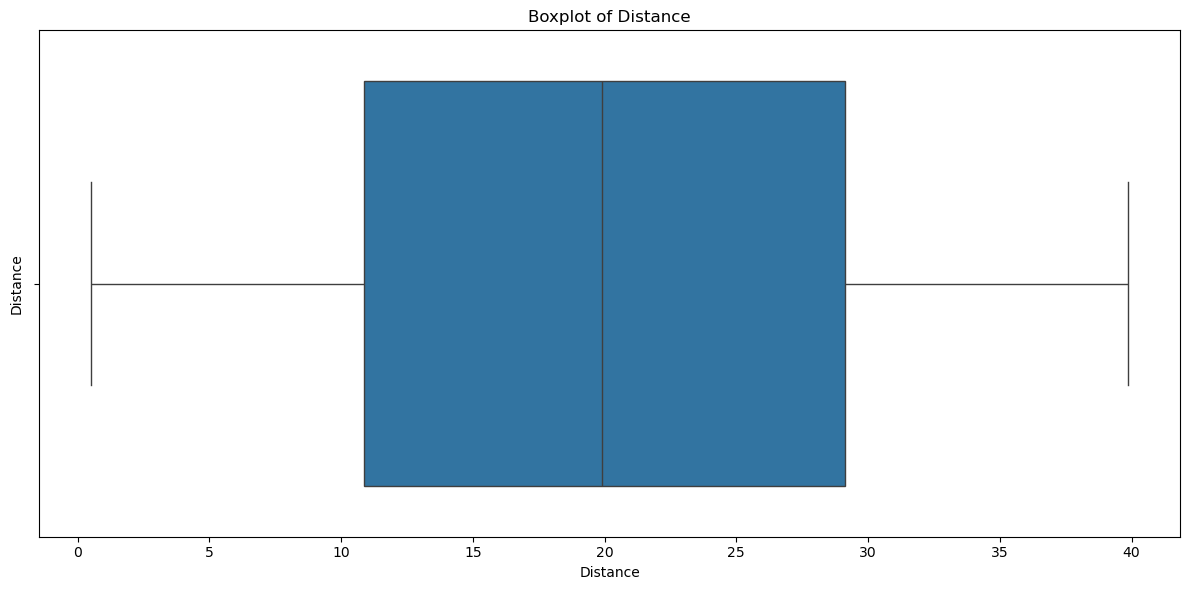

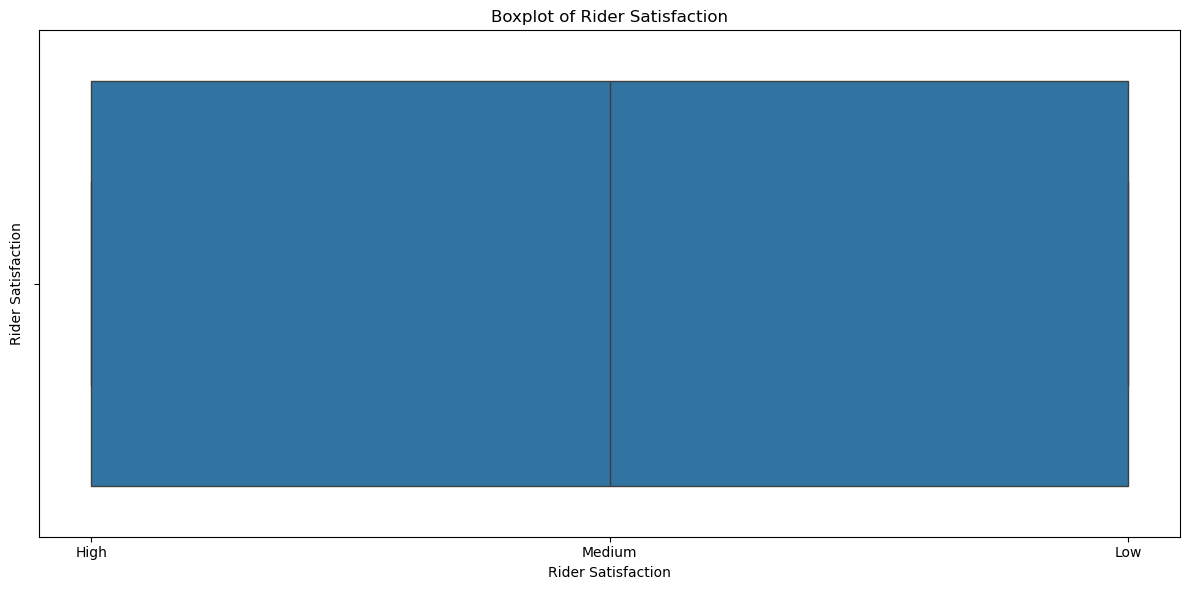

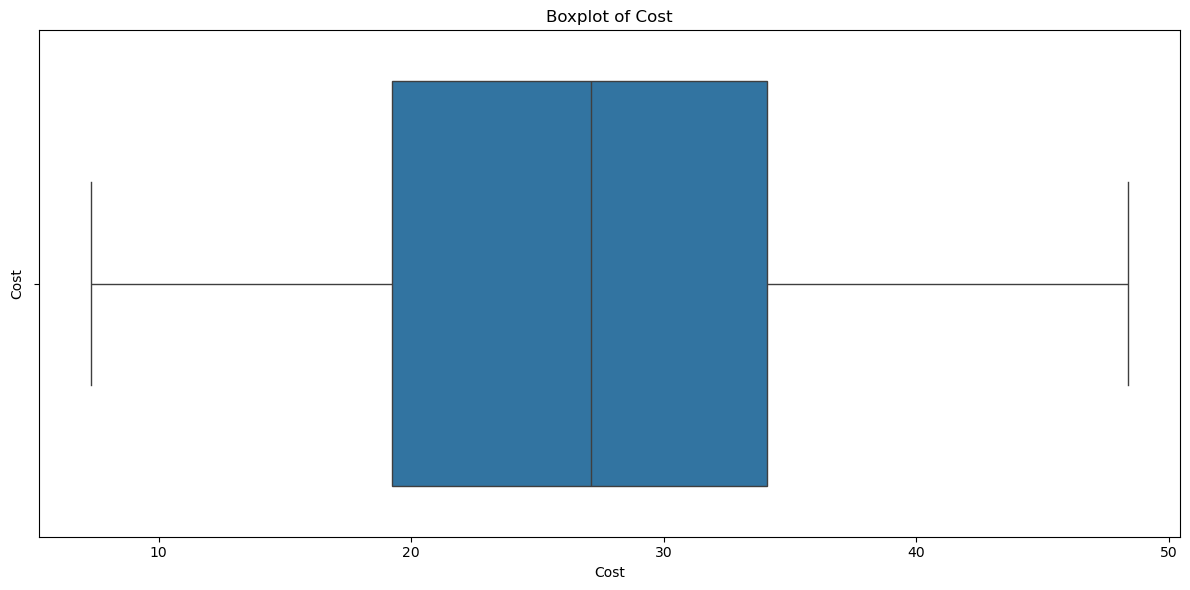

In [29]:
columns_to_plot = df
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[column]) 
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show() 

# Statistical Point of View

## Contingency table of categorical variables

In [32]:
df1 = df.copy()
contingency_table = pd.crosstab(
    df1["City"], 
    df1["Weather Condition"], 
    margins=True,  # Adding totals
    margins_name="Total"
)

print(contingency_table)


Weather Condition  Cloudy  Rainy  Snowy  Sunny  Total
City                                                 
Berlin                 41     43     41     47    172
Chicago                41     50     41     36    168
Dublin                  5     10      8      6     29
London                 38     52     49     54    193
New York               39     46     41     44    170
San Francisco          44     51     38     35    168
Total                 208    252    218    222    900


In [33]:
contingency_table_city_bike = pd.crosstab(
    df1["City"], 
    df1["Bike Model"], 
    margins=True,  # Adding totals
    margins_name="Total"
)

print(contingency_table_city_bike)

Bike Model     Electric  Mountain  Standard  Total
City                                              
Berlin               56        62        54    172
Chicago              58        57        53    168
Dublin                7        13         9     29
London               61        72        60    193
New York             56        46        68    170
San Francisco        59        52        57    168
Total               297       302       301    900


In [34]:
contingency_table_bike_satisfaction = pd.crosstab(
    df1["Bike Model"], 
    df1["Rider Satisfaction"], 
    margins=True,  # Adding totals
    margins_name="Total"
)

print(contingency_table_bike_satisfaction)

Rider Satisfaction  High  Low  Medium  Total
Bike Model                                  
Electric             115   90      92    297
Mountain             109   96      97    302
Standard             101   89     111    301
Total                325  275     300    900


In [35]:
df1.describe()

Rider Age    Duration    Distance        Cost
count  900.000000  900.000000  900.000000  900.000000
mean    39.241667   62.141667   20.085394   26.637394
std     12.275444   33.890490   11.175077    9.424131
min     18.000000    5.000000    0.510000    7.330000
25%     29.000000   32.000000   10.870000   19.255000
50%     39.000000   62.000000   19.910000   27.100000
75%     50.000000   92.000000   29.127500   34.087500
max     60.000000  120.000000   39.870000   48.380000

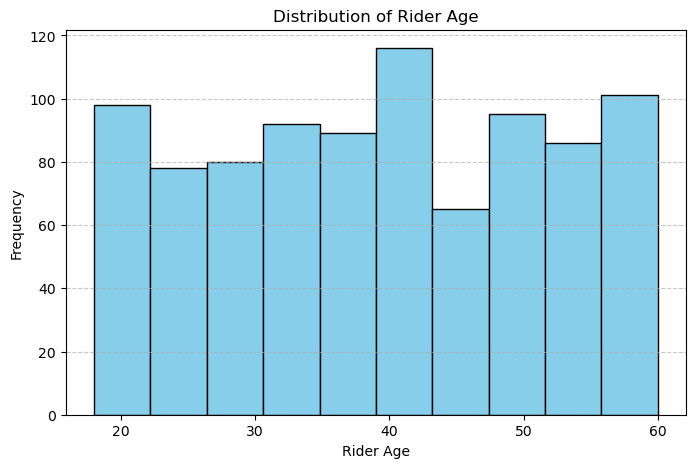

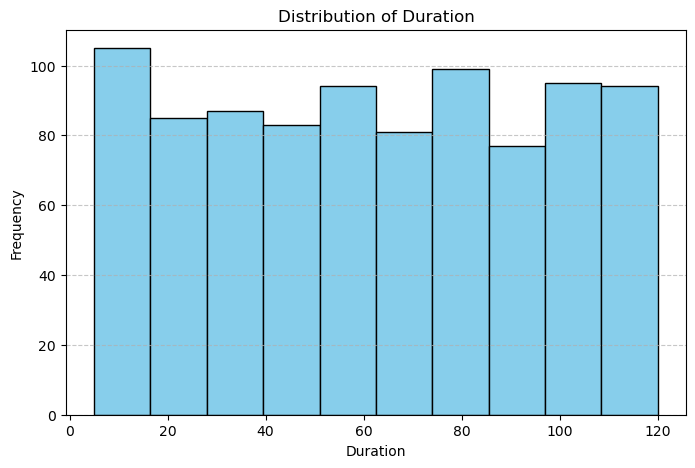

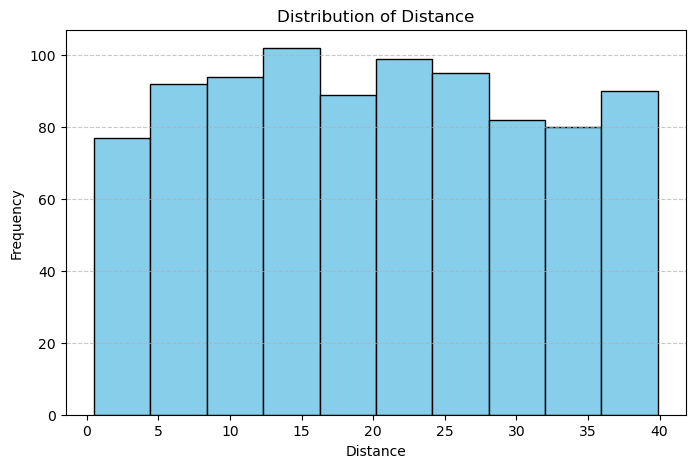

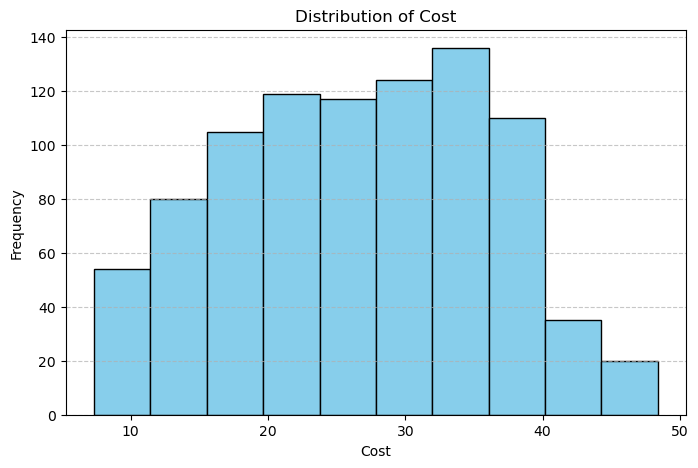

In [36]:
numeric_columns = ['Rider Age', 'Duration', 'Distance', 'Cost']

# Showing numerical histograms
for column in numeric_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df1[column], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

## Central Tendency for each numerical variable

In [38]:
for col in numeric_columns:
    # Central Tendency
    mean = df1[col].mean()
    median = df1[col].median()
    mode = df1[col].mode()[0]  # Mode might return multiple values
    
    # Variation
    std_dev = df1[col].std()
    variance = df1[col].var()
    range_value = df1[col].max() - df[col].min()
    
    # Probability Distribution
    skewness = df1[col].skew()
    kurtosis = df1[col].kurt()
    
    # Print the results
    print(f"\n\ncolumn {col} Mean: {mean}, Median: {median}, Mode: {mode}")
    print(f"Standard Deviation for column {col}: {std_dev}, Variance: {variance}, Range: {range_value}")
    print(f"Skewness: {skewness}, Kurtosis column {col}: {kurtosis}")



column Rider Age Mean: 39.24166666666667, Median: 39.0, Mode: 36.0
Standard Deviation for column Rider Age: 12.275444052918374, Variance: 150.68652669632905, Range: 42.0
Skewness: 0.007585297487263629, Kurtosis column Rider Age: -1.1603331404152901


column Duration Mean: 62.141666666666666, Median: 62.0, Mode: 40.0
Standard Deviation for column Duration: 33.89048953419869, Variance: 1148.5652808676311, Range: 115.0
Skewness: -0.007374176468389233, Kurtosis column Duration: -1.2299216624336675


column Distance Mean: 20.085394444444443, Median: 19.91, Mode: 13.32
Standard Deviation for column Distance: 11.175076901486648, Variance: 124.88234375414041, Range: 39.36
Skewness: 0.054161598512593896, Kurtosis column Distance: -1.1293004478592585


column Cost Mean: 26.637394444444443, Median: 27.1, Mode: 15.67
Standard Deviation for column Cost: 9.424130868124992, Variance: 88.81424261954633, Range: 41.050000000000004
Skewness: -0.06401991399786086, Kurtosis column Cost: -0.90001258909768

## Applying Shapiro Wilk to each variable to check normality

In [40]:
#Appliying Shapiro Wilk to each numerical column

for col in numeric_columns:
    stat, p_value = shapiro(df1[col])
    print(f"Shapiro-Wilk test for {col}:")
    print(f"  Statistic = {stat}, p-value = {p_value}\n")

    if p_value > 0.05:
        print(f"{col} seems to follow a normal distribution (p > 0.05)\n")
    else:
        print(f"{col} does not follow a normal distribution (p ≤ 0.05)\n")

Shapiro-Wilk test for Rider Age:
  Statistic = 0.9572060304388601, p-value = 1.5216846508653191e-15

Rider Age does not follow a normal distribution (p ≤ 0.05)

Shapiro-Wilk test for Duration:
  Statistic = 0.9505403897946132, p-value = 8.18586861072563e-17

Duration does not follow a normal distribution (p ≤ 0.05)

Shapiro-Wilk test for Distance:
  Statistic = 0.9598426470295843, p-value = 5.280348346035164e-15

Distance does not follow a normal distribution (p ≤ 0.05)

Shapiro-Wilk test for Cost:
  Statistic = 0.9793455508956352, p-value = 5.543185684985517e-10

Cost does not follow a normal distribution (p ≤ 0.05)



In [41]:
df1.head()

City Weather Condition  Rider Age Bike Model  Duration  Distance  \
0         Berlin             Rainy       53.0   Standard      62.0      2.25   
1  San Francisco            Cloudy       39.0   Standard       5.0     21.67   
2         Berlin             Sunny       43.0   Electric     106.0     28.40   
3  San Francisco            Cloudy       24.0   Standard     119.0      5.66   
4       New York             Sunny       24.0   Mountain      11.0     25.74   

  Rider Satisfaction   Cost  
0               High  22.63  
1             Medium   7.87  
2               High  39.40  
3                Low  37.63  
4                Low  13.12

## Functions for Statistical Techniques 
### (Histogram [Descriptive Statistics, Q-Q Plot, Shapiro], Box-Cox, Logarithm Transformation, Confidence Interval, T-Test, Anova)

In [43]:
def create_histogram(df1, target_column, column):
    """
    Generates histograms, Q-Q plots, descriptive statistics, 
    displays sample size, and performs the Shapiro-Wilk test to check for normality.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: The numeric column to be analyzed (e.g., "Cost").
    - column: The categorical column to group the data by (e.g., "Category").

    Outputs:
    - Descriptive statistics and sample size for each category.
    - Histogram and Q-Q plot for each category.
    - Shapiro-Wilk test results indicating if the data is normally distributed.
    """
    categories = df1[column].unique()  # Get unique categories

    for category in categories:
        # Filter the data for the current category
        data = df1[df1[column] == category][target_column]
        sample_size = len(data)  # Get sample size

        # Display descriptive statistics and sample size
        print(f"Descriptive Statistics for {category} category:")
        print(f"Sample Size: {sample_size}")
        print(f"Mean: {data.mean():.4f}")
        print(f"Median: {data.median():.4f}")
        print(f"Standard Deviation: {data.std():.4f}")
        print(f"Minimum: {data.min():.4f}")
        print(f"Maximum: {data.max():.4f}")
        print(f"Skewness: {stats.skew(data):.4f}")
        print(f"Kurtosis: {stats.kurtosis(data):.4f}")
        print("-" * 40)
        
        # Plot the histogram
        plt.figure(figsize=(8, 5))
        plt.hist(data, bins=10, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {target_column} for {category} category\n(Sample Size: {sample_size})')
        plt.xlabel(target_column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
        # Plot the Q-Q plot
        plt.figure(figsize=(8, 5))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for {category} category')
        plt.show()

        # Perform the Shapiro-Wilk test for normality
        stat, p = shapiro(data)
        print(f"Shapiro-Wilk Test for {category} category:")
        print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
        
        # Interpret the p-value
        if p > 0.05:
            print(f"The data for '{category}' appears to be normally distributed.\n")
        else:
            print(f"The data for '{category}' does NOT appear to be normally distributed.\n")

def box_cox(df1, target_column, column):
    """
    Applies the Box-Cox transformation to a specified numeric column in the DataFrame 
    and sends the transformed data to the `create_histogram` function for analysis.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: The numeric column to be transformed (e.g., "Cost").
    - column: The categorical column to group the data by (e.g., "Category").

    Outputs:
    - Transformed data passed to `create_histogram` for visualization and analysis.
    """
    transformed_data = df1.copy()  # Create a copy of the DataFrame to avoid modifying the original
    categories = df1[column].unique()  # Get unique categories
    
    for category in categories:
        # Filter the data for the current category
        data = df1[df1[column] == category][target_column]
        
        # Ensure the data is positive (Box-Cox requires strictly positive values)
        if any(data <= 0):
            adjustment = abs(data.min()) + 1
            print(f"Adjusting data for '{category}' by adding {adjustment:.4f}.")
            data = data + adjustment
        
        # Apply the Box-Cox transformation
        transformed_values, lambda_value = stats.boxcox(data)
        
        # Update the transformed values in the copied DataFrame
        transformed_data.loc[transformed_data[column] == category, target_column] = transformed_values
        
        # Print the lambda value for the current category
        print(f"Box-Cox Transformation for {category} category:")
        print(f"Estimated lambda: {lambda_value:.4f}\n")
    
    # Send the transformed DataFrame to `create_histogram` for analysis
    create_histogram(transformed_data, target_column, column)

def log_transform(df1, target_column, column):
    """
    Applies a logarithmic transformation to a specified numeric column in the DataFrame 
    and sends the transformed data to the `create_histogram` function for analysis.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: The numeric column to be transformed (e.g., "Cost").
    - column: The categorical column to group the data by (e.g., "Category").
    """
    transformed_data = df1.copy()  # Create a copy of the DataFrame to avoid modifying the original
    categories = df1[column].unique()  # Get unique categories
    
    for category in categories:
        # Filter the data for the current category
        data = df1[df1[column] == category][target_column]
        
        # Ensure the data is positive (log transformation requires strictly positive values)
        if any(data <= 0):
            adjustment = abs(data.min()) + 1
            print(f"Adjusting data for '{category}' by adding {adjustment:.4f}.")
            data = data + adjustment
        
        # Apply the logarithmic transformation (natural logarithm)
        transformed_values = np.log(data)
        
        # Update the transformed values in the copied DataFrame
        transformed_data.loc[transformed_data[column] == category, target_column] = transformed_values
        
        # Print confirmation of the transformation for the current category
        print(f"Logarithmic Transformation for {category} category applied.\n")
    
    # Send the transformed DataFrame to `create_histogram` for analysis
    create_histogram(transformed_data, target_column, column)

def confidence_interval(df1, target_column, column, confidence_level=0.95):
    """
    Calculate and print the confidence interval and standard error (SE) for the mean 
    of a specific numeric column, grouped by a categorical column.

    Parameters:
    - df: DataFrame containing the data.
    - target_column: The numeric column (e.g., "Cost").
    - column: The categorical column (e.g., "Category").
    - confidence_level: Confidence level (default is 0.95).
    """
    categories = df1[column].unique()  # Get unique categories

    for category in categories:
        # Filter the data for the current category to get the sample
        data = df1[df1[column] == category][target_column]
        
        # Calculate mean and standard error
        mean = np.mean(data)  # Mean of the sample data
        std_dev = np.std(data, ddof=1)  # Sample standard deviation
        n = len(data)  # Number of observations
        standard_error = std_dev / np.sqrt(n)  # Standard Error (SE)
        
        # Calculate the margin of error using z-distribution
        alpha = 1 - confidence_level
        z = norm.ppf(1 - alpha / 2)  # Z-score for two-tailed confidence interval
        margin_of_error = z * standard_error  # Margin for upper and lower limit
        
        # Calculate the confidence interval
        lower_bound = mean - margin_of_error
        upper_bound = mean + margin_of_error
        
        # Print the results
        print(f"{category} Category:")
        print(f"Sample Size (n): {n}")
        print(f"Mean: {mean:.4f}")
        print(f"Standard Deviation (ST): {std_dev:.4f}")
        print(f"Standard Error (SE): {standard_error:.4f}")
        print(f"{int(confidence_level * 100)}% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})\n")

def t_test(df1, target_column, column, category1, category2, alternative='two-sided'):
    """
    Performs an independent t-test to compare the means of a numeric column
    between two categories of a categorical column.

    Parameters:
    - df1: DataFrame containing the data.
    - target_column: The numeric column to perform the t-test on (e.g., "Cost").
    - column: The categorical column to group the data by (e.g., "Category").
    - category1: The first category to compare.
    - category2: The second category to compare.
    - alternative: Defines the alternative hypothesis. Options are:
        * 'two-sided' (default): Tests for differences in both directions.
        * 'less': Tests if the mean of category1 is less than category2.
        * 'greater': Tests if the mean of category1 is greater than category2.
    
    Outputs:
    - T-statistic and p-value.
    - Interpretation of the result based on the p-value.
    """
    # Filter the data for the two categories
    data1 = df1[df1[column] == category1][target_column]
    data2 = df1[df1[column] == category2][target_column]
    
    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(data1, data2, alternative=alternative, equal_var=False)  # Welch's t-test
    
    # Print the results
    print(f"T-Test Results for '{category1}' vs. '{category2}':")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    if alternative == 'two-sided':
        if p_value < 0.05:
            print(f"Reject the null hypothesis: Significant difference between the means of '{category1}' and '{category2}'.")
        else:
            print(f"Fail to reject the null hypothesis: No significant difference between the means of '{category1}' and '{category2}'.")
    elif alternative == 'less':
        if p_value < 0.05:
            print(f"Reject the null hypothesis: The mean of '{category1}' is significantly less than the mean of '{category2}'.")
        else:
            print(f"Fail to reject the null hypothesis: The mean of '{category1}' is NOT significantly less than the mean of '{category2}'.")
    elif alternative == 'greater':
        if p_value < 0.05:
            print(f"Reject the null hypothesis: The mean of '{category1}' is significantly greater than the mean of '{category2}'.")
        else:
            print(f"Fail to reject the null hypothesis: The mean of '{category1}' is NOT significantly greater than the mean of '{category2}'.")
    
    print("-" * 40)


def anova_test(df1, target_column, column):
    """
    Performs a one-way ANOVA test to check if there are significant differences
    in the mean of a specific numeric column grouped by a categorical column.
    
    Parameters:
    - df1: DataFrame containing the data
    - target_column: The numeric column to perform ANOVA on (e.g., "Costo").
    - column: The categorical column with the groups (e.g., "Categoría").
    """
    categories = df1[column].unique()
    
    # Create a list of the data for each category
    data_for_anova = [df1[df1[column] == category][target_column] for category in categories]
    
    # Perform the ANOVA test
    f_stat, p_value = stats.f_oneway(*data_for_anova)
    
    print(f"ANOVA Test Results:")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
    
    # Interpret the result
    if p_value < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference in the mean {target_column} across the categories.\n")
    else:
        print(f"Fail to reject the null hypothesis: There is no significant difference in the mean {target_column} across the categories.\n")

## Cost vs Rider Satisfaction

Descriptive Statistics for High category:
Sample Size: 325
Mean: 26.7427
Median: 27.0400
Standard Deviation: 9.3804
Minimum: 7.3300
Maximum: 47.4000
Skewness: -0.1117
Kurtosis: -0.9775
----------------------------------------


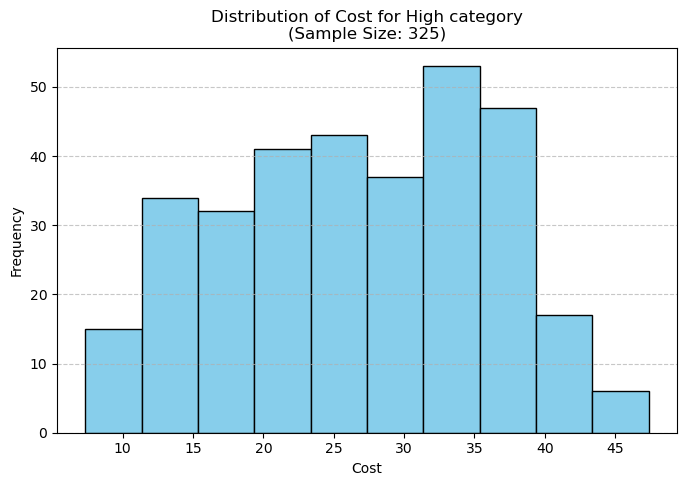

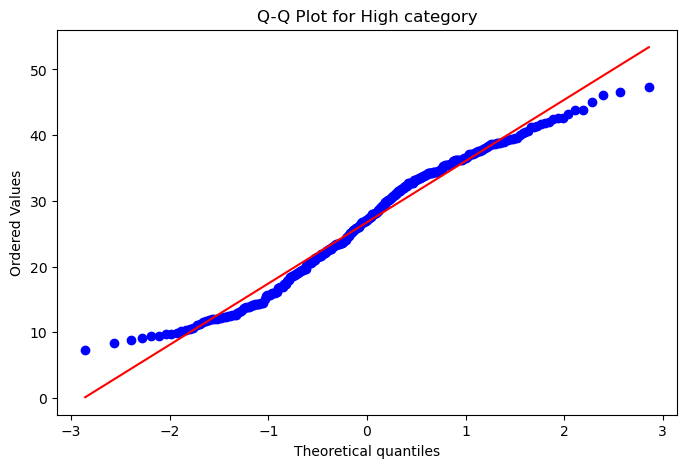

Shapiro-Wilk Test for High category:
Statistic = 0.9733, p-value = 0.0000
The data for 'High' does NOT appear to be normally distributed.

Descriptive Statistics for Medium category:
Sample Size: 300
Mean: 26.5842
Median: 27.1750
Standard Deviation: 9.6072
Minimum: 7.8700
Maximum: 48.3800
Skewness: 0.0341
Kurtosis: -0.8107
----------------------------------------


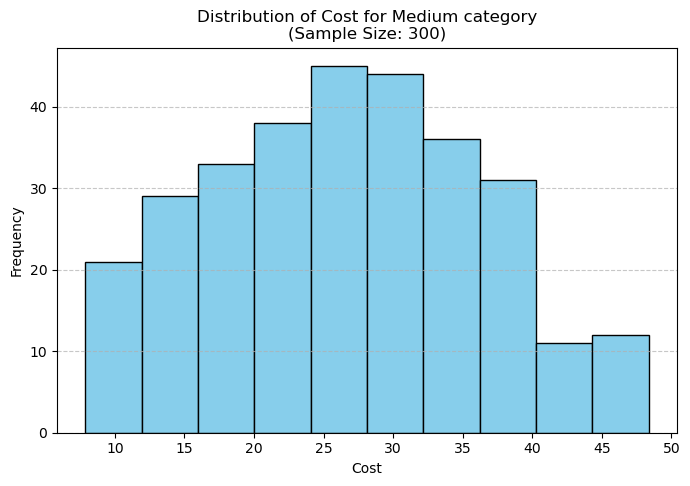

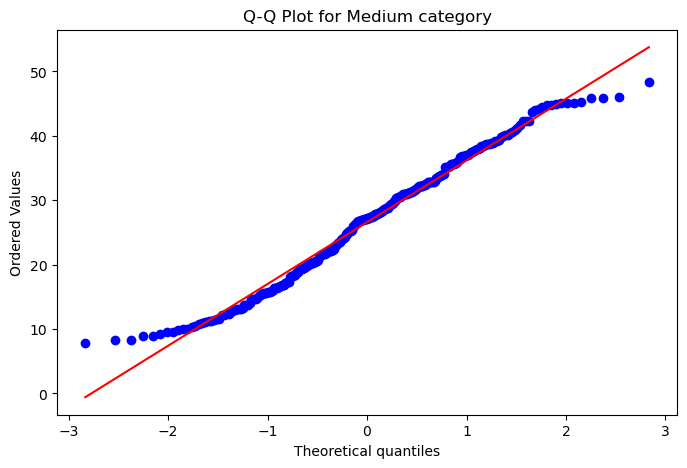

Shapiro-Wilk Test for Medium category:
Statistic = 0.9815, p-value = 0.0007
The data for 'Medium' does NOT appear to be normally distributed.

Descriptive Statistics for Low category:
Sample Size: 275
Mean: 26.5709
Median: 27.0100
Standard Deviation: 9.3066
Minimum: 7.9600
Maximum: 46.6400
Skewness: -0.1231
Kurtosis: -0.9240
----------------------------------------


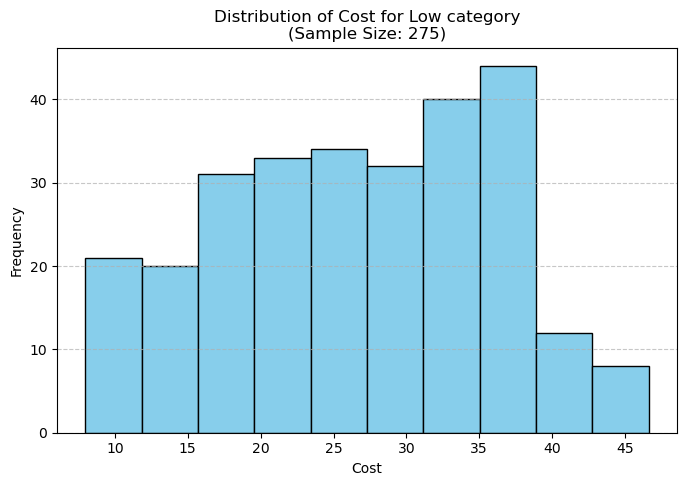

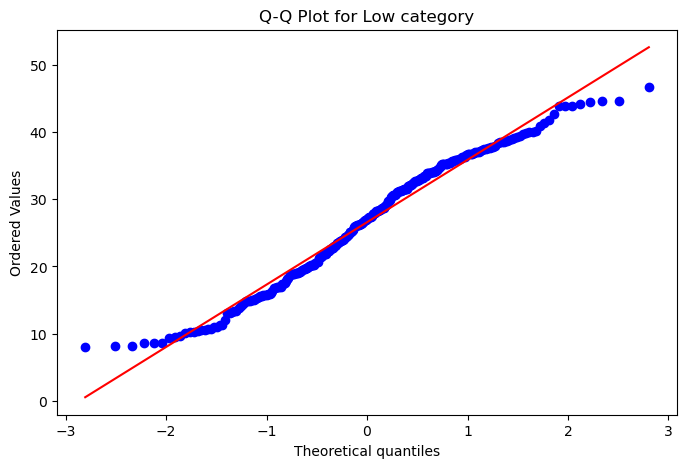

Shapiro-Wilk Test for Low category:
Statistic = 0.9755, p-value = 0.0001
The data for 'Low' does NOT appear to be normally distributed.



In [45]:
# Plotting the hsitogram for cost vs different categories of satisfaction
create_histogram(df1, 'Cost', 'Rider Satisfaction')

### Data Transformation (Box-Cox)

Box-Cox Transformation for High category:
Estimated lambda: 0.9565

Box-Cox Transformation for Medium category:
Estimated lambda: 0.8080

Box-Cox Transformation for Low category:
Estimated lambda: 0.9818

Descriptive Statistics for High category:
Sample Size: 325
Mean: 23.1228
Median: 23.4464
Standard Deviation: 8.1556
Minimum: 5.9817
Maximum: 40.8521
Skewness: -0.1367
Kurtosis: -0.9713
----------------------------------------


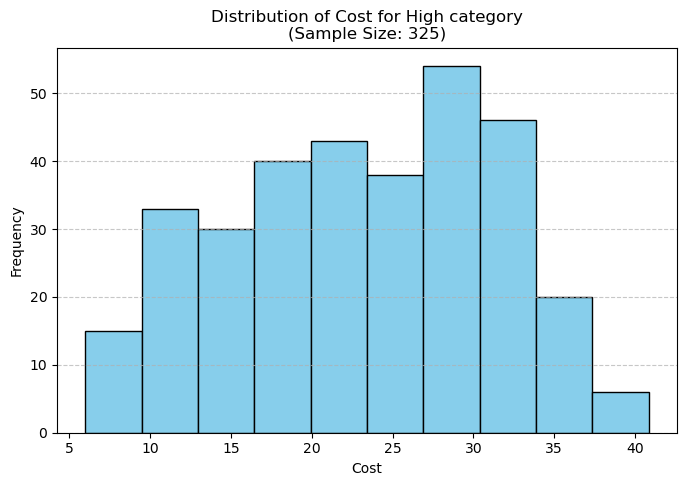

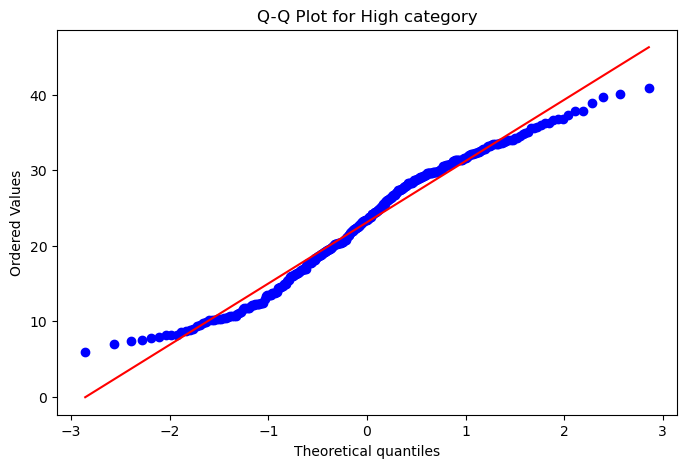

Shapiro-Wilk Test for High category:
Statistic = 0.9730, p-value = 0.0000
The data for 'High' does NOT appear to be normally distributed.

Descriptive Statistics for Medium category:
Sample Size: 300
Mean: 16.0993
Median: 16.6021
Standard Deviation: 5.1776
Minimum: 5.3167
Maximum: 27.1929
Skewness: -0.0976
Kurtosis: -0.8056
----------------------------------------


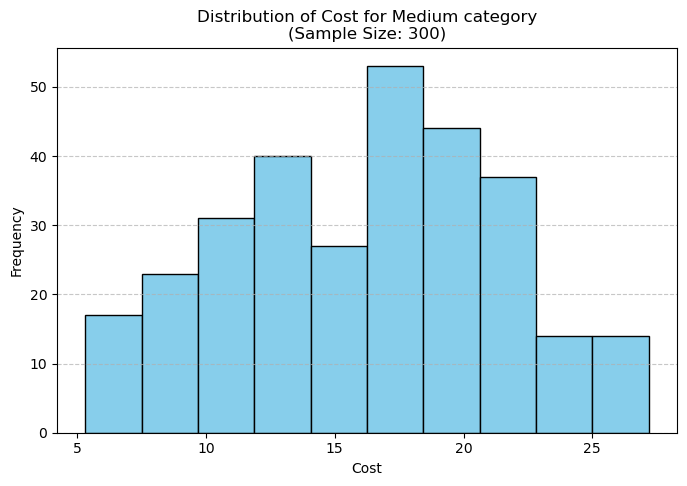

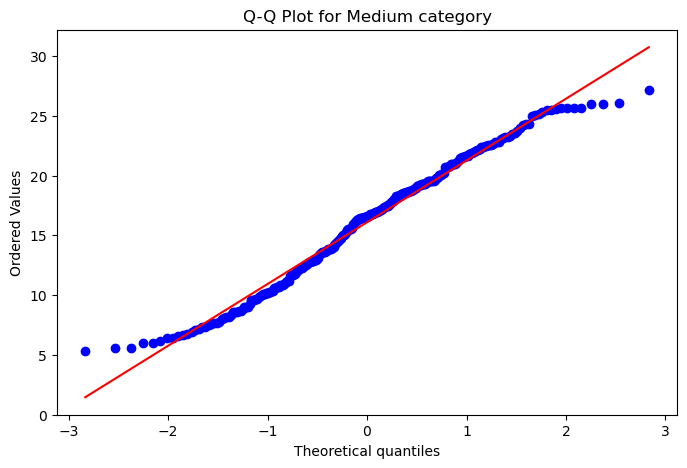

Shapiro-Wilk Test for Medium category:
Statistic = 0.9815, p-value = 0.0006
The data for 'Medium' does NOT appear to be normally distributed.

Descriptive Statistics for Low category:
Sample Size: 275
Mean: 24.4451
Median: 24.8884
Standard Deviation: 8.7780
Minimum: 6.7883
Maximum: 43.2735
Skewness: -0.1342
Kurtosis: -0.9200
----------------------------------------


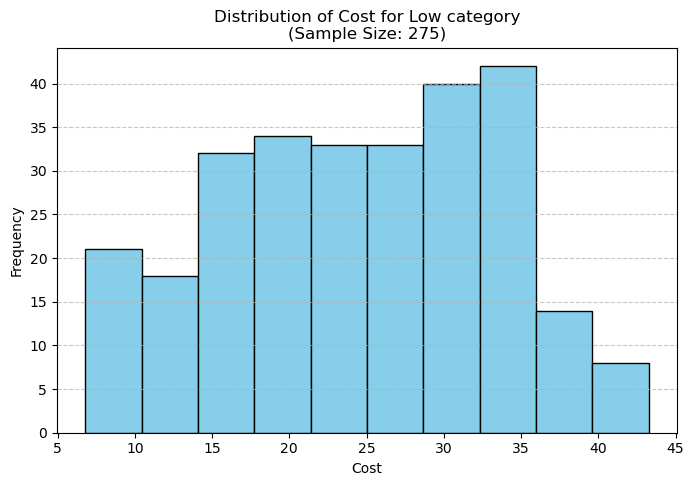

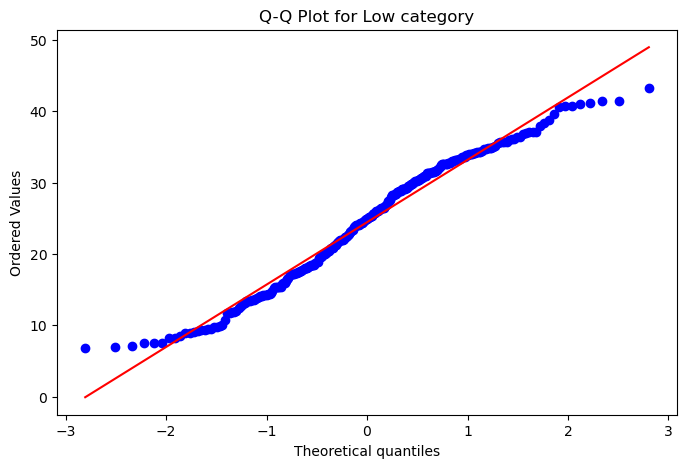

Shapiro-Wilk Test for Low category:
Statistic = 0.9753, p-value = 0.0001
The data for 'Low' does NOT appear to be normally distributed.



In [47]:
box_cox(df1, 'Cost', 'Rider Satisfaction')

### Confidence Interval

Text(0, 0.5, 'Cost')

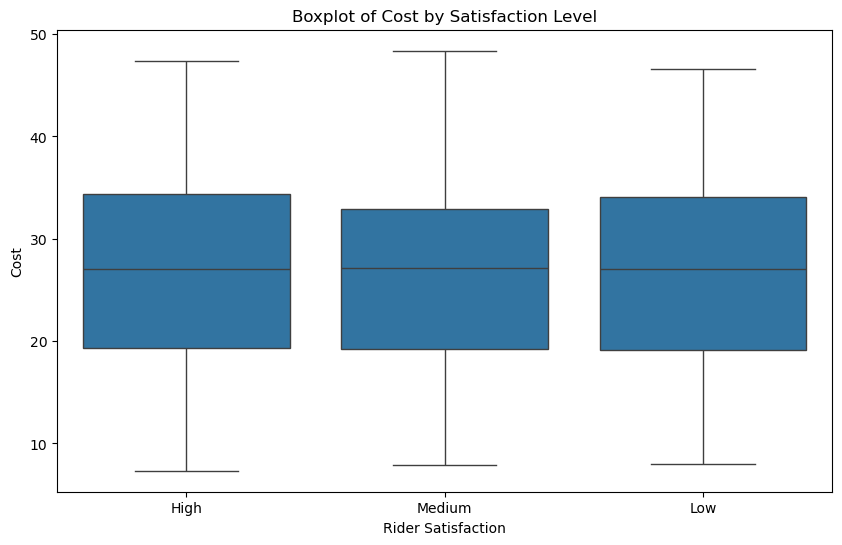

In [49]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='Rider Satisfaction', y='Cost', data=df1)
plt.title('Boxplot of Cost by Satisfaction Level') 
plt.xlabel('Rider Satisfaction') 
plt.ylabel('Cost')

In [50]:
# Getting our confidence interval for cost against different level of satisfaction
confidence_interval(df1, 'Cost', 'Rider Satisfaction')

High Category:
Sample Size (n): 325
Mean: 26.7427
Standard Deviation (ST): 9.3804
Standard Error (SE): 0.5203
95% Confidence Interval: (25.7229, 27.7625)

Medium Category:
Sample Size (n): 300
Mean: 26.5842
Standard Deviation (ST): 9.6072
Standard Error (SE): 0.5547
95% Confidence Interval: (25.4971, 27.6714)

Low Category:
Sample Size (n): 275
Mean: 26.5709
Standard Deviation (ST): 9.3066
Standard Error (SE): 0.5612
95% Confidence Interval: (25.4710, 27.6709)



### Applying ANOVA

In [52]:
# Getting our Anova for mean of costs against the three types of satisfacion (High-Medium-Low)
anova_test(df1, 'Cost', 'Rider Satisfaction')

ANOVA Test Results:
F-statistic: 0.0318, p-value: 0.9687
Fail to reject the null hypothesis: There is no significant difference in the mean Cost across the categories.



## Cost against Cities

Descriptive Statistics for Berlin category:
Sample Size: 172
Mean: 26.9084
Median: 27.6800
Standard Deviation: 9.4958
Minimum: 8.6700
Maximum: 46.6400
Skewness: -0.1463
Kurtosis: -0.9972
----------------------------------------


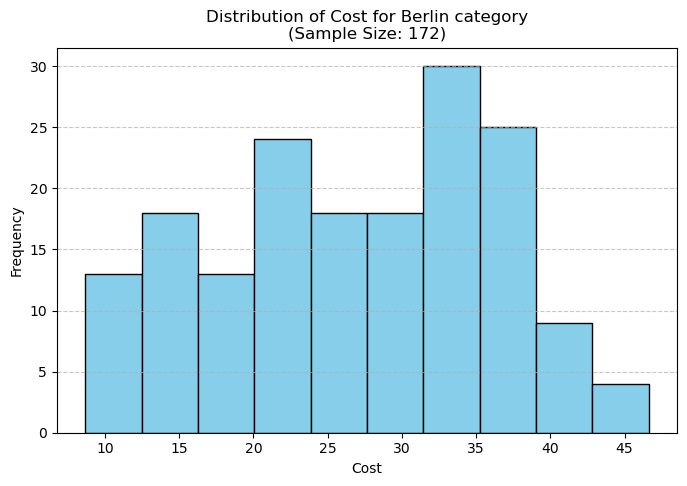

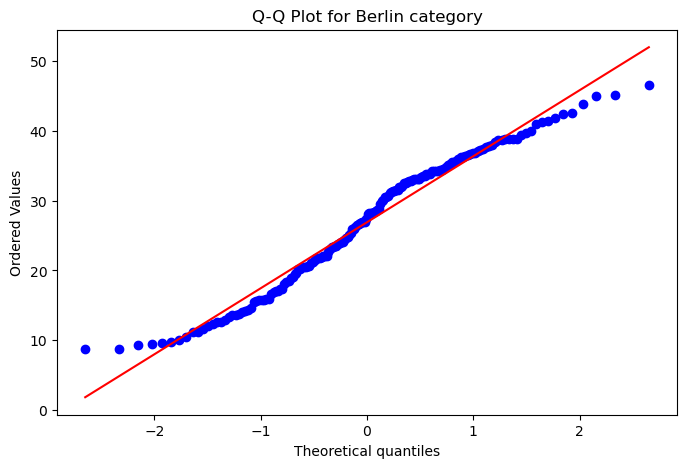

Shapiro-Wilk Test for Berlin category:
Statistic = 0.9692, p-value = 0.0007
The data for 'Berlin' does NOT appear to be normally distributed.

Descriptive Statistics for San Francisco category:
Sample Size: 168
Mean: 26.3171
Median: 27.0100
Standard Deviation: 9.6002
Minimum: 7.8700
Maximum: 47.4000
Skewness: -0.0553
Kurtosis: -0.8487
----------------------------------------


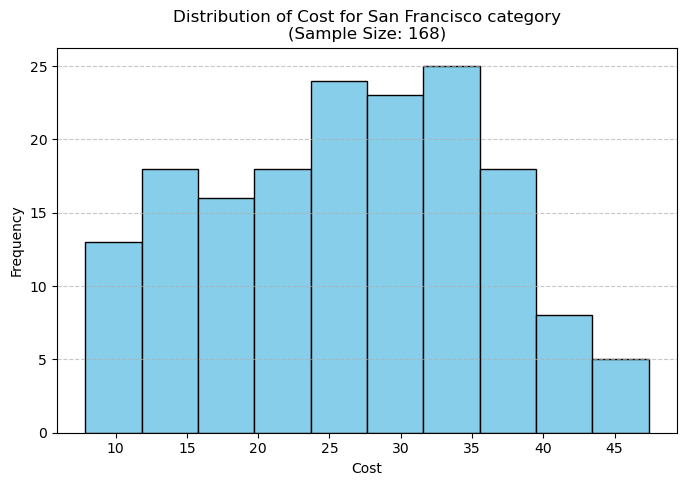

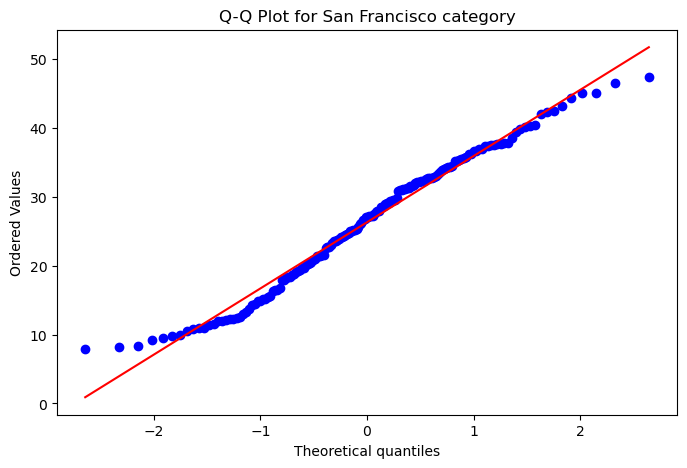

Shapiro-Wilk Test for San Francisco category:
Statistic = 0.9786, p-value = 0.0106
The data for 'San Francisco' does NOT appear to be normally distributed.

Descriptive Statistics for New York category:
Sample Size: 170
Mean: 26.4811
Median: 27.0800
Standard Deviation: 8.9153
Minimum: 7.3300
Maximum: 46.1000
Skewness: -0.1095
Kurtosis: -0.6956
----------------------------------------


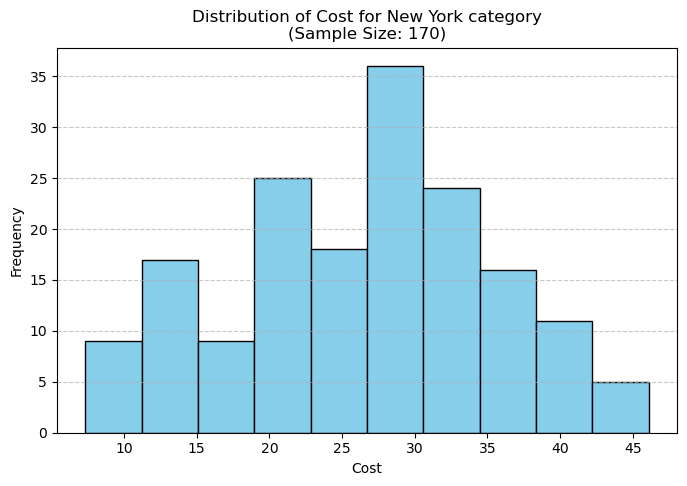

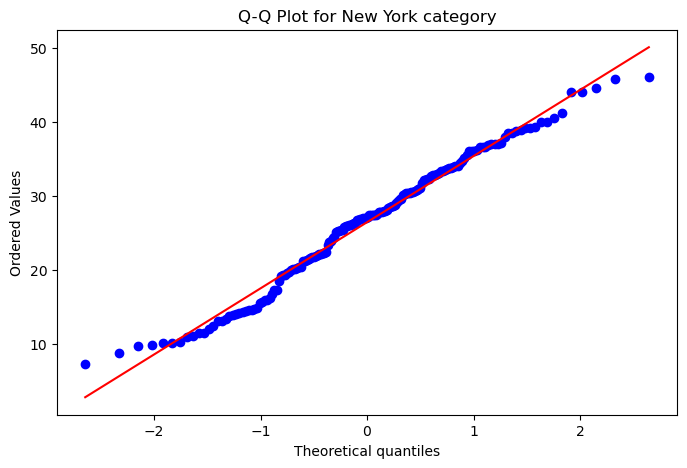

Shapiro-Wilk Test for New York category:
Statistic = 0.9823, p-value = 0.0294
The data for 'New York' does NOT appear to be normally distributed.

Descriptive Statistics for London category:
Sample Size: 193
Mean: 26.8391
Median: 27.1700
Standard Deviation: 9.5716
Minimum: 7.9600
Maximum: 46.0800
Skewness: 0.0009
Kurtosis: -1.0189
----------------------------------------


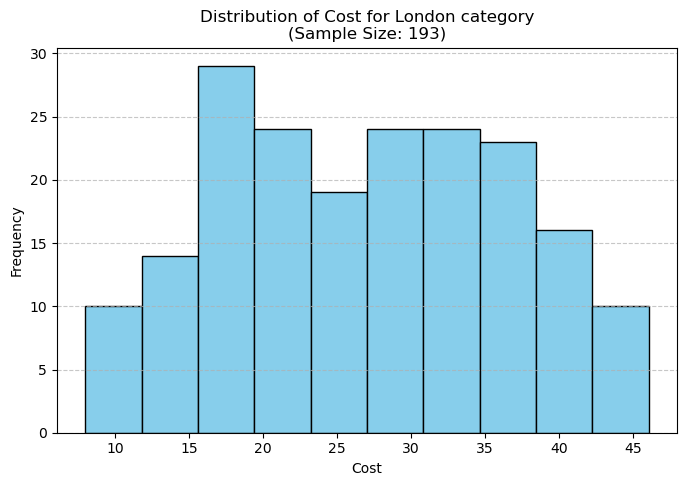

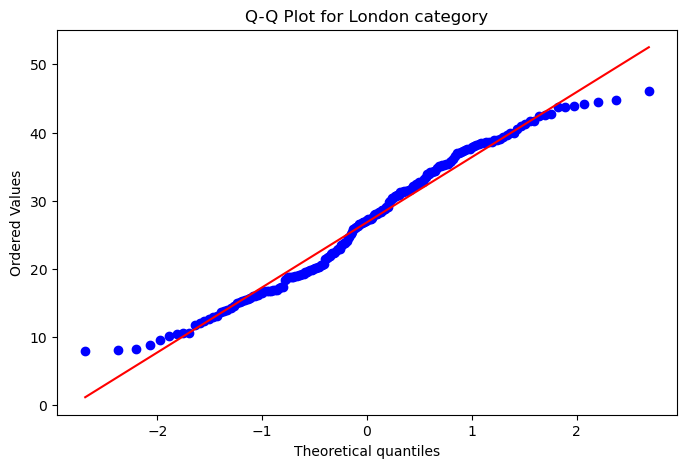

Shapiro-Wilk Test for London category:
Statistic = 0.9728, p-value = 0.0008
The data for 'London' does NOT appear to be normally distributed.

Descriptive Statistics for Chicago category:
Sample Size: 168
Mean: 26.2440
Median: 26.0950
Standard Deviation: 9.6840
Minimum: 8.2700
Maximum: 48.3800
Skewness: 0.0628
Kurtosis: -0.9087
----------------------------------------


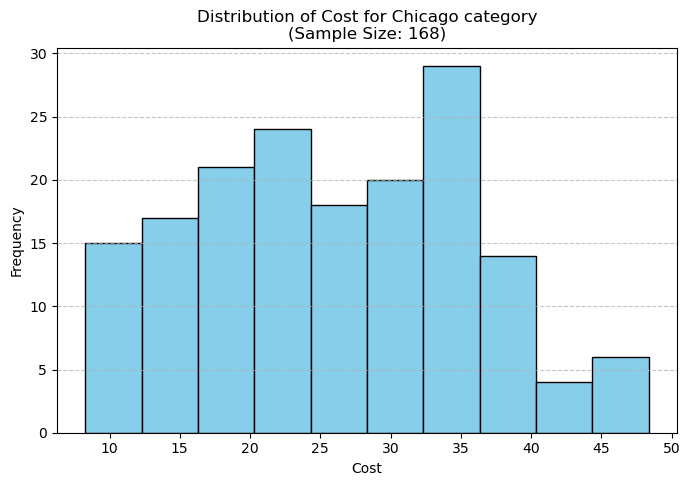

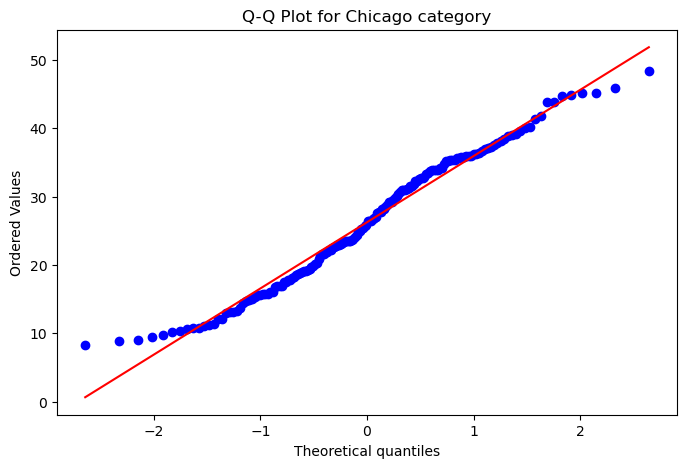

Shapiro-Wilk Test for Chicago category:
Statistic = 0.9760, p-value = 0.0052
The data for 'Chicago' does NOT appear to be normally distributed.

Descriptive Statistics for Dublin category:
Sample Size: 29
Mean: 28.7390
Median: 30.3600
Standard Deviation: 8.7701
Minimum: 8.7000
Maximum: 40.6600
Skewness: -0.6771
Kurtosis: -0.3959
----------------------------------------


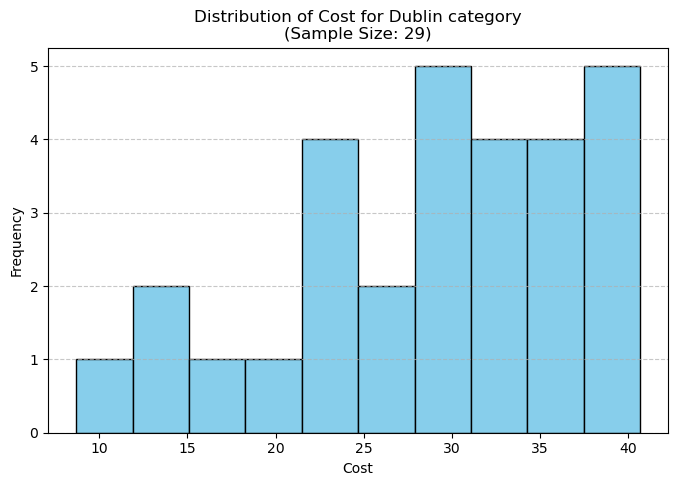

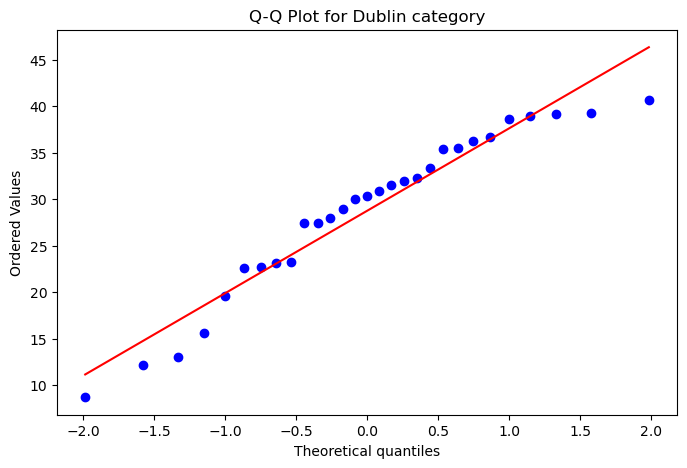

Shapiro-Wilk Test for Dublin category:
Statistic = 0.9349, p-value = 0.0739
The data for 'Dublin' appears to be normally distributed.



In [54]:
create_histogram(df1, 'Cost', 'City')

### Data Transformation

Box-Cox Transformation for Berlin category:
Estimated lambda: 0.9955

Box-Cox Transformation for San Francisco category:
Estimated lambda: 0.9003

Box-Cox Transformation for New York category:
Estimated lambda: 1.0021

Box-Cox Transformation for London category:
Estimated lambda: 0.8124

Box-Cox Transformation for Chicago category:
Estimated lambda: 0.7452

Box-Cox Transformation for Dublin category:
Estimated lambda: 1.7492

Descriptive Statistics for Berlin category:
Sample Size: 172
Mean: 25.6199
Median: 26.3880
Standard Deviation: 9.3592
Minimum: 7.6204
Maximum: 45.0428
Skewness: -0.1489
Kurtosis: -0.9964
----------------------------------------


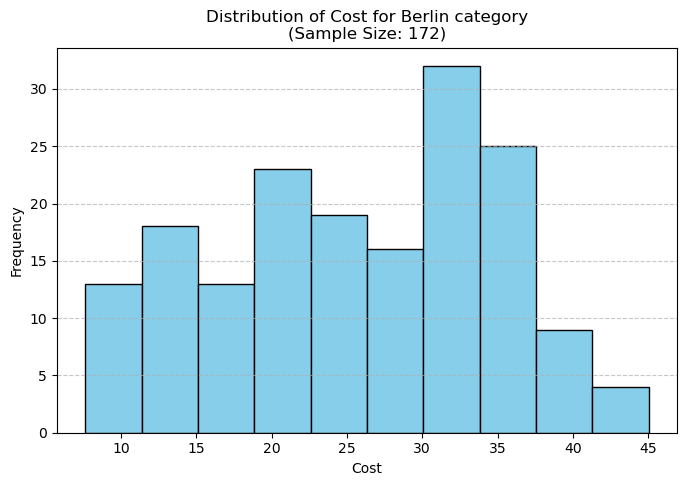

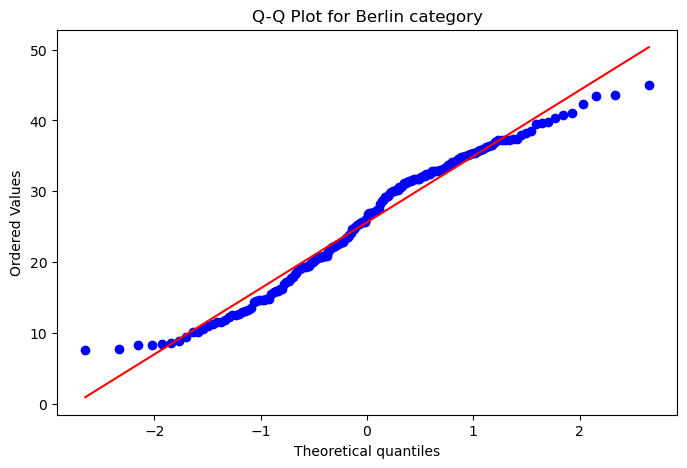

Shapiro-Wilk Test for Berlin category:
Statistic = 0.9692, p-value = 0.0007
The data for 'Berlin' does NOT appear to be normally distributed.

Descriptive Statistics for San Francisco category:
Sample Size: 168
Mean: 19.8541
Median: 20.4880
Standard Deviation: 6.9791
Minimum: 6.0057
Maximum: 34.7264
Skewness: -0.1218
Kurtosis: -0.8466
----------------------------------------


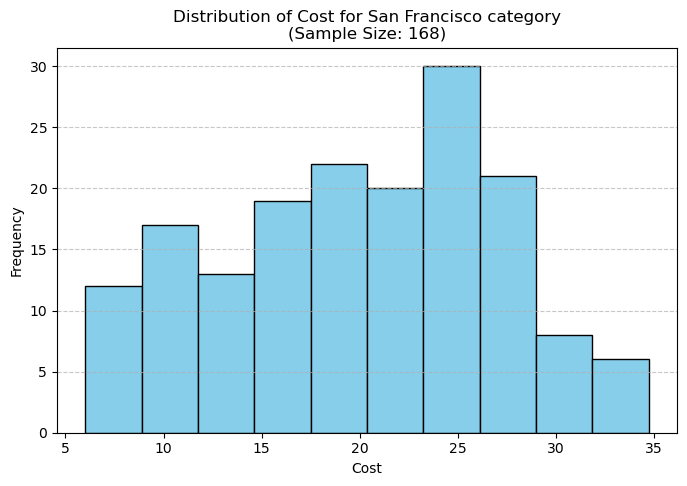

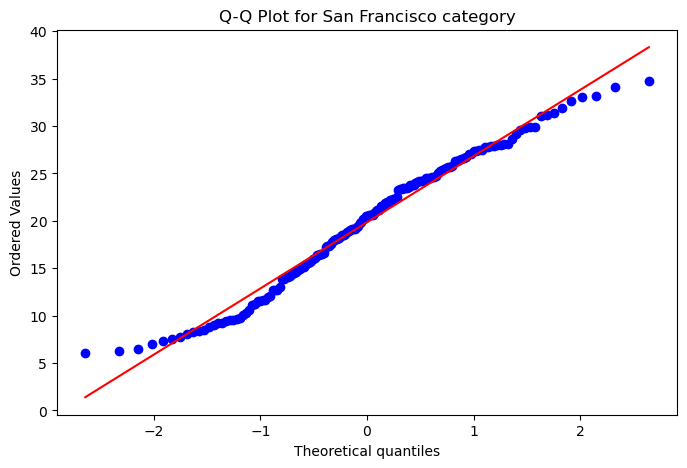

Shapiro-Wilk Test for San Francisco category:
Statistic = 0.9778, p-value = 0.0084
The data for 'San Francisco' does NOT appear to be normally distributed.

Descriptive Statistics for New York category:
Sample Size: 170
Mean: 25.6139
Median: 26.2136
Standard Deviation: 8.9758
Minimum: 6.3474
Maximum: 45.3779
Skewness: -0.1081
Kurtosis: -0.6957
----------------------------------------


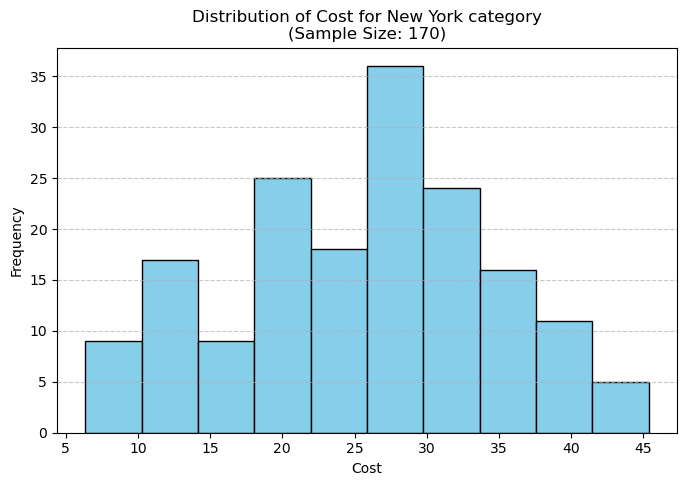

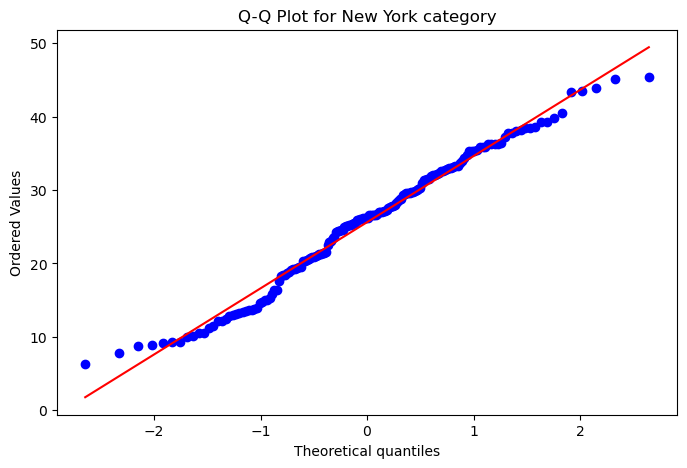

Shapiro-Wilk Test for New York category:
Statistic = 0.9824, p-value = 0.0296
The data for 'New York' does NOT appear to be normally distributed.

Descriptive Statistics for London category:
Sample Size: 193
Mean: 16.4090
Median: 16.7703
Standard Deviation: 5.2224
Minimum: 5.4087
Maximum: 26.4186
Skewness: -0.1088
Kurtosis: -0.9739
----------------------------------------


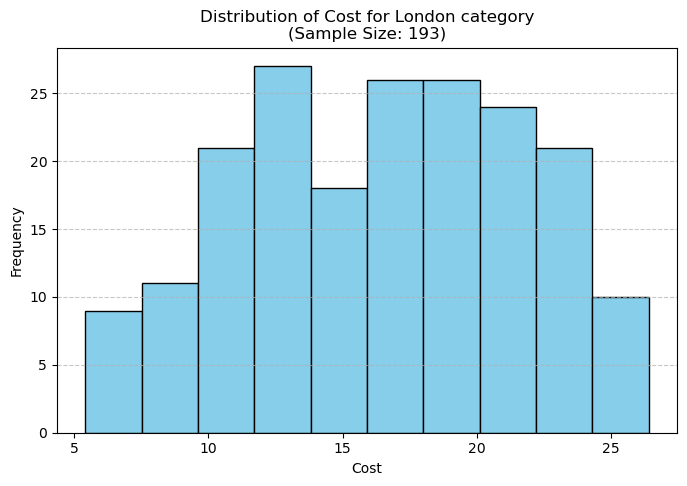

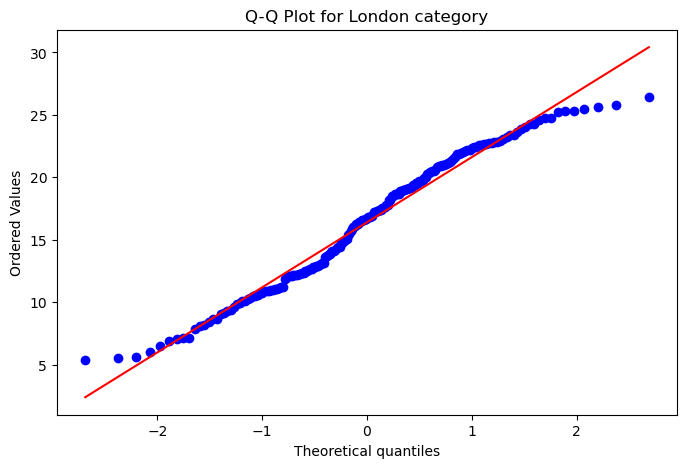

Shapiro-Wilk Test for London category:
Statistic = 0.9734, p-value = 0.0010
The data for 'London' does NOT appear to be normally distributed.

Descriptive Statistics for Chicago category:
Sample Size: 168
Mean: 13.7653
Median: 13.9102
Standard Deviation: 4.2751
Minimum: 5.1362
Maximum: 22.8196
Skewness: -0.0994
Kurtosis: -0.9074
----------------------------------------


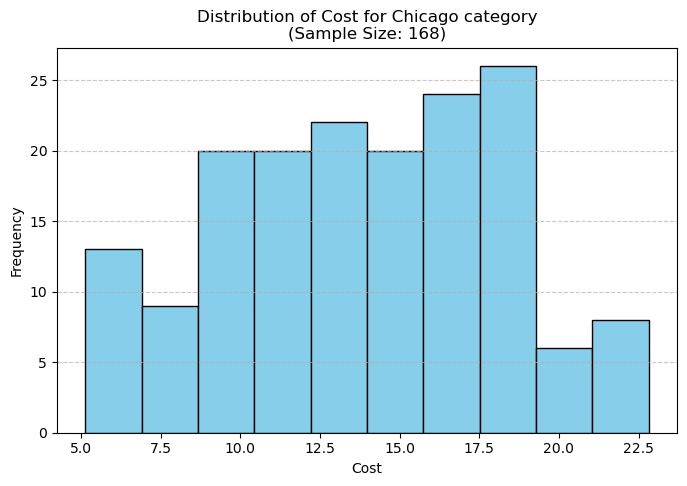

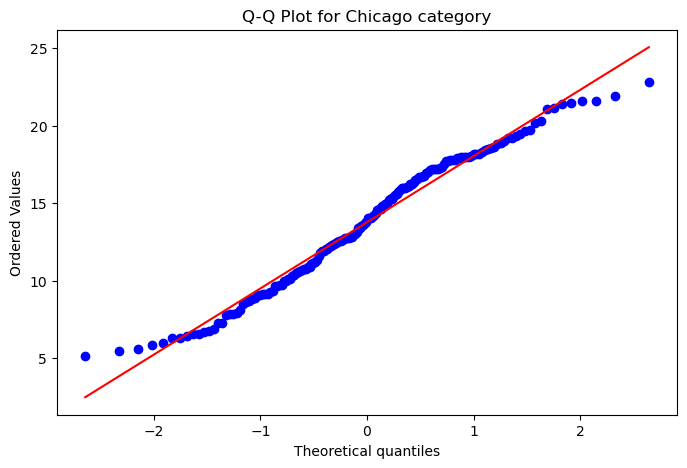

Shapiro-Wilk Test for Chicago category:
Statistic = 0.9765, p-value = 0.0059
The data for 'Chicago' does NOT appear to be normally distributed.

Descriptive Statistics for Dublin category:
Sample Size: 29
Mean: 215.1202
Median: 223.3261
Standard Deviation: 100.2869
Minimum: 24.5816
Maximum: 372.6510
Skewness: -0.2568
Kurtosis: -0.9125
----------------------------------------


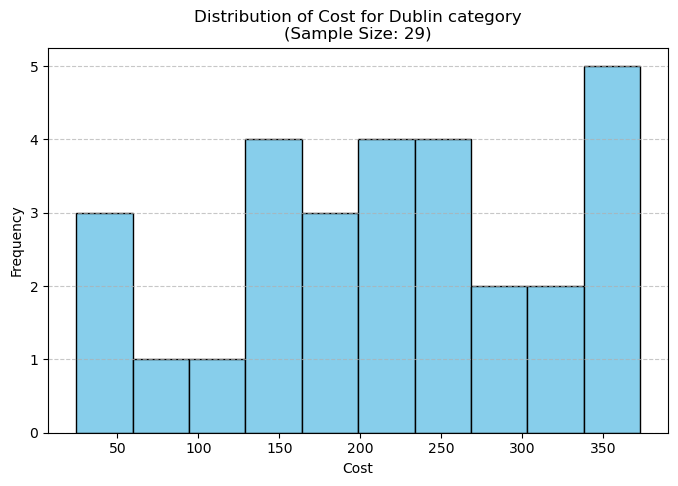

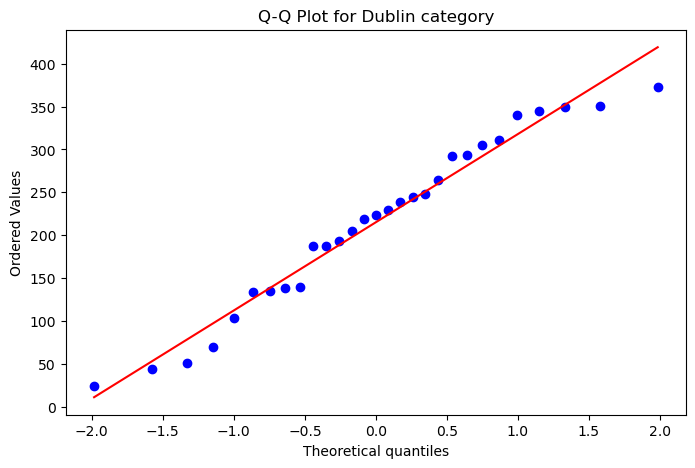

Shapiro-Wilk Test for Dublin category:
Statistic = 0.9591, p-value = 0.3114
The data for 'Dublin' appears to be normally distributed.



In [56]:
# Transforming 
box_cox(df1, 'Cost', 'City')

### Confidence Interval

Text(0, 0.5, 'Cost')

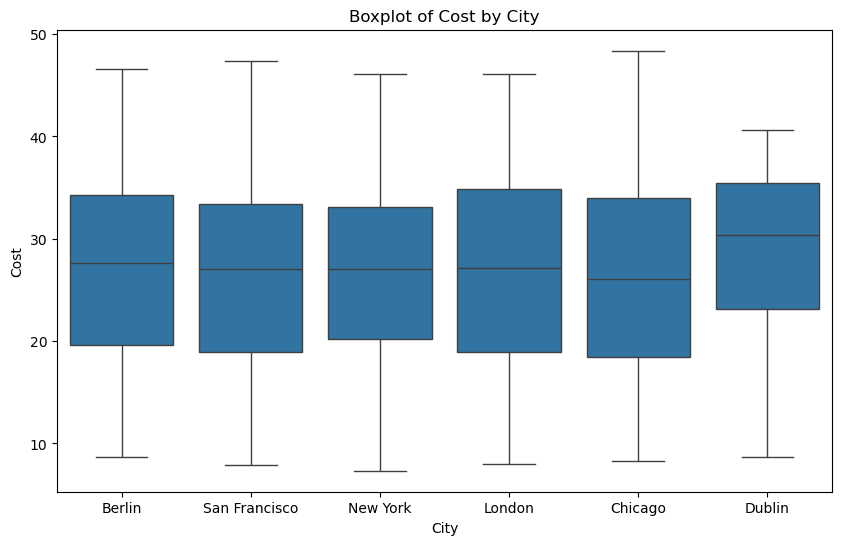

In [58]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='City', y='Cost', data=df1)
plt.title('Boxplot of Cost by City') 
plt.xlabel('City') 
plt.ylabel('Cost')

In [59]:
# Getting our confidence interval for cost in differents cities
confidence_interval(df1, 'Cost', 'City')

Berlin Category:
Sample Size (n): 172
Mean: 26.9084
Standard Deviation (ST): 9.4958
Standard Error (SE): 0.7240
95% Confidence Interval: (25.4893, 28.3275)

San Francisco Category:
Sample Size (n): 168
Mean: 26.3171
Standard Deviation (ST): 9.6002
Standard Error (SE): 0.7407
95% Confidence Interval: (24.8654, 27.7687)

New York Category:
Sample Size (n): 170
Mean: 26.4811
Standard Deviation (ST): 8.9153
Standard Error (SE): 0.6838
95% Confidence Interval: (25.1409, 27.8212)

London Category:
Sample Size (n): 193
Mean: 26.8391
Standard Deviation (ST): 9.5716
Standard Error (SE): 0.6890
95% Confidence Interval: (25.4887, 28.1894)

Chicago Category:
Sample Size (n): 168
Mean: 26.2440
Standard Deviation (ST): 9.6840
Standard Error (SE): 0.7471
95% Confidence Interval: (24.7797, 27.7084)

Dublin Category:
Sample Size (n): 29
Mean: 28.7390
Standard Deviation (ST): 8.7701
Standard Error (SE): 1.6286
95% Confidence Interval: (25.5470, 31.9309)



### T-test for Berlin vs New York

In [61]:
# Getting our t-test for mean of costs between Berlin and New York
t_test(df1, 'Cost', 'City', 'Berlin','New York')

T-Test Results for 'Berlin' vs. 'New York':
T-statistic: 0.4291
P-value: 0.6681
Fail to reject the null hypothesis: No significant difference between the means of 'Berlin' and 'New York'.
----------------------------------------


### T-test for Berlin vs London

In [63]:
# Getting our t-test for mean of costs between Berlin and London
t_test(df1, 'Cost', 'City', 'Berlin','London')

T-Test Results for 'Berlin' vs. 'London':
T-statistic: 0.0693
P-value: 0.9448
Fail to reject the null hypothesis: No significant difference between the means of 'Berlin' and 'London'.
----------------------------------------


## Covariance Calculation

In [65]:
#Removing categorical variables
cov_matrix = df1.drop(columns=["City","Bike Model","Weather Condition","Rider Satisfaction"]).cov()

# Result formatting 
pd.set_option("display.float_format","{:.0f}".format)

#Display results
cov_matrix

Rider Age  Duration  Distance  Cost
Rider Age        151        -4         1     2
Duration          -4      1149        -5   289
Distance           1        -5       125    -4
Cost               2       289        -4    89

Duration and Cost have a big relation

## Correlation Calculation

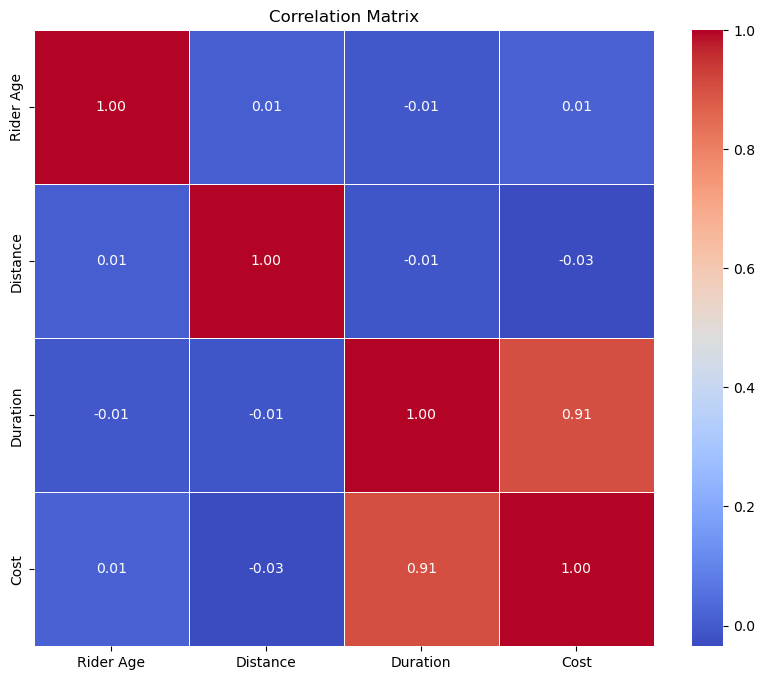

In [68]:
#Removing categorical variables
correlation_matrix = df1[["Rider Age","Distance","Duration","Cost"]].corr()

# Set the figure size
plt.figure(figsize=(10, 8))  # Ensures the heatmap has appropriate dimensions

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title to the plot
plt.title("Correlation Matrix")

# Display the heatmap
plt.show()

### Plotting variables

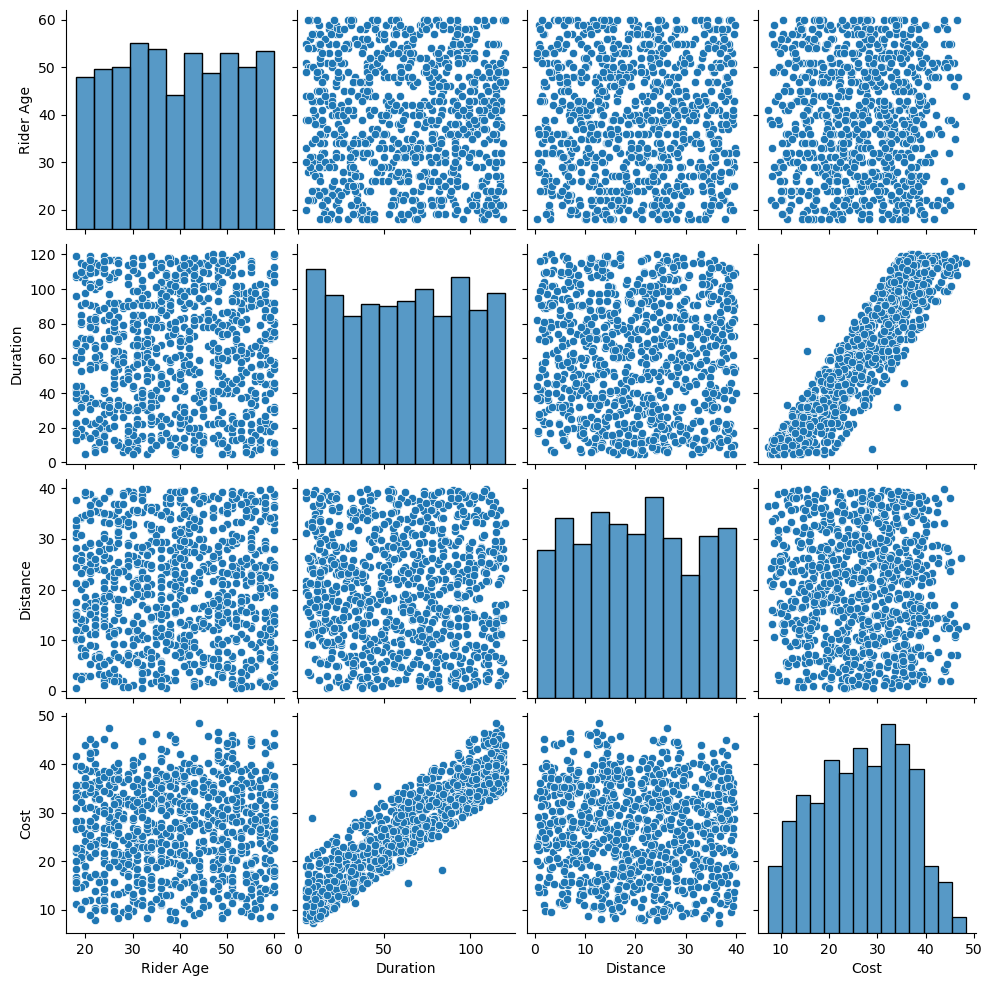

In [70]:
sns.pairplot(df1)
plt.show()

There appears to be a positive relationship between the variables Duration and Cost, as the dots form an ascending pattern. This indicates that as duration increases, so does cost. However, the dispersion is not perfectly adjusted, suggesting that the relationship is not completely linear or that there are additional factors affecting cost.

There is some dispersion around the overall pattern. This indicates that cost is not solely explained by duration and that there may be noise or effects of other variables in the data.

## Regression Model

In [73]:
model = LinearRegression()

In [74]:
#Independent variable
X = df1[["Duration"]]
# Dependent Variable
y = df1[["Cost"]]

#Fitting the model
model.fit(X,y)


LinearRegression()

In [75]:
#slope is close to 0, which is almost a flat line

Intercept: [10.99465678]
Coefficients: [[0.25172704]]
R2 0.8194695066423494
MSE 16.015863838362467


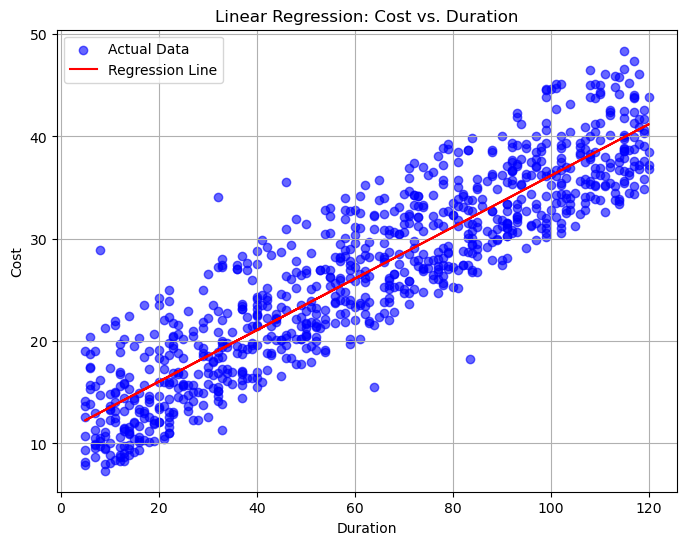

In [76]:
# Make predictions
y_pred = model.predict(X)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_) # degree of slope
print("R2", r2_score(y,y_pred)) #how good the model is
print("MSE", mean_squared_error(y,y_pred))
# How explainable the model is
# Plot the data points and regression line
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Actual Data', alpha=0.6)  # Scatter plot of actual data
plt.plot(X, y_pred, color='red', label='Regression Line')        # Regression line
plt.xlabel("Duration")
plt.ylabel("Cost")
plt.title("Linear Regression: Cost vs. Duration")
plt.legend()
plt.grid(True)
plt.show()

# Data Preparation Part II

## Creation of new variables

- Age Category (Young, Adult, Senior)
  
- Speed (km/h)
  
- Speed_Category (Fast, Moderate, Slow)
  
- Cost_per_km
  
- Cost_per_minute

In [79]:
def age_category(age):
    if age <= 30:
        return 'Young'
    elif age <= 50:
        return 'Adult'
    else:
        return 'Senior'

df['Age Category'] = df['Rider Age'].apply(age_category)

df['Speed (km/h)'] = df['Distance'].astype(float) / (df['Duration'].astype(float) / 60)

def speed_category(row):
    if row['Bike Model'] == 'Electric' and row['Speed (km/h)'] > 40:
        return 'Fast'
    elif row['Speed (km/h)'] > 20:
        return 'Moderate'
    else:
        return 'Slow'

df['Speed_Category'] = df.apply(speed_category, axis=1)


In [80]:
# Add cost per kilometer
df['Cost_per_km'] = df['Cost'] / df['Distance']

#Add cost per minute
df['Cost_per_minute'] = df['Cost'] / df['Duration']

In [81]:
df.head()

City Weather Condition  Rider Age Bike Model  Duration  Distance  \
0         Berlin             Rainy         53   Standard        62         2   
1  San Francisco            Cloudy         39   Standard         5        22   
2         Berlin             Sunny         43   Electric       106        28   
3  San Francisco            Cloudy         24   Standard       119         6   
4       New York             Sunny         24   Mountain        11        26   

  Rider Satisfaction  Cost Age Category  Speed (km/h) Speed_Category  \
0               High    23       Senior             2           Slow   
1             Medium     8        Adult           260       Moderate   
2               High    39        Adult            16           Slow   
3                Low    38        Young             3           Slow   
4                Low    13        Young           140       Moderate   

   Cost_per_km  Cost_per_minute  
0           10                0  
1            0                2  
2            1                0  
3            7                0  
4            1                1

## Encoding

- Create dummies for categorical variables which do not follow ordinality
  
- Apply LabelEncoder for categorical variables which follow ordinality

In [83]:
def create_dummies(df, column_name, drop_original=True, drop_first=False):
    """
    Creates dummy variables for a specified column and optionally removes the original column.

    Parameters:
    - df: pd.DataFrame, The DataFrame to process.
    - column_name: str, The name of the column to create dummy variables for.
    - drop_original: bool, Whether to drop the original column (default is True).
    - drop_first: bool, Whether to drop the first dummy column to avoid multicollinearity (default is False).

    Returns:
    - pd.DataFrame: DataFrame with the dummy variables added and the original column optionally removed.
    """
    # Create dummy variables, drop the first to avoid multicollinearity
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=drop_first)
    
    # Convert dummies to float (optional, as pd.get_dummies returns integers already)
    dummies = dummies.astype(float)
    
    # Add dummy variables to the original DataFrame
    df = pd.concat([df, dummies], axis=1)

    # Optionally drop the original column
    if drop_original:
        df = df.drop(columns=[column_name])

    # Return the updated DataFrame
    return df

In [84]:
#Creating Dummies values for City
df = create_dummies(df,"City", drop_original=True, drop_first=False)
#Creating Dummies values for Bike Model, weather condition, age category, speed_category
df = create_dummies(df,"Bike Model", drop_original=True, drop_first=False)
df = create_dummies(df,"Weather Condition", drop_original=True, drop_first=False)
df = create_dummies(df,"Age Category", drop_original=True, drop_first=False)
df = create_dummies(df,"Speed_Category", drop_original=True, drop_first=False)

In [85]:
def check_speed(row):
    if row['Bike Model_Electric'] == 1 and row['Speed (km/h)'] > 50:
        return 'Anomalous'
    elif row['Bike Model_Standard'] == 1 and row['Speed (km/h)'] > 30:
        return 'Anomalous'
    elif row['Bike Model_Mountain'] == 1 and row['Speed (km/h)'] > 35:
        return 'Anomalous'
    return 'Normal'

# Ajustar duración basada en velocidad esperada
def fix_duration(row):
    if row['Speed_Check'] == 'Anomalous':
        # Asumir una velocidad máxima razonable para el tipo de bicicleta
        if row['Bike Model_Electric'] == 1:
            speed = 50  # km/h
        elif row['Bike Model_Standard'] == 1:
            speed = 30  # km/h
        else:
            speed = 35  # km/h (Mountain)

        # Recalcular la duración
        return (row['Distance'] / speed) * 60
    return row['Duration'].astype(float)


In [86]:
df.head()

Rider Age  Duration  Distance Rider Satisfaction  Cost  Speed (km/h)  \
0         53        62         2               High    23             2   
1         39         5        22             Medium     8           260   
2         43       106        28               High    39            16   
3         24       119         6                Low    38             3   
4         24        11        26                Low    13           140   

   Cost_per_km  Cost_per_minute  City_Berlin  City_Chicago  ...  \
0           10                0            1             0  ...   
1            0                2            0             0  ...   
2            1                0            1             0  ...   
3            7                0            0             0  ...   
4            1                1            0             0  ...   

   Weather Condition_Cloudy  Weather Condition_Rainy  Weather Condition_Snowy  \
0                         0                        1                        0   
1                         1                        0                        0   
2                         0                        0                        0   
3                         1                        0                        0   
4                         0                        0                        0   

   Weather Condition_Sunny  Age Category_Adult  Age Category_Senior  \
0                        0                   0                    1   
1                        0                   1                    0   
2                        1                   1                    0   
3                        0                   0                    0   
4                        1                   0                    0   

   Age Category_Young  Speed_Category_Fast  Speed_Category_Moderate  \
0                   0                    0                        0   
1                   0                    0                        1   
2                   0                    0                        0   
3                   1                    0                        0   
4                   1                    0                        1   

   Speed_Category_Slow  
0                    1  
1                    0  
2                    1  
3                    1  
4                    0  

[5 rows x 27 columns]

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rider Age                 900 non-null    float64
 1   Duration                  900 non-null    float64
 2   Distance                  900 non-null    float64
 3   Rider Satisfaction        900 non-null    object 
 4   Cost                      900 non-null    float64
 5   Speed (km/h)              900 non-null    float64
 6   Cost_per_km               900 non-null    float64
 7   Cost_per_minute           900 non-null    float64
 8   City_Berlin               900 non-null    float64
 9   City_Chicago              900 non-null    float64
 10  City_Dublin               900 non-null    float64
 11  City_London               900 non-null    float64
 12  City_New York             900 non-null    float64
 13  City_San Francisco        900 non-null    float64
 14  Bike Model

In [88]:
# Instancing label encoder
label_encoder = LabelEncoder()

# Apply the encoder to the specified column
df["Rider Satisfaction"] = label_encoder.fit_transform(df["Rider Satisfaction"])

In [89]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.head()

Rider Age  Duration  Distance  Rider Satisfaction  Cost  Speed (km/h)  \
0      53.00     62.00      2.25                   0 22.63          2.18   
1      39.00      5.00     21.67                   2  7.87        260.04   
2      43.00    106.00     28.40                   0 39.40         16.08   
3      24.00    119.00      5.66                   1 37.63          2.85   
4      24.00     11.00     25.74                   1 13.12        140.40   

   Cost_per_km  Cost_per_minute  City_Berlin  City_Chicago  ...  \
0        10.06             0.36         1.00          0.00  ...   
1         0.36             1.57         0.00          0.00  ...   
2         1.39             0.37         1.00          0.00  ...   
3         6.65             0.32         0.00          0.00  ...   
4         0.51             1.19         0.00          0.00  ...   

   Weather Condition_Cloudy  Weather Condition_Rainy  Weather Condition_Snowy  \
0                      0.00                     1.00                     0.00   
1                      1.00                     0.00                     0.00   
2                      0.00                     0.00                     0.00   
3                      1.00                     0.00                     0.00   
4                      0.00                     0.00                     0.00   

   Weather Condition_Sunny  Age Category_Adult  Age Category_Senior  \
0                     0.00                0.00                 1.00   
1                     0.00                1.00                 0.00   
2                     1.00                1.00                 0.00   
3                     0.00                0.00                 0.00   
4                     1.00                0.00                 0.00   

   Age Category_Young  Speed_Category_Fast  Speed_Category_Moderate  \
0                0.00                 0.00                     0.00   
1                0.00                 0.00                     1.00   
2                0.00                 0.00                     0.00   
3                1.00                 0.00                     0.00   
4                1.00                 0.00                     1.00   

   Speed_Category_Slow  
0                 1.00  
1                 0.00  
2                 1.00  
3                 1.00  
4                 0.00  

[5 rows x 27 columns]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rider Age                 900 non-null    float64
 1   Duration                  900 non-null    float64
 2   Distance                  900 non-null    float64
 3   Rider Satisfaction        900 non-null    int32  
 4   Cost                      900 non-null    float64
 5   Speed (km/h)              900 non-null    float64
 6   Cost_per_km               900 non-null    float64
 7   Cost_per_minute           900 non-null    float64
 8   City_Berlin               900 non-null    float64
 9   City_Chicago              900 non-null    float64
 10  City_Dublin               900 non-null    float64
 11  City_London               900 non-null    float64
 12  City_New York             900 non-null    float64
 13  City_San Francisco        900 non-null    float64
 14  Bike Model

## Correlation Matrix

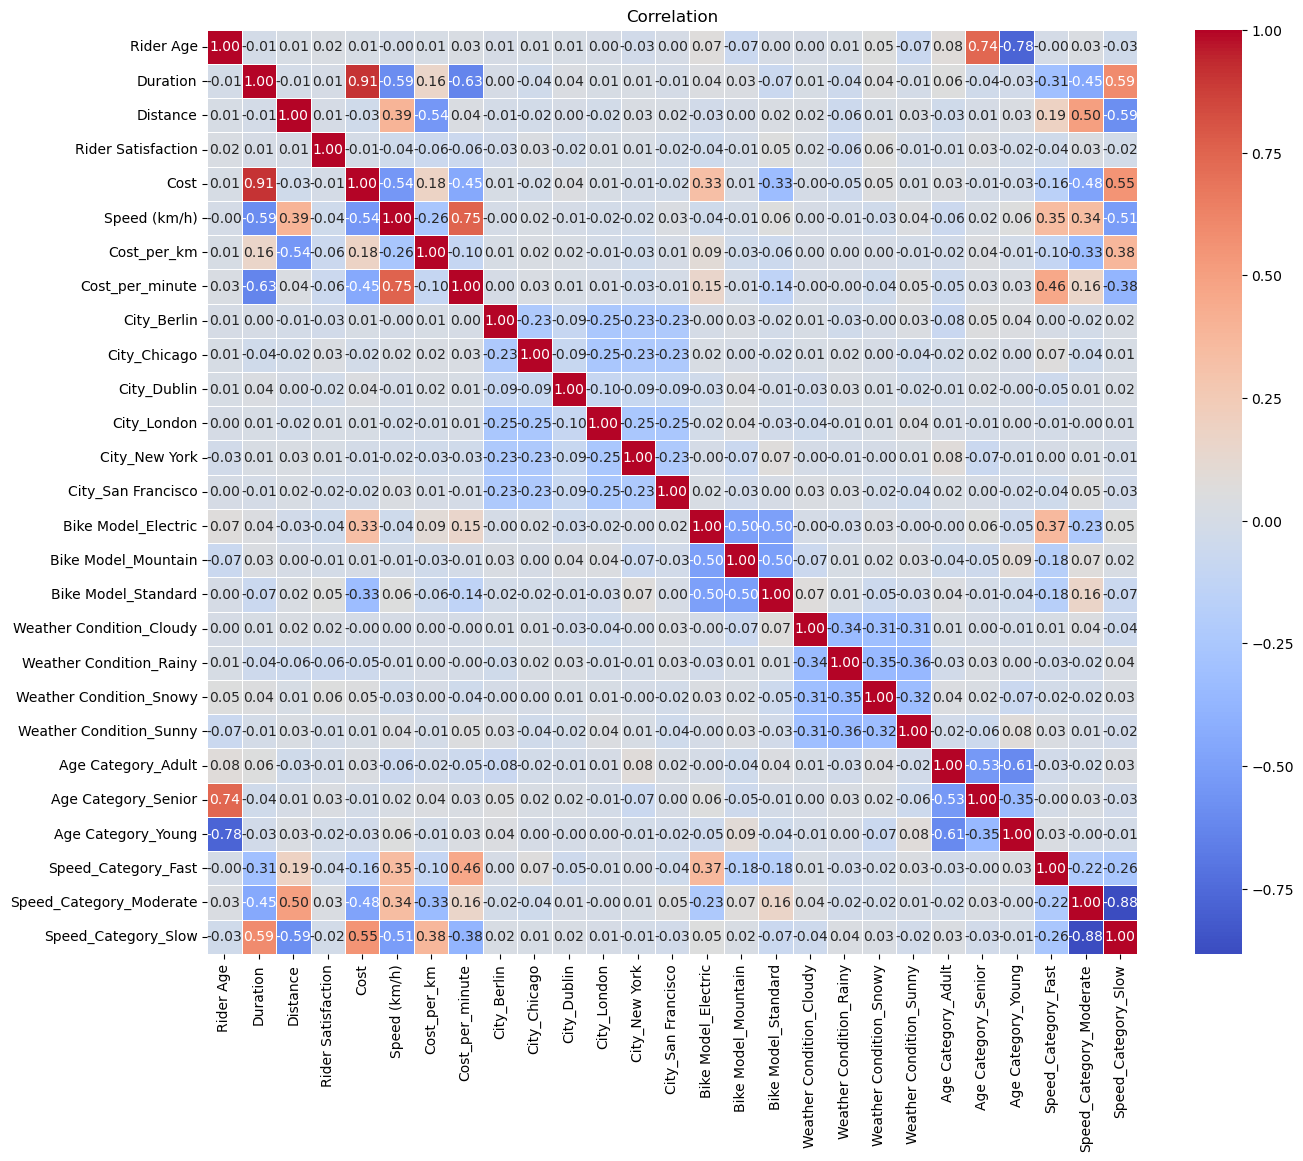

In [92]:
correlation_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(15, 12))  # Ensures the heatmap has appropriate dimensions

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title to the plot
plt.title("Correlation")  # Title of the heatmap

# Display the heatmap
plt.show()

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_text
from itertools import combinations

def decision_tree_classifier(X, y, test_size=0.3, random_state=42, max_depth=None):
    """
    Entrena un clasificador de árbol de decisión y calcula la precisión.

    Parámetros:
    - X: DataFrame con las características.
    - y: Variable objetivo.
    - test_size: Proporción del conjunto de prueba.
    - random_state: Semilla para la reproducibilidad.
    - max_depth: Profundidad máxima del árbol.

    Retorna:
    - Precisión del modelo en el conjunto de prueba.
    """
    try:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Train the Decision Tree model
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
        model.fit(X_train, y_train)

        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

    except Exception as e:
        print(f"Error: {e}")
        return 0.0  # Default value when something goes wrong


In [94]:
"""
def best_feature_combinations(X, y, test_size=0.3, random_state=42, max_features=5):
    
    # Find the best feature combinations based on accuracy.

    # Parameters:
    # - X: DataFrame with the features.
    # - y: Target variable.
    # - test_size: Proportion of the test set.
    # - random_state: Seed for reproducibility.
    # - max_features: Maximum number of features to combine.
    
    # Returns:
    # - A list with the 5 best feature combinations and their accuracy.
    
    results = []
    
    # Generate all possible combinations of features
    for r in range(1, max_features + 1):
        for combo in combinations(X.columns, r):
            # Create a subset of features
            X_subset = X[list(combo)]
            # Calculate accuracy using decision_tree_classifier
            accuracy = decision_tree_classifier(X_subset, y, test_size, random_state)
            # Store the combination and its accuracy
            results.append((combo, accuracy))
    
    # Sort the combinations by accuracy in descending order
    results = sorted(results, key=lambda x: x[1], reverse=True)
    
    # Return the 5 best combinations
    return results[:5]


best_combinations = best_feature_combinations(df.drop(columns="Rider Satisfaction"), df["Rider Satisfaction"])
print("\nTop 5 Feature Combinations:")
for combo, acc in best_combinations:
    print(f"Features: {combo}, Accuracy: {acc:.4f}")"""

'\ndef best_feature_combinations(X, y, test_size=0.3, random_state=42, max_features=5):\n    \n    # Find the best feature combinations based on accuracy.\n\n    # Parameters:\n    # - X: DataFrame with the features.\n    # - y: Target variable.\n    # - test_size: Proportion of the test set.\n    # - random_state: Seed for reproducibility.\n    # - max_features: Maximum number of features to combine.\n    \n    # Returns:\n    # - A list with the 5 best feature combinations and their accuracy.\n    \n    results = []\n    \n    # Generate all possible combinations of features\n    for r in range(1, max_features + 1):\n        for combo in combinations(X.columns, r):\n            # Create a subset of features\n            X_subset = X[list(combo)]\n            # Calculate accuracy using decision_tree_classifier\n            accuracy = decision_tree_classifier(X_subset, y, test_size, random_state)\n            # Store the combination and its accuracy\n            results.append((combo, 

In [95]:
# Using our classifier model with the dataframe without scaling 
decision_tree_classifier(df.drop(columns="Rider Satisfaction"), df["Rider Satisfaction"])

0.34814814814814815

In [96]:
df.head(1)

Rider Age  Duration  Distance  Rider Satisfaction  Cost  Speed (km/h)  \
0      53.00     62.00      2.25                   0 22.63          2.18   

   Cost_per_km  Cost_per_minute  City_Berlin  City_Chicago  ...  \
0        10.06             0.36         1.00          0.00  ...   

   Weather Condition_Cloudy  Weather Condition_Rainy  Weather Condition_Snowy  \
0                      0.00                     1.00                     0.00   

   Weather Condition_Sunny  Age Category_Adult  Age Category_Senior  \
0                     0.00                0.00                 1.00   

   Age Category_Young  Speed_Category_Fast  Speed_Category_Moderate  \
0                0.00                 0.00                     0.00   

   Speed_Category_Slow  
0                 1.00  

[1 rows x 27 columns]

# Pre-Processing Part I

## Scaler Functions

In [99]:
def is_boolean_column(series):
    """
    Determines if a column is boolean-like (contains only 0/1 or True/False values).
    Args:
        series (pd.Series): The column to evaluate.
    Returns:
        bool: True if the column is boolean-like, False otherwise.
    """
    return series.dropna().isin([0, 1, True, False]).all()

def apply_standard_scaler(df, columns=None):
    """
    Scales the dataset using StandardScaler, with an option to specify target columns.
    Args:
        df (pd.DataFrame): The dataset to scale.
        columns (list, optional): Specific columns to scale. If None, non-boolean columns will be scaled.
    Returns:
        pd.DataFrame: The dataset scaled with mean 0 and standard deviation 1.
    """
    # Determine columns to scale
    if columns is None:
        columns = [col for col in df.columns if not is_boolean_column(df[col])]
    
    # Apply scaling only to the selected columns
    scaler = StandardScaler()
    scaled_df = df.copy()
    scaled_df[columns] = scaler.fit_transform(df[columns])
    
    return scaled_df

def apply_minmax_scaler(df, columns=None):
    """
    Scales the dataset using MinMaxScaler, with an option to specify target columns.
    Args:
        df (pd.DataFrame): The dataset to scale.
        columns (list, optional): Specific columns to scale. If None, non-boolean columns will be scaled.
    Returns:
        pd.DataFrame: The dataset scaled to the range [0, 1].
    """
    # Determine columns to scale
    if columns is None:
        columns = [col for col in df.columns if not is_boolean_column(df[col])]
    
    # Apply scaling only to the selected columns
    scaler = MinMaxScaler()
    scaled_df = df.copy()
    scaled_df[columns] = scaler.fit_transform(df[columns])
    
    return scaled_df

### Applying the scalers to the columns

In [101]:
scaled_df_standard = apply_standard_scaler(df.drop(columns="Rider Satisfaction"),columns=["Rider Age","Distance","Duration","Cost","Cost_per_minute","Cost_per_km","Speed (km/h)"])
scaled_df_minMax = apply_standard_scaler(df.drop(columns="Rider Satisfaction"),columns=["Rider Age","Distance","Duration","Cost","Cost_per_minute","Cost_per_km","Speed (km/h)"])

### Using our classifier model with each scaled dataframe

In [103]:
decision_tree_classifier(scaled_df_standard, df["Rider Satisfaction"])


0.34814814814814815

In [104]:
decision_tree_classifier(scaled_df_minMax, df["Rider Satisfaction"])

0.34814814814814815

## Feature Importance

In [106]:
# Separate features (X) and target variable (y)
X = df.drop(columns="Rider Satisfaction")  # Drop the target column to get feature matrix
y = df["Rider Satisfaction"]  # Target column

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100)  # Initialize Random Forest with 100 trees
rf.fit(X, y)  # Train the model using the features (X) and target (y)

# Get feature importance scores
importances = rf.feature_importances_  # Retrieve the importance of each feature

# Create a DataFrame to view features and their importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,        # Feature names
    'Importance': importances    # Corresponding importance scores
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importances)

# Select the most important features
# For example, select the top 2 most important features
selected_features = feature_importances['Feature'][:2]  # Retrieve the names of the top 2 features
print(f"Selected features: {selected_features}")


                     Feature  Importance
3                       Cost        0.11
6            Cost_per_minute        0.11
2                   Distance        0.11
5                Cost_per_km        0.11
4               Speed (km/h)        0.11
0                  Rider Age        0.10
1                   Duration        0.10
17   Weather Condition_Rainy        0.02
16  Weather Condition_Cloudy        0.02
19   Weather Condition_Sunny        0.02
10               City_London        0.02
11             City_New York        0.02
18   Weather Condition_Snowy        0.02
7                City_Berlin        0.02
12        City_San Francisco        0.02
8               City_Chicago        0.02
20        Age Category_Adult        0.02
14       Bike Model_Mountain        0.01
15       Bike Model_Standard        0.01
13       Bike Model_Electric        0.01
22        Age Category_Young        0.01
21       Age Category_Senior        0.01
24   Speed_Category_Moderate        0.01
25       Speed_C

# Pre-Processing Part II

## Reducer Functions (PCA-LDA)

In [109]:
def pca_transformation(df_scaled):
    # Initialising PCA without reducing the number of components yet 
    pca = PCA()
    
    #Adjusting PCA to standarized data
    pca.fit(df_scaled)
    
    # Variance explained by each component
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # Calculating cumulative variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Finding the number of components which retain the 99.5% of variance
    components_needed = np.argmax(cumulative_variance >= 0.995) + 1
    print(f"Number of components needed to retain 99.5% variance: {components_needed}")
    
    # Implementing PCA with the optimun number of components
    pca_optimal = PCA(n_components=components_needed)
    df_reduced = pca_optimal.fit_transform(df_scaled)
    
    # Result of dimentionally data reducted
    print(f"Shape of the data after PCA reduction: {df_reduced.shape}")
    
    #Checking the different Principal components after applying PCA
    df_reduced_df = pd.DataFrame(df_reduced, columns=[f'PC{i+1}' for i in range(df_reduced.shape[1])])
    print(df_reduced_df)

    #Plotting how many features we need to retain the 99.5%
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.title('Cumulative variance by principal components')
    plt.xlabel('Number of principal components')
    plt.ylabel('Cumulative variance')
    plt.axhline(y=0.995, color='r', linestyle='-')
    plt.axvline(x=components_needed, color='g', linestyle='--')
    plt.grid(True)
    plt.show()

    return df_reduced

def lda_transformation(df_scaled, target):
    """
    Perform Linear Discriminant Analysis (LDA) on scaled data.

    Parameters:
        df_scaled (DataFrame): Scaled data excluding the target column.
        target (Series): Categorical target variable.

    Returns:
        df_reduced (DataFrame): Reduced data after applying LDA.
    """
    # Initialize the LDA model
    lda = LDA()

    # Fit the model to the data
    lda.fit(df_scaled, target)

    # Transform the data to reduce dimensionality
    df_reduced = lda.transform(df_scaled)

    # Calculate the variance explained by each linear discriminant
    explained_variance_ratio = lda.explained_variance_ratio_

    # Compute cumulative variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Determine the number of components needed to retain 99.5% of the variance (if applicable)
    components_needed = np.argmax(cumulative_variance >= 0.995) + 1 if len(cumulative_variance) > 1 else 1
    print(f"Number of components needed to retain 99.5% variance: {components_needed}")

    # Create a DataFrame with the transformed results
    df_reduced_df = pd.DataFrame(df_reduced[:, :components_needed],
                                 columns=[f'LD{i+1}' for i in range(components_needed)])

    print(f"Shape of the data after LDA reduction: {df_reduced_df.shape}")

    # Plot the cumulative variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.title('Cumulative variance by linear discriminants')
    plt.xlabel('Number of linear discriminants')
    plt.ylabel('Cumulative variance')
    plt.axhline(y=0.995, color='r', linestyle='-')
    plt.axvline(x=components_needed, color='g', linestyle='--')
    plt.grid(True)
    plt.show()

    return df_reduced_df

Number of components needed to retain 99.5% variance: 20
Shape of the data after PCA reduction: (900, 20)
      PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11  PC12  \
0   -1.06  2.08 -1.20 -0.86  0.30 -0.50  0.43  0.92  0.48 -0.15 -0.14 -0.29   
1    5.13  0.73 -0.05  1.15  0.32  1.39  1.19  0.82 -0.14  0.37  0.75  0.06   
2   -1.63 -1.28 -0.41  0.97 -0.22  0.48 -0.32 -0.01 -0.38 -0.73 -0.22 -0.58   
3   -2.44  0.55  1.44  0.37  0.10  0.06  0.53  1.16 -0.29  0.31  0.89  0.23   
4    3.37  0.16  1.52  0.48  0.20 -0.49  0.51 -0.39 -0.44 -0.53 -0.16 -0.44   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
895  0.38 -0.77 -1.50 -0.23  0.23 -0.67 -0.86  0.17  0.80 -0.25 -0.13 -0.18   
896  1.98  1.05 -0.53 -0.72 -0.62  0.17  0.14 -1.06 -0.32  0.02  0.86  0.96   
897  0.26  2.30 -0.61 -0.33 -0.64  0.14  0.27 -0.98 -0.37 -0.64  0.12 -0.37   
898 -2.93  2.00  1.87  1.12  1.20 -0.52  0.66 -0.41 -0.35 -0.47 -0.00 -0.34   
899  1.58  1.12  0.19 -1.

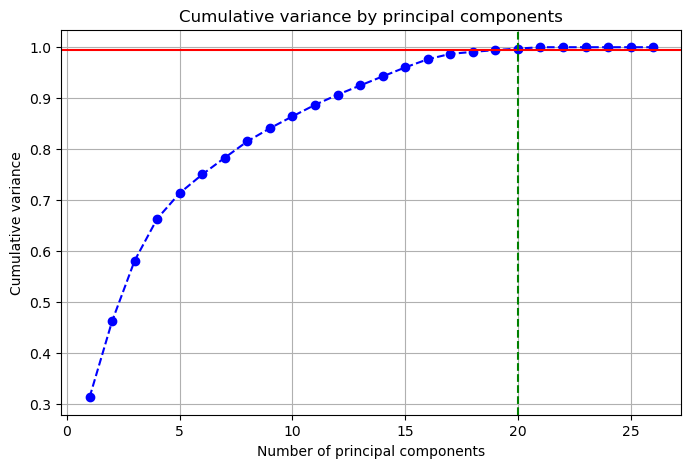

In [110]:
#Reducing scaled minmax dataset
test1 = pca_transformation(scaled_df_minMax)

In [111]:
# applying decision tree model to pca dataset
results = decision_tree_classifier(test1, df["Rider Satisfaction"])
print(results)

0.3592592592592593


Number of components needed to retain 99.5% variance: 2
Shape of the data after LDA reduction: (900, 2)


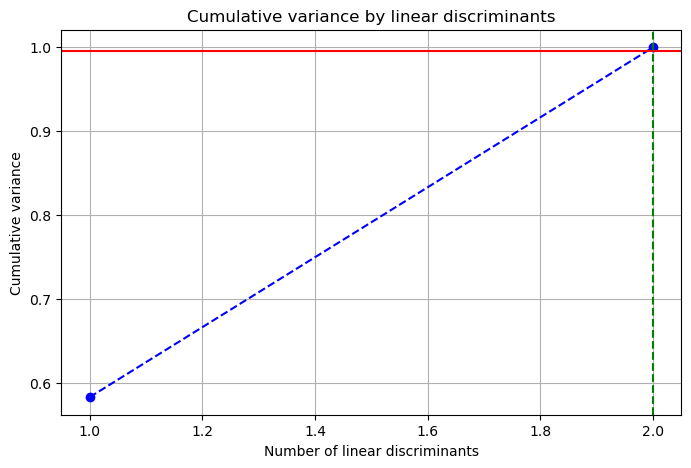

In [112]:
#Reducing scaled minmax dataset
test2 = lda_transformation(scaled_df_minMax,df["Rider Satisfaction"])

In [113]:
## applying decision tree model to LDA dataset
decision_tree_classifier(test2, df["Rider Satisfaction"])

0.34444444444444444

# Machine Learning Model

### Classifier Models for Rider Satisfaction

In [116]:
def classification_models(df_scaled, target, test):
    """
    Train and evaluate various classification models on the provided dataset.
    Includes confusion matrix heatmaps and a histogram of accuracies.

    Parameters:
        df_scaled (DataFrame): Scaled data excluding the target column.
        target (Series): Categorical target variable.

    Returns:
        results (DataFrame): Accuracy scores and key metrics from the classification report for each model.
    """
    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_scaled, target, test_size=test, random_state=42)

    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Machine': SVC(probability=True, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Artificial Neural Network': MLPClassifier(max_iter=500, random_state=42)
    }

    results = []

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Extract precision, recall, and F1-score for the main class (e.g., '0' or '1')
        precision = report['0']['precision']
        recall = report['0']['recall']
        f1_score = report['0']['f1-score']

        # Append results
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision (Class 0)': precision,
            'Recall (Class 0)': recall,
            'F1-Score (Class 0)': f1_score
        })

        print(f"{model_name} Accuracy: {accuracy:.5f}")

        # Generate and display the confusion matrix as a heatmap
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(target.unique()), yticklabels=sorted(target.unique()))
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plot histogram of accuracies
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
    plt.title('Model Performance Comparison')
    plt.xlabel('Accuracy')
    plt.ylabel('Model')
    plt.xlim(0, 1)  # Accuracy range between 0 and 1
    plt.show()

    return results_df



## Modelling with test size of 30%

Decision Tree Accuracy: 0.34815


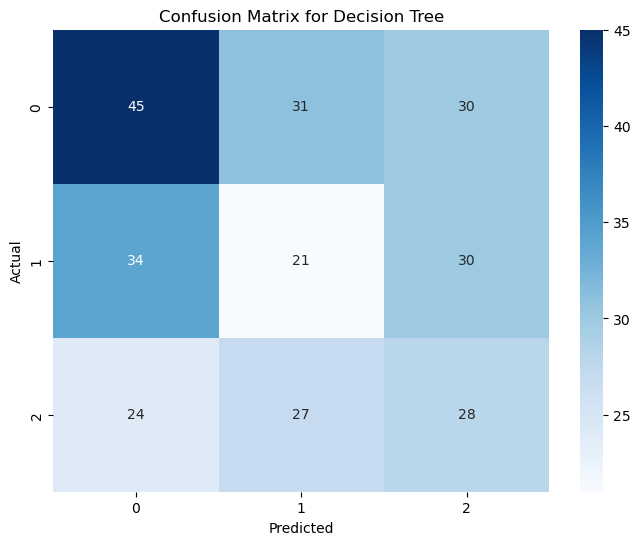

Random Forest Accuracy: 0.35926


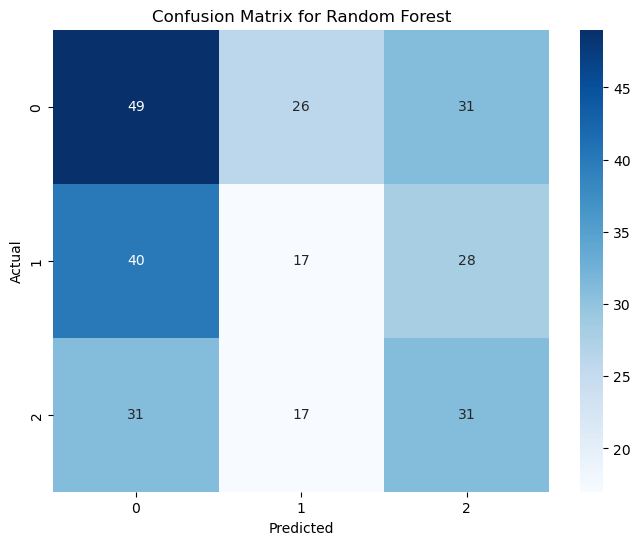

Support Vector Machine Accuracy: 0.34444


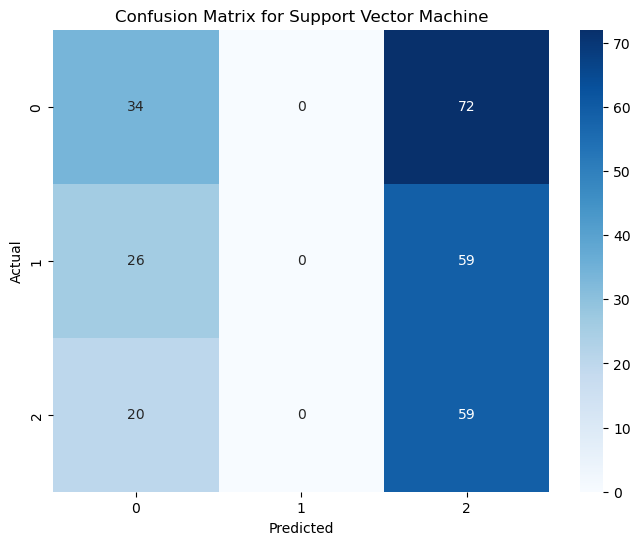

K-Nearest Neighbors Accuracy: 0.31852


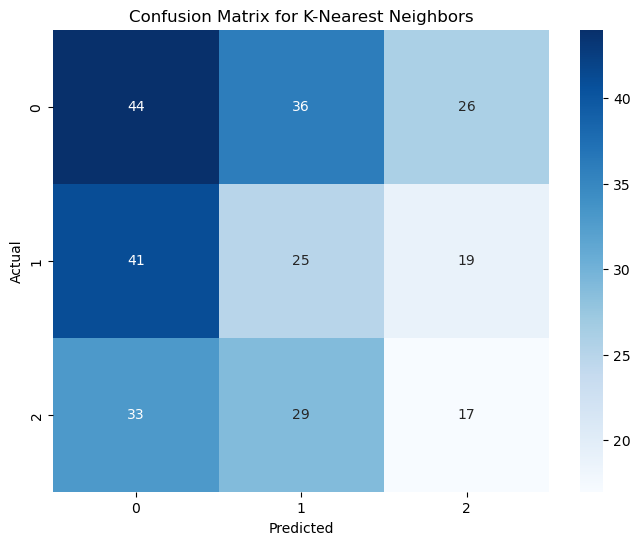

Artificial Neural Network Accuracy: 0.34444


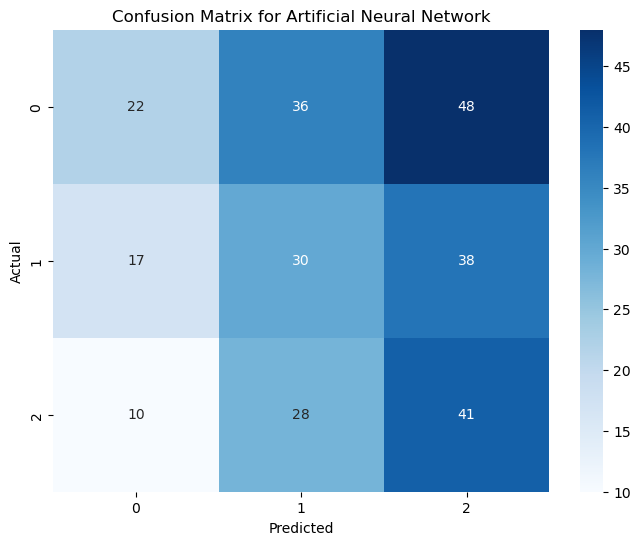

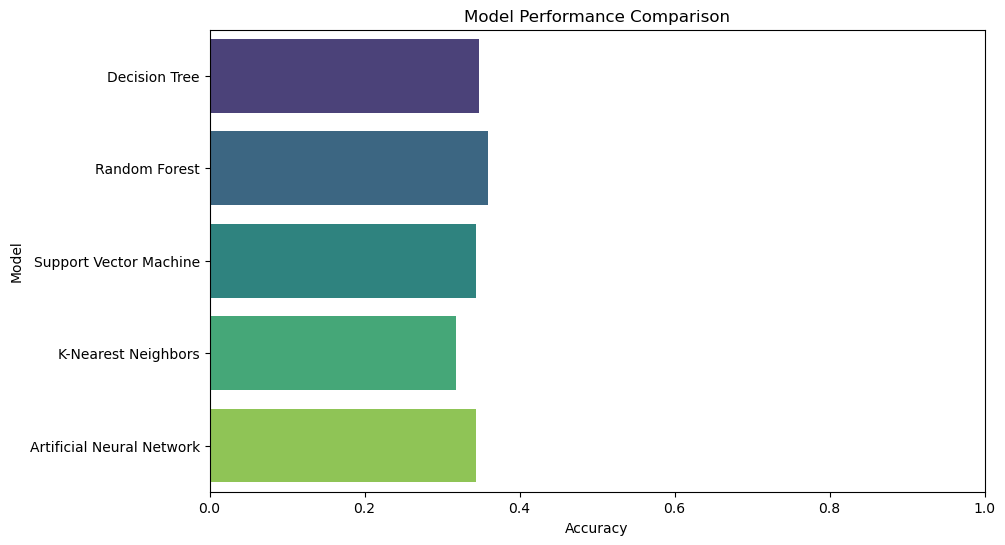

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.35                 0.44              0.42   
1              Random Forest      0.36                 0.41              0.46   
2     Support Vector Machine      0.34                 0.42              0.32   
3        K-Nearest Neighbors      0.32                 0.37              0.42   
4  Artificial Neural Network      0.34                 0.45              0.21   

   F1-Score (Class 0)  
0                0.43  
1                0.43  
2                0.37  
3                0.39  
4                0.28

In [118]:
#Classification Models before Scaling
classification_models(df.drop(columns="Rider Satisfaction"), df["Rider Satisfaction"],0.3)

Decision Tree Accuracy: 0.34815


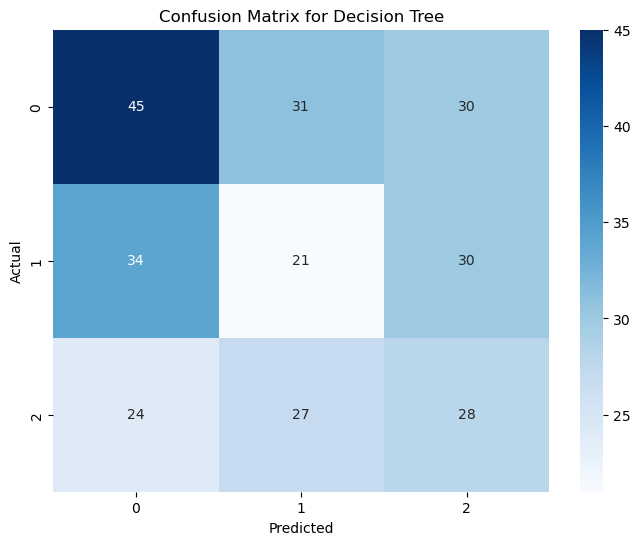

Random Forest Accuracy: 0.36667


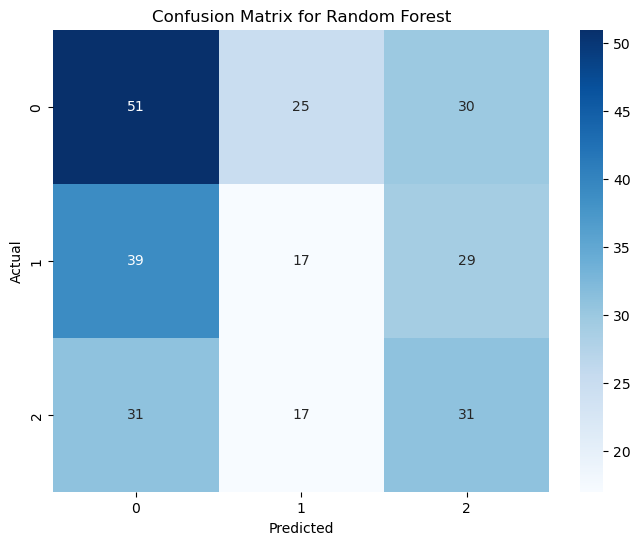

Support Vector Machine Accuracy: 0.36667


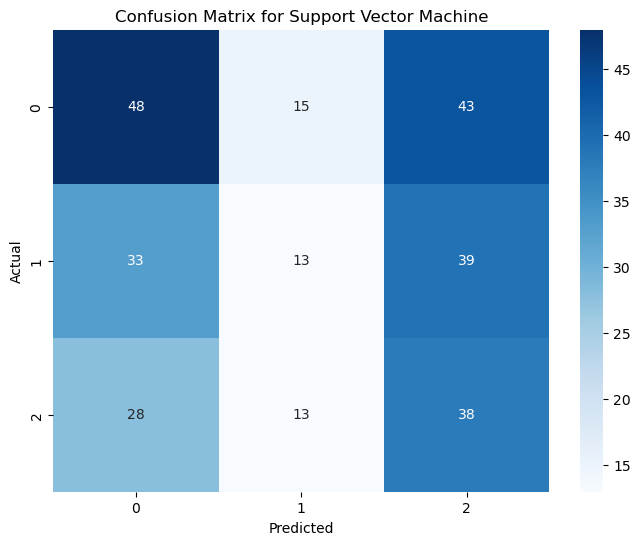

K-Nearest Neighbors Accuracy: 0.40741


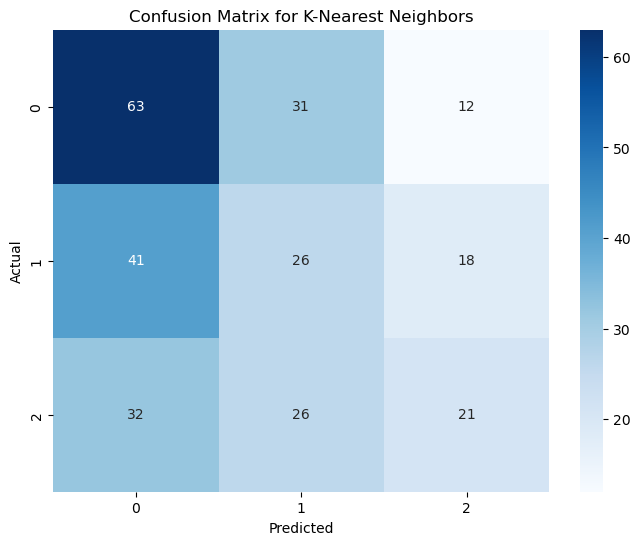

Artificial Neural Network Accuracy: 0.36296


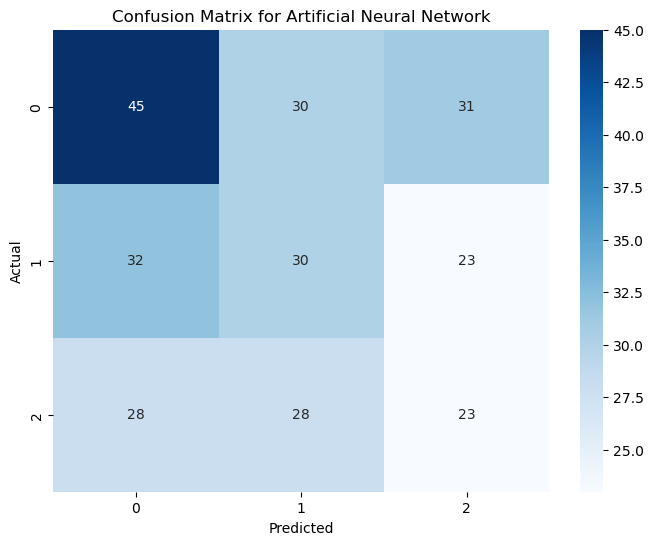

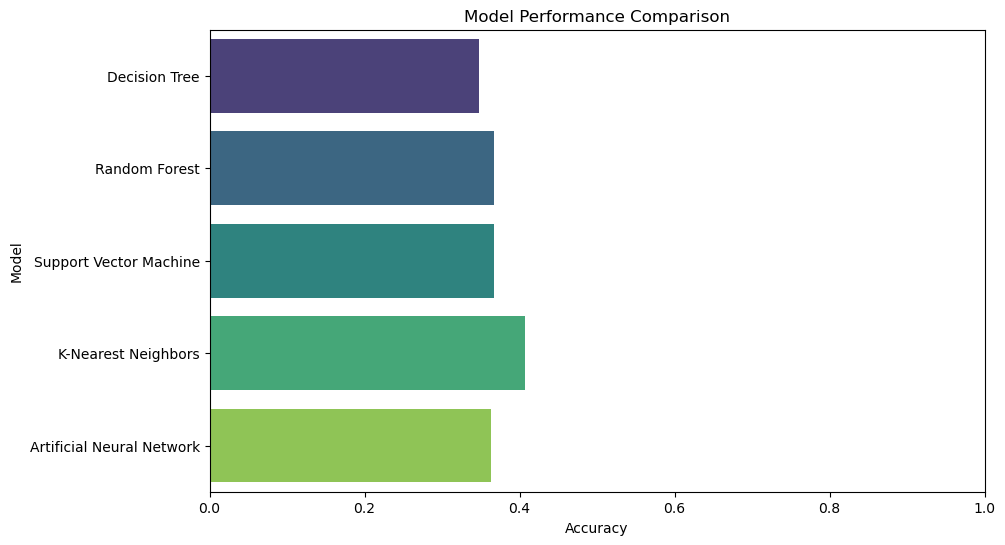

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.35                 0.44              0.42   
1              Random Forest      0.37                 0.42              0.48   
2     Support Vector Machine      0.37                 0.44              0.45   
3        K-Nearest Neighbors      0.41                 0.46              0.59   
4  Artificial Neural Network      0.36                 0.43              0.42   

   F1-Score (Class 0)  
0                0.43  
1                0.45  
2                0.45  
3                0.52  
4                0.43

In [119]:
##Classification Models after Scaling
classification_models(scaled_df_minMax, df["Rider Satisfaction"],0.3)

Decision Tree Accuracy: 0.35926


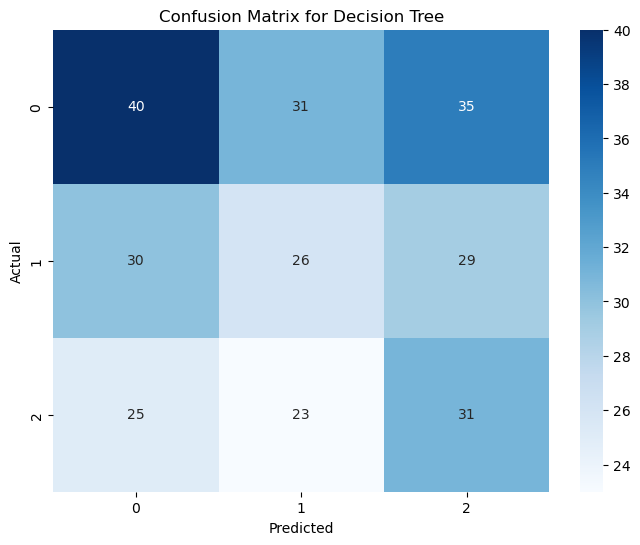

Random Forest Accuracy: 0.34074


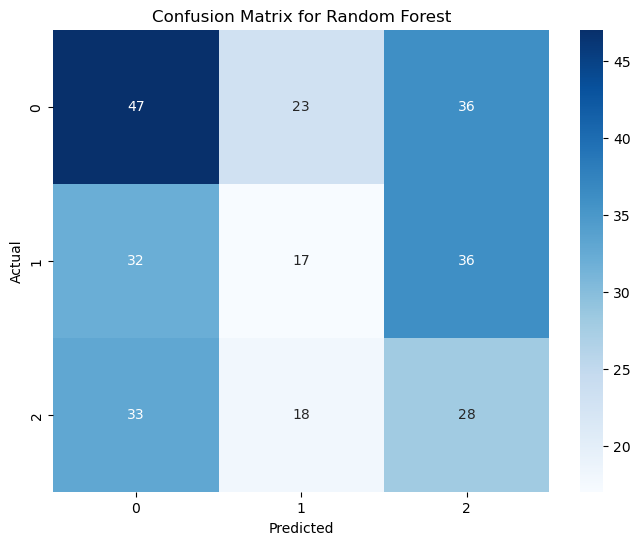

Support Vector Machine Accuracy: 0.35185


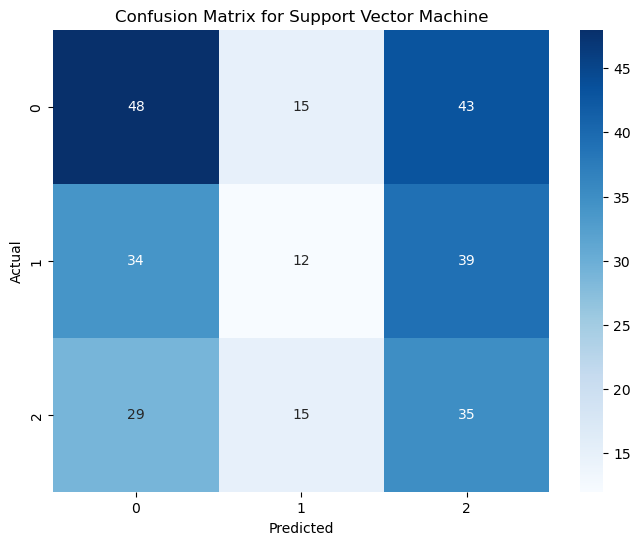

K-Nearest Neighbors Accuracy: 0.41111


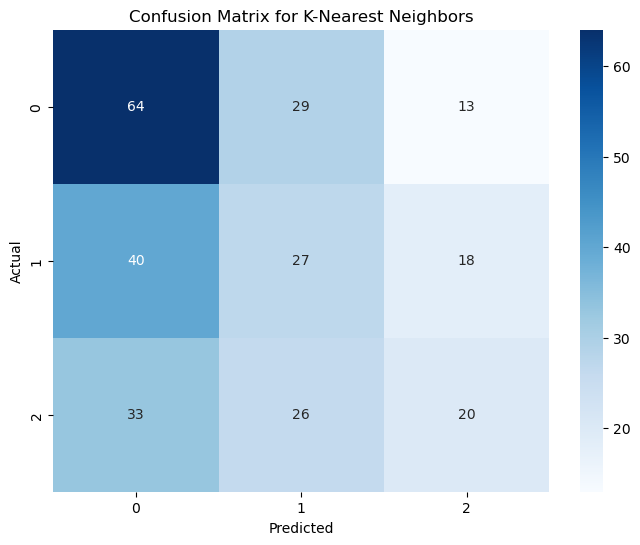

Artificial Neural Network Accuracy: 0.37037


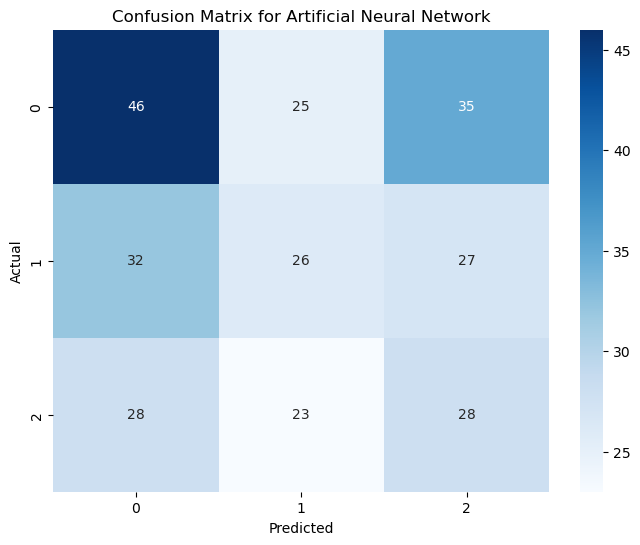

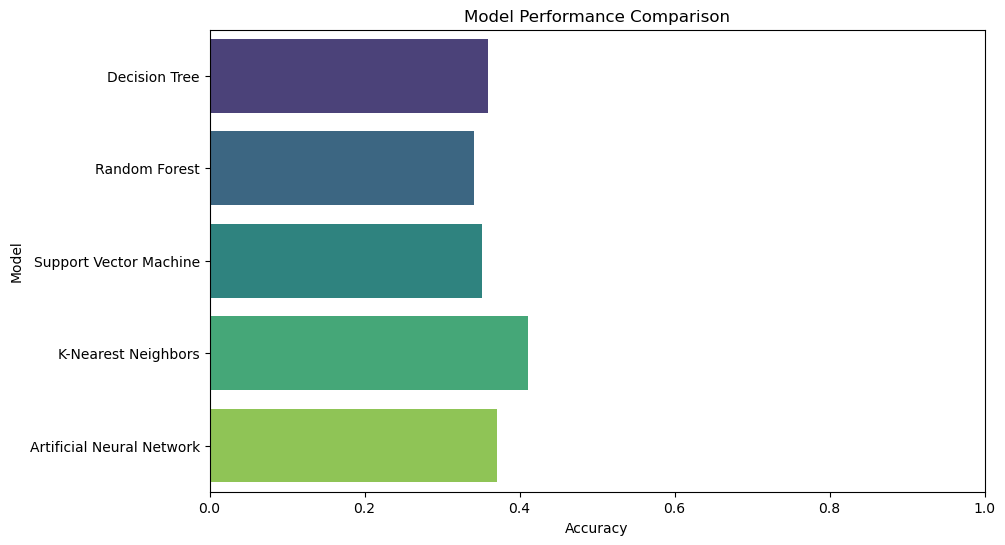

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.36                 0.42              0.38   
1              Random Forest      0.34                 0.42              0.44   
2     Support Vector Machine      0.35                 0.43              0.45   
3        K-Nearest Neighbors      0.41                 0.47              0.60   
4  Artificial Neural Network      0.37                 0.43              0.43   

   F1-Score (Class 0)  
0                0.40  
1                0.43  
2                0.44  
3                0.53  
4                0.43

In [120]:
##Classification Models after scaling-pca
classification_models(test1, df["Rider Satisfaction"],0.3)

Decision Tree Accuracy: 0.34444


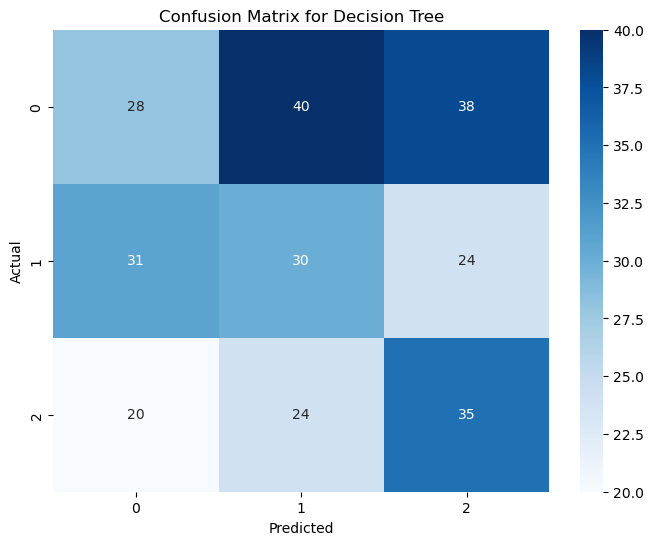

Random Forest Accuracy: 0.38889


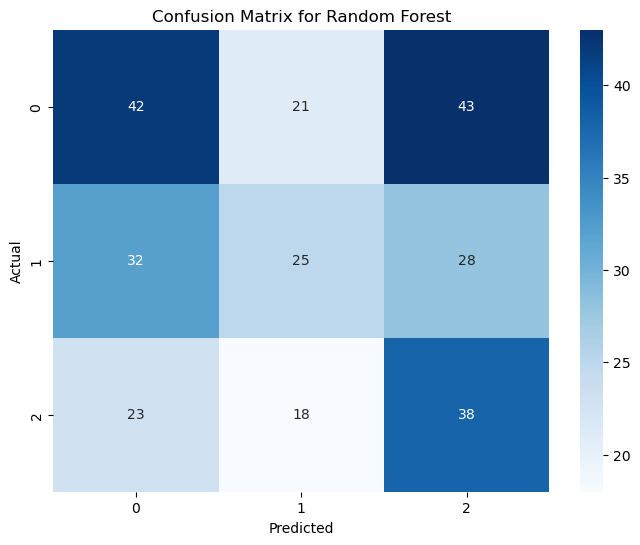

Support Vector Machine Accuracy: 0.41481


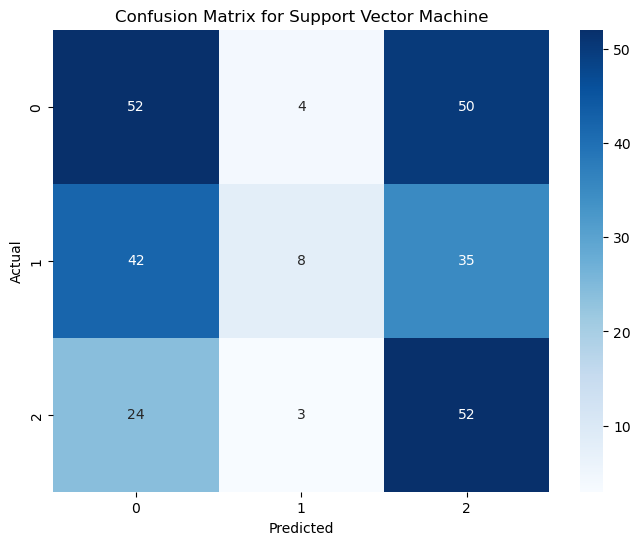

K-Nearest Neighbors Accuracy: 0.38148


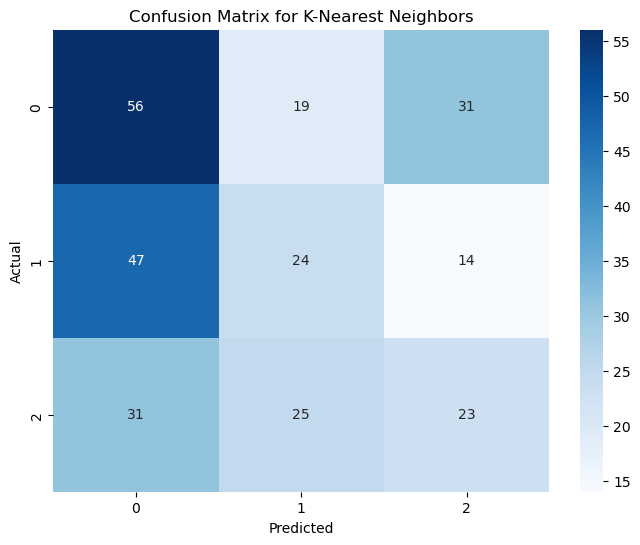

Artificial Neural Network Accuracy: 0.38519


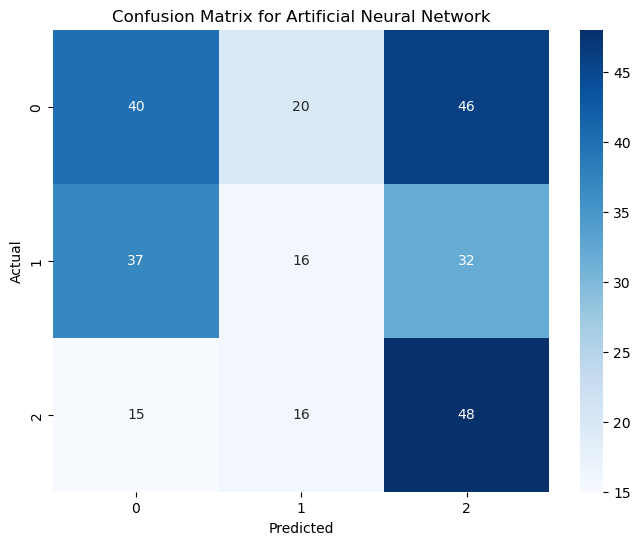

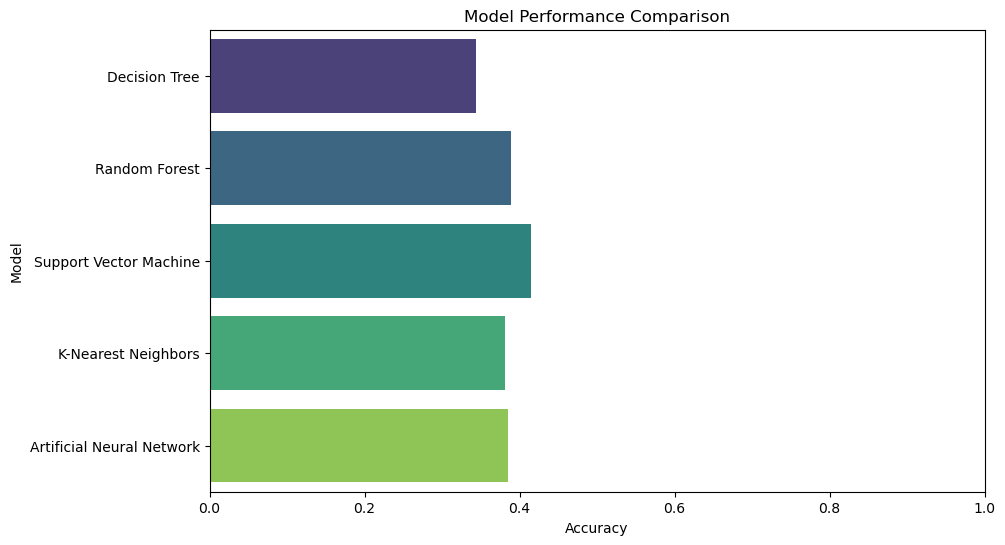

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.34                 0.35              0.26   
1              Random Forest      0.39                 0.43              0.40   
2     Support Vector Machine      0.41                 0.44              0.49   
3        K-Nearest Neighbors      0.38                 0.42              0.53   
4  Artificial Neural Network      0.39                 0.43              0.38   

   F1-Score (Class 0)  
0                0.30  
1                0.41  
2                0.46  
3                0.47  
4                0.40

In [121]:
##Classification Models after Scaling-LDA
classification_models(test2, df["Rider Satisfaction"],0.3)

## Modelling with test size of 15%

Decision Tree Accuracy: 0.36296


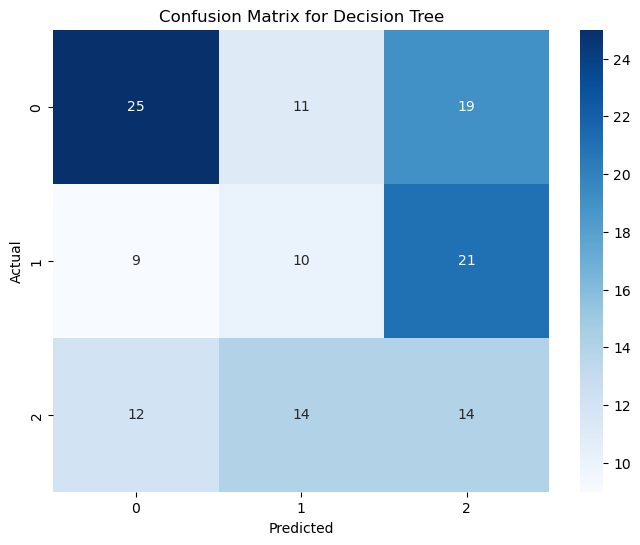

Random Forest Accuracy: 0.40000


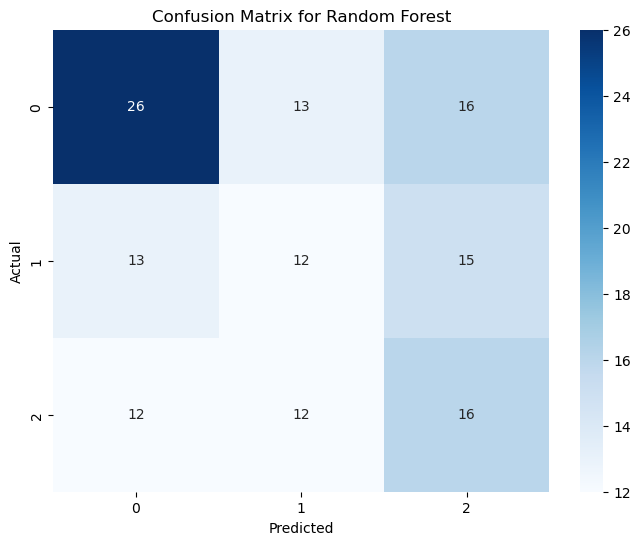

Support Vector Machine Accuracy: 0.39259


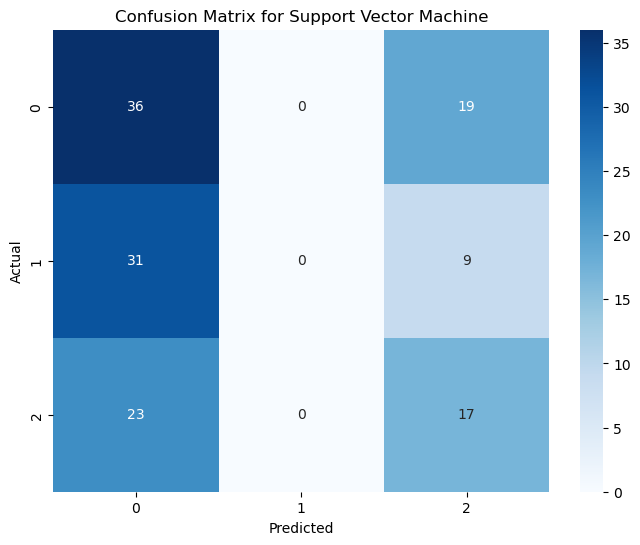

K-Nearest Neighbors Accuracy: 0.31111


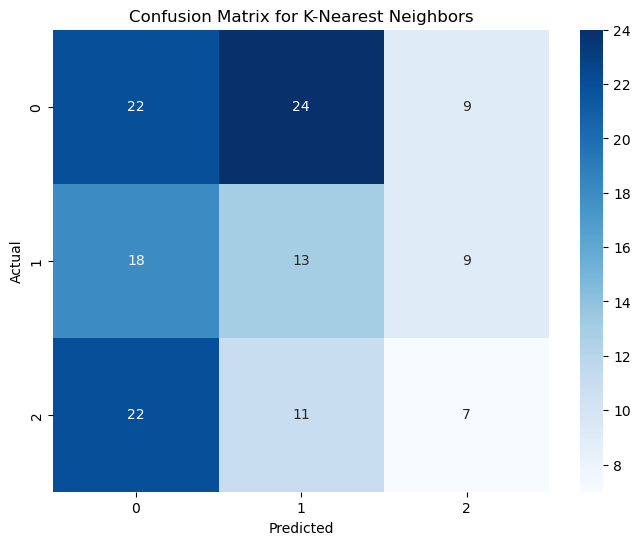

Artificial Neural Network Accuracy: 0.33333


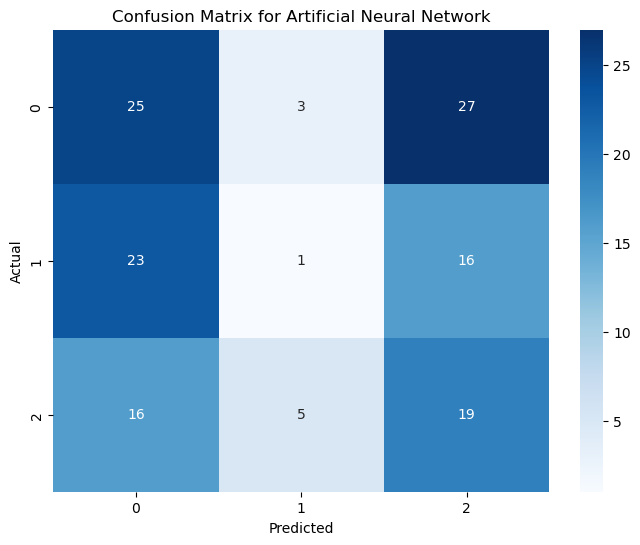

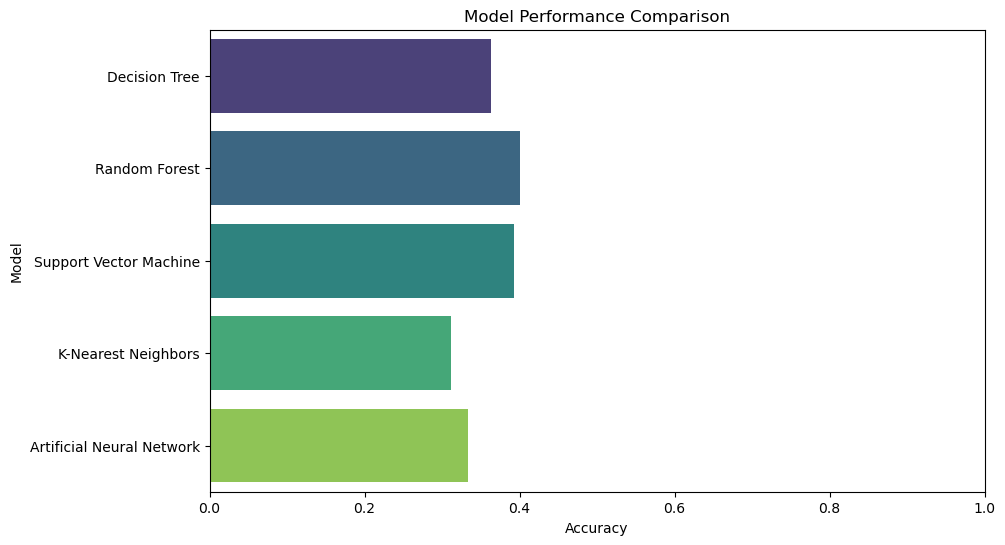

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.36                 0.54              0.45   
1              Random Forest      0.40                 0.51              0.47   
2     Support Vector Machine      0.39                 0.40              0.65   
3        K-Nearest Neighbors      0.31                 0.35              0.40   
4  Artificial Neural Network      0.33                 0.39              0.45   

   F1-Score (Class 0)  
0                0.50  
1                0.49  
2                0.50  
3                0.38  
4                0.42

In [123]:
classification_models(df.drop(columns="Rider Satisfaction"), df["Rider Satisfaction"],0.15)

Decision Tree Accuracy: 0.36296


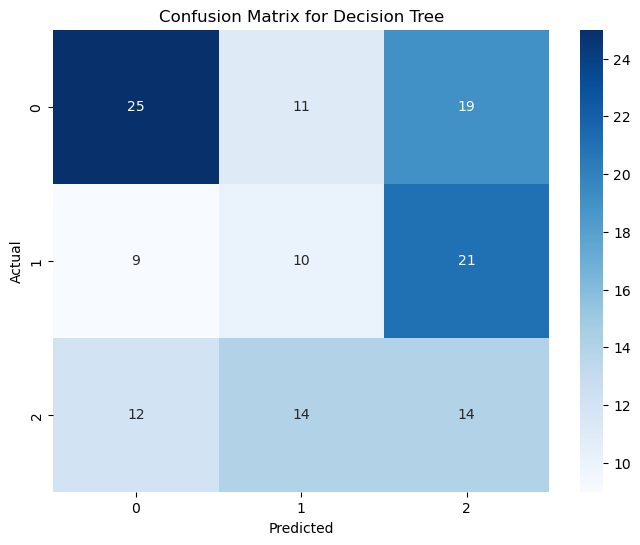

Random Forest Accuracy: 0.40000


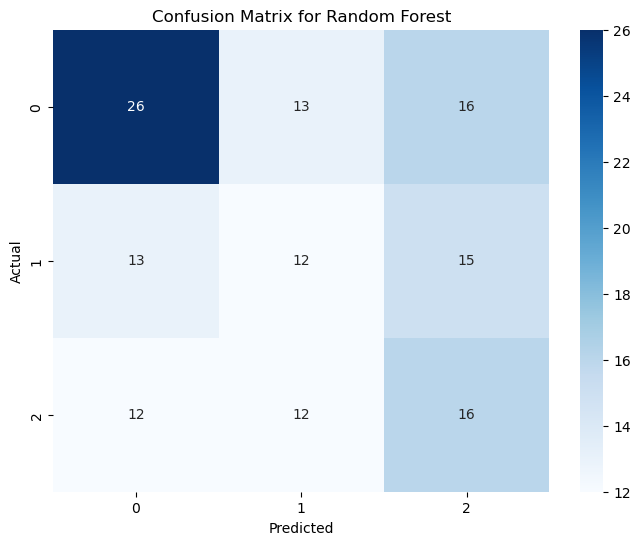

Support Vector Machine Accuracy: 0.35556


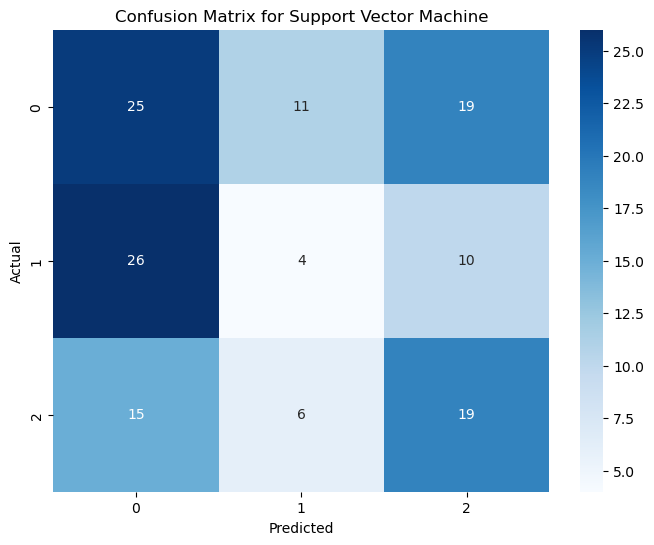

K-Nearest Neighbors Accuracy: 0.33333


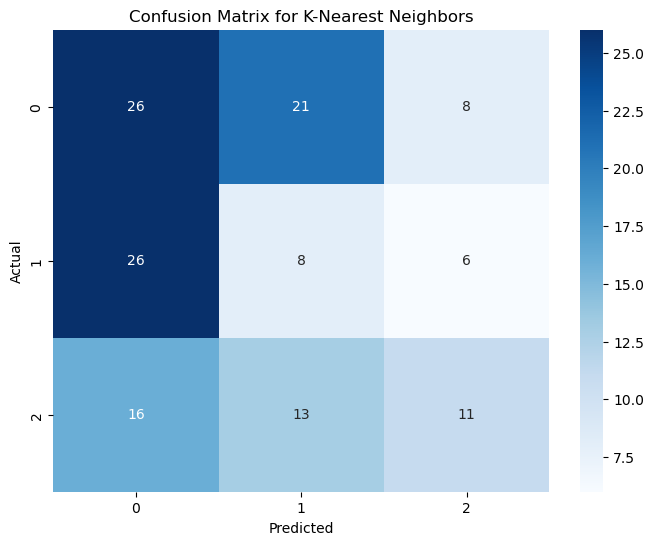

Artificial Neural Network Accuracy: 0.34074


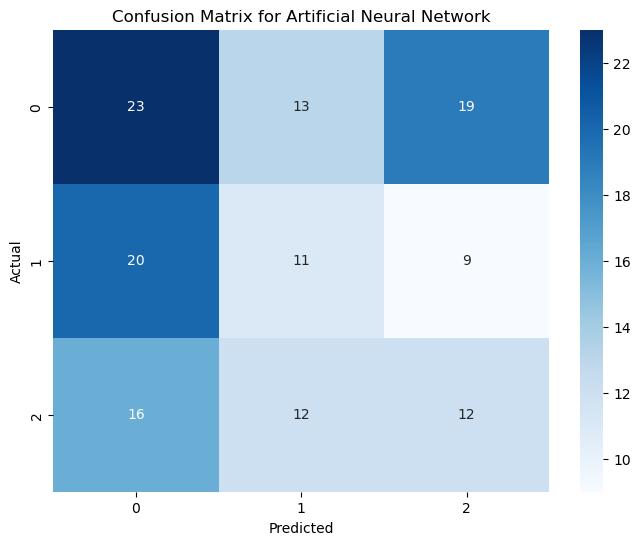

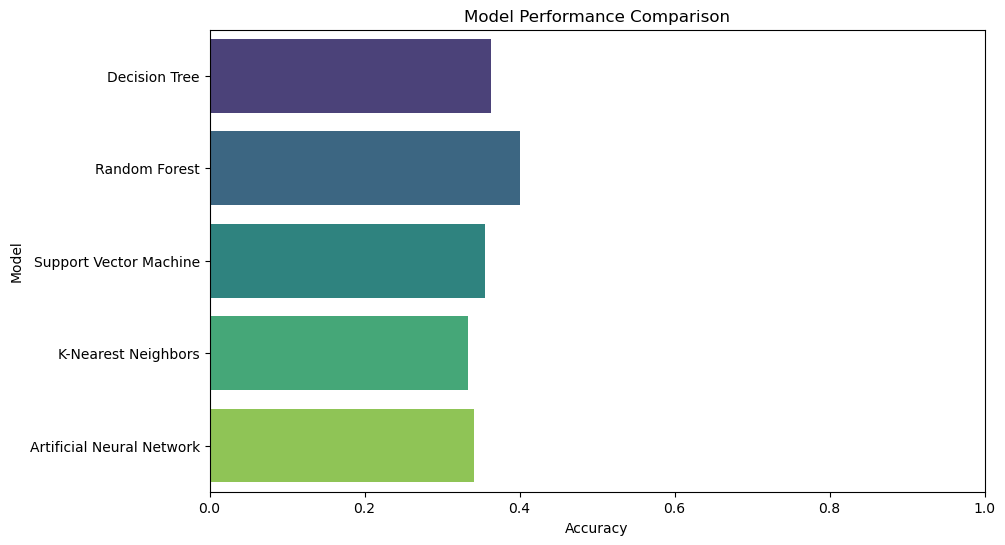

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.36                 0.54              0.45   
1              Random Forest      0.40                 0.51              0.47   
2     Support Vector Machine      0.36                 0.38              0.45   
3        K-Nearest Neighbors      0.33                 0.38              0.47   
4  Artificial Neural Network      0.34                 0.39              0.42   

   F1-Score (Class 0)  
0                0.50  
1                0.49  
2                0.41  
3                0.42  
4                0.40

In [124]:
##Classification Models after Scaling
classification_models(scaled_df_minMax, df["Rider Satisfaction"],0.15)

Decision Tree Accuracy: 0.35556


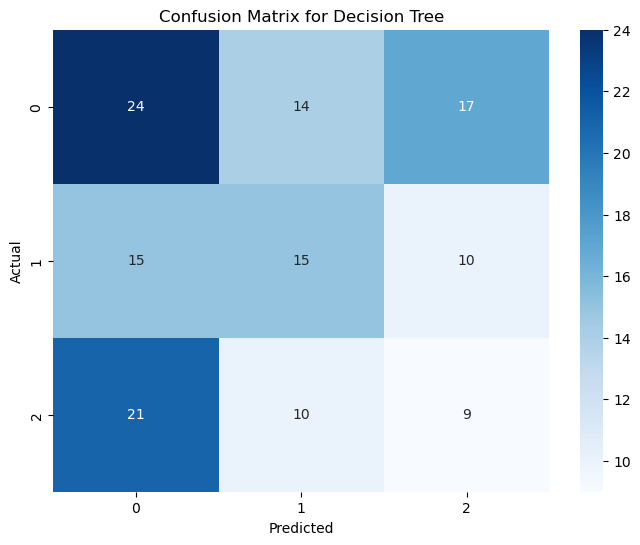

Random Forest Accuracy: 0.35556


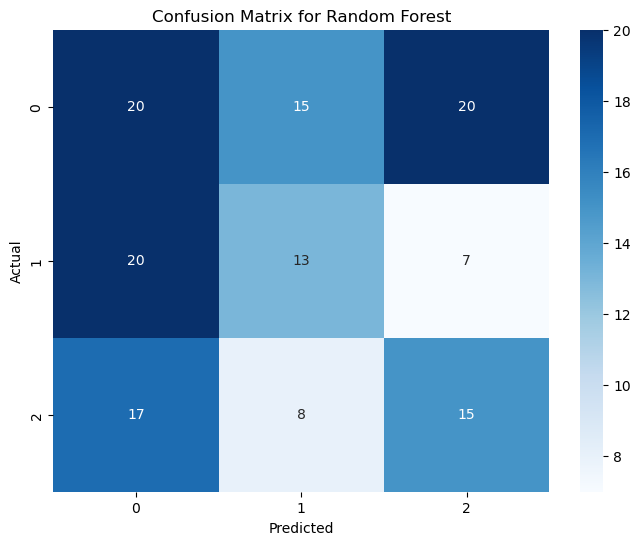

Support Vector Machine Accuracy: 0.34074


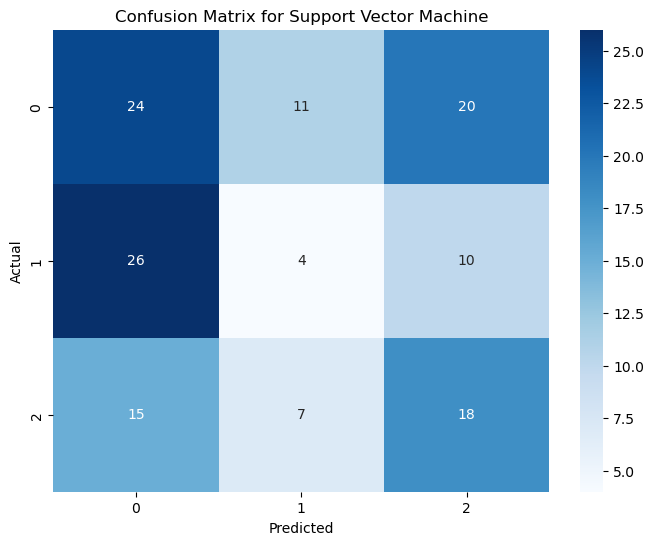

K-Nearest Neighbors Accuracy: 0.33333


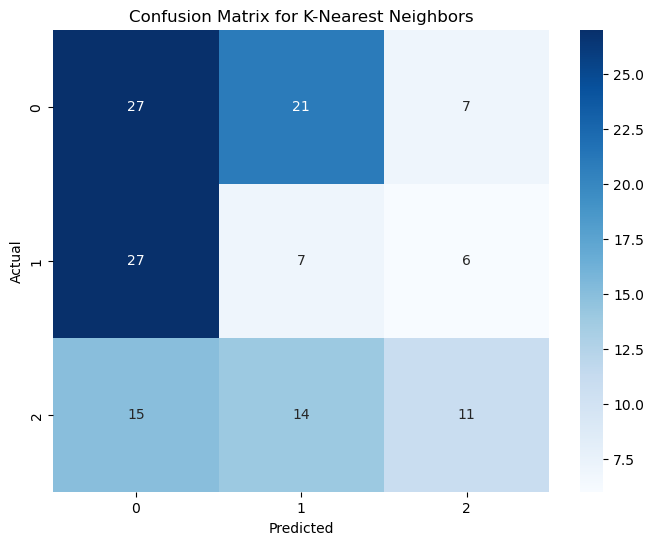

Artificial Neural Network Accuracy: 0.37778


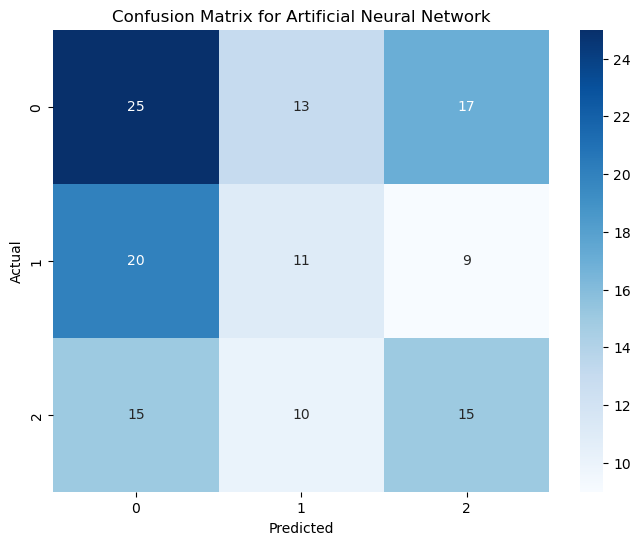

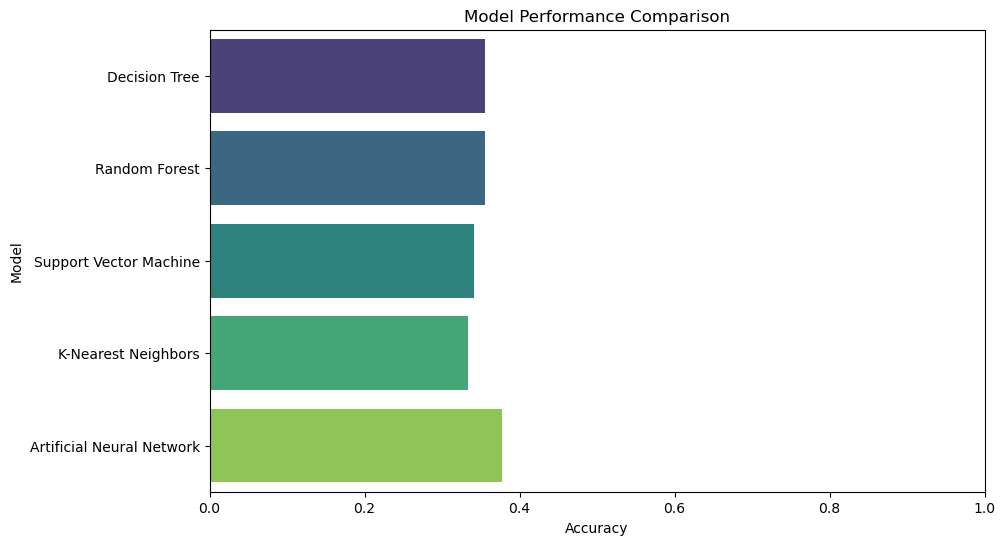

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.36                 0.40              0.44   
1              Random Forest      0.36                 0.35              0.36   
2     Support Vector Machine      0.34                 0.37              0.44   
3        K-Nearest Neighbors      0.33                 0.39              0.49   
4  Artificial Neural Network      0.38                 0.42              0.45   

   F1-Score (Class 0)  
0                0.42  
1                0.36  
2                0.40  
3                0.44  
4                0.43

In [125]:
##Classification Models after scaling-pca
classification_models(test1, df["Rider Satisfaction"],0.15)

Decision Tree Accuracy: 0.34815


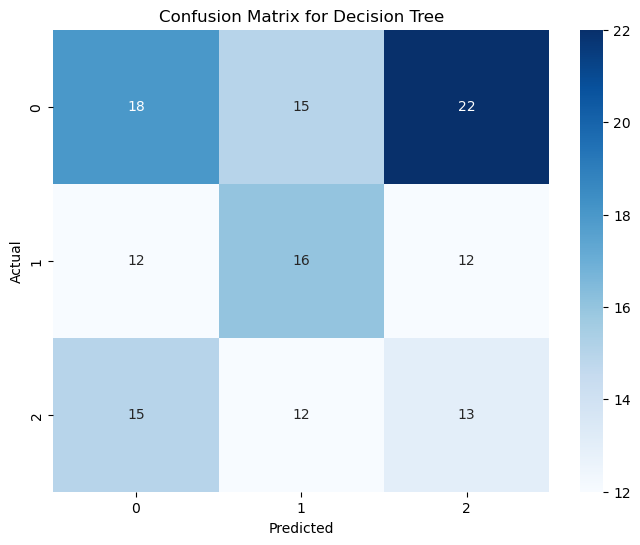

Random Forest Accuracy: 0.37037


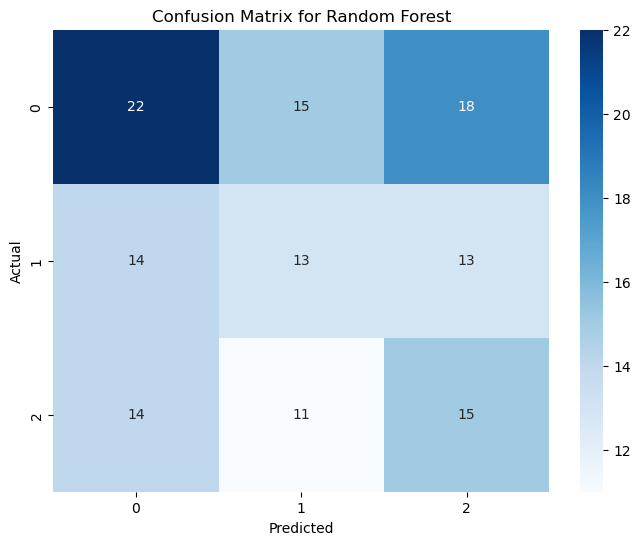

Support Vector Machine Accuracy: 0.41481


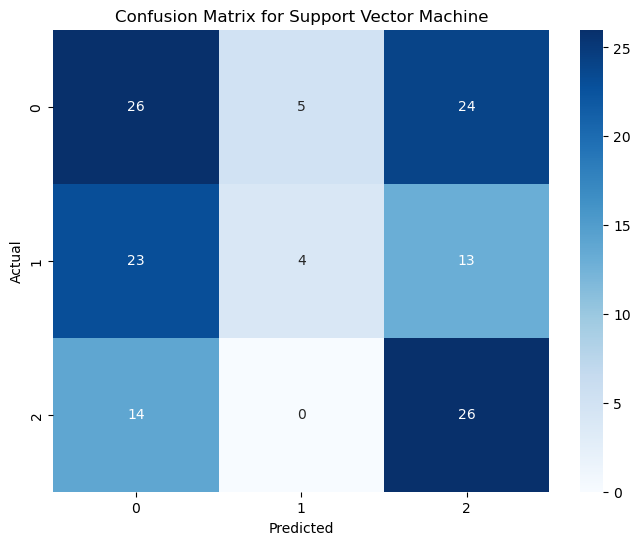

K-Nearest Neighbors Accuracy: 0.43704


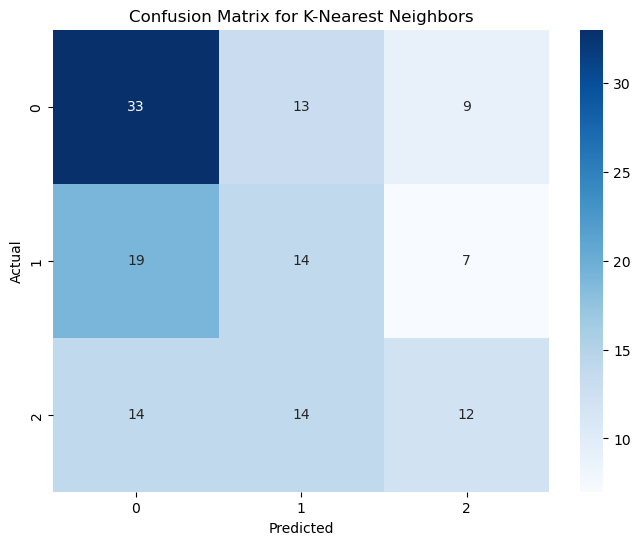

Artificial Neural Network Accuracy: 0.36296


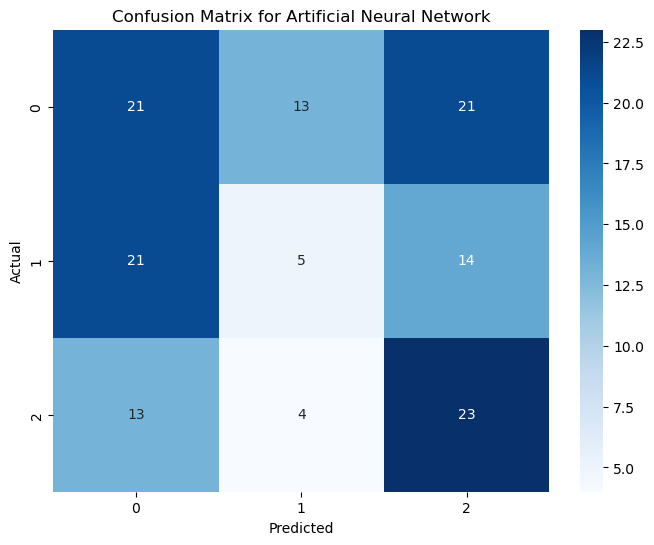

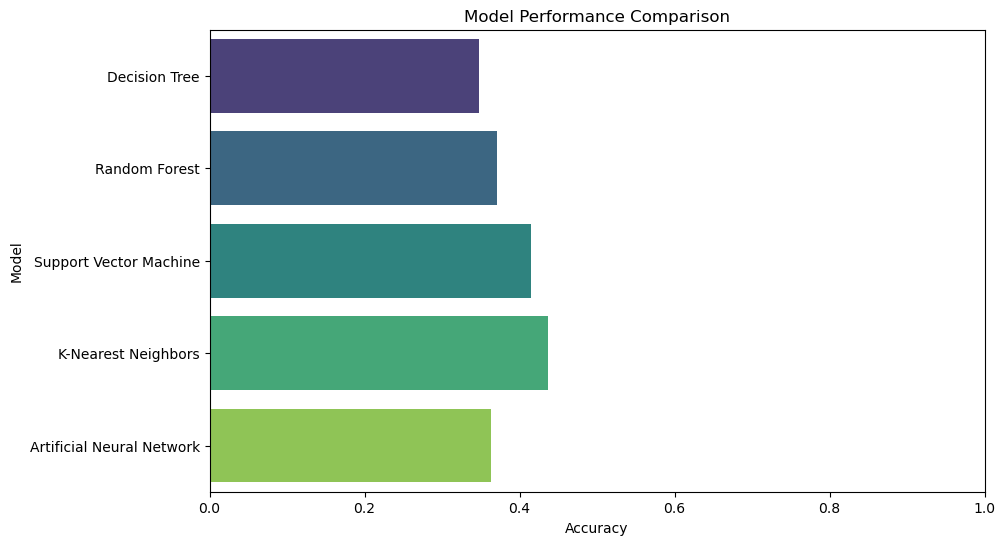

Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0              Decision Tree      0.35                 0.40              0.33   
1              Random Forest      0.37                 0.44              0.40   
2     Support Vector Machine      0.41                 0.41              0.47   
3        K-Nearest Neighbors      0.44                 0.50              0.60   
4  Artificial Neural Network      0.36                 0.38              0.38   

   F1-Score (Class 0)  
0                0.36  
1                0.42  
2                0.44  
3                0.55  
4                0.38

In [126]:
##Classification Models after Scaling-LDA
classification_models(test2, df["Rider Satisfaction"],0.15)

# Random Forest

## Tuning the Hyperparameters
### Using GridSearchCV to get the best combination of parameters

In [129]:
from sklearn.model_selection import GridSearchCV

X = df.drop(columns="Rider Satisfaction")
y = df["Rider Satisfaction"]
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees in the forest
    'max_depth': [10, 20, 30],          # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy']          # Function to measure split quality
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,                          # 5-fold cross-validation
    scoring='accuracy',            # Evaluation metric
    n_jobs=-1,                     # Use all available CPU cores
    verbose=2                      # Print progress during training
)
# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and cross-validation accuracy
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


### Classifier Model after best parameters

Accuracy on test set: 0.43703703703703706

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.56      0.55        55
           1       0.23      0.15      0.18        40
           2       0.42      0.55      0.48        40

    accuracy                           0.44       135
   macro avg       0.40      0.42      0.40       135
weighted avg       0.42      0.44      0.42       135



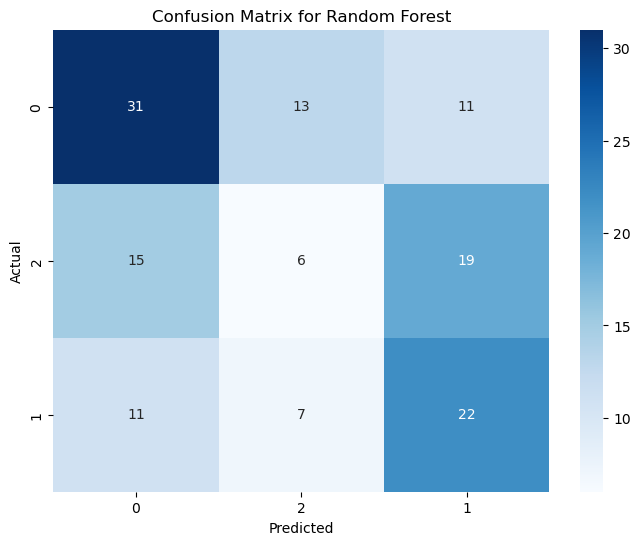


Feature Importances:
Cost: 0.1258
Cost_per_minute: 0.1236
Speed (km/h): 0.1075
Cost_per_km: 0.1060
Distance: 0.1039
Duration: 0.1006
Rider Age: 0.0916
Weather Condition_Snowy: 0.0178
Weather Condition_Sunny: 0.0177
City_New York: 0.0161
Weather Condition_Rainy: 0.0158
Age Category_Adult: 0.0158
City_London: 0.0149
Bike Model_Standard: 0.0147
City_San Francisco: 0.0146
Weather Condition_Cloudy: 0.0139
Age Category_Senior: 0.0135
Bike Model_Electric: 0.0133
City_Chicago: 0.0132
Bike Model_Mountain: 0.0120
Age Category_Young: 0.0119
City_Berlin: 0.0113
Speed_Category_Moderate: 0.0084
Speed_Category_Slow: 0.0064
Speed_Category_Fast: 0.0055
City_Dublin: 0.0042


In [131]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Define the best hyperparameters found during grid search
best_params = {
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100,
}

# Create the Random Forest model using the best hyperparameters
rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Generate and display the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display feature importances to understand the most influential variables
importances = rf_model.feature_importances_  # Extract feature importances from the model
if hasattr(X, 'columns'):
    feature_names = X.columns  # Get feature names from the dataset
else:
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]  # Use generic names if X is not a DataFrame

sorted_indices = importances.argsort()[::-1]  # Sort features by importance in descending order

print("\nFeature Importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


### Cross-Validation for Classifier Model

In [133]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
print(f"\n Each fold score \n{cv_scores}")
print(f'Mean Score: {np.mean(cv_scores)}')
print(f'Std Score: {np.std(cv_scores)}')


 Each fold score 
[0.36666667 0.33333333 0.42222222 0.34444444 0.33333333 0.35555556
 0.31111111 0.38888889 0.31111111 0.32222222]
Mean Score: 0.34888888888888886
Std Score: 0.03377485367460147


# Support Vector Machine

## Tuning the Hyperparameters
### Using GridSearchCV to get the best combination of parameters

In [136]:
X = test2
y = df["Rider Satisfaction"]              

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],   # Weighting function for neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding accuracy
print("Best parameters found:", grid_search.best_params_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


### KNN with best parameters

Accuracy: 0.4740740740740741

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58        55
           1       0.42      0.25      0.31        40
           2       0.42      0.50      0.45        40

    accuracy                           0.47       135
   macro avg       0.46      0.46      0.45       135
weighted avg       0.47      0.47      0.46       135


Each fold score:
[0.38961039 0.37662338 0.4025974  0.44155844 0.35064935 0.36842105
 0.26315789 0.35526316 0.31578947 0.38157895]
Mean Score: 0.3645249487354751
Standard Deviation of Scores: 0.046253734673454665


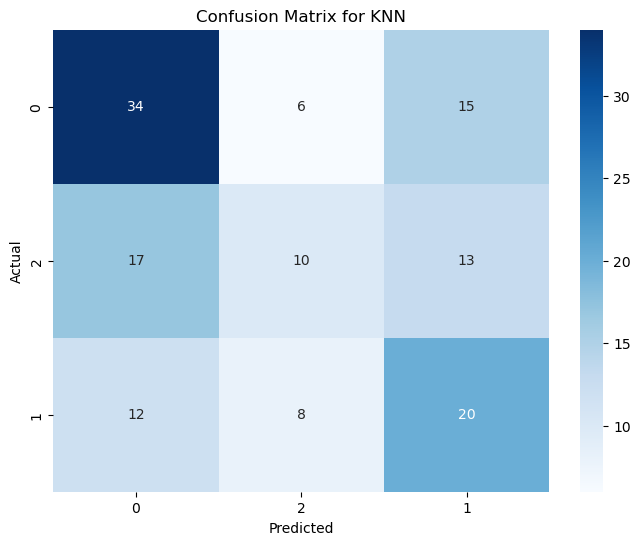


Feature Importances:
Cost: 0.1258
Cost_per_minute: 0.1236
Speed (km/h): 0.1075
Cost_per_km: 0.1060
Distance: 0.1039
Duration: 0.1006
Rider Age: 0.0916
Weather Condition_Snowy: 0.0178
Weather Condition_Sunny: 0.0177
City_New York: 0.0161
Weather Condition_Rainy: 0.0158
Age Category_Adult: 0.0158
City_London: 0.0149
Bike Model_Standard: 0.0147
City_San Francisco: 0.0146
Weather Condition_Cloudy: 0.0139
Age Category_Senior: 0.0135
Bike Model_Electric: 0.0133
City_Chicago: 0.0132
Bike Model_Mountain: 0.0120
Age Category_Young: 0.0119
City_Berlin: 0.0113
Speed_Category_Moderate: 0.0084
Speed_Category_Slow: 0.0064
Speed_Category_Fast: 0.0055
City_Dublin: 0.0042


In [138]:
best_params = {
    'n_neighbors':9, 
    'weights': 'uniform', 
    'metric': 'manhattan'
}

# Create the KNN model using the best parameters
knn = KNeighborsClassifier(**best_params)

# Train the model on the full training data
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')

# Print cross-validation results
print(f"\nEach fold score:\n{cv_scores}")
print(f"Mean Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Scores: {np.std(cv_scores)}")


# Generate and display the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display feature importances to understand the most influential variables
importances = rf_model.feature_importances_  # Extract feature importances from the model

sorted_indices = importances.argsort()[::-1]  # Sort features by importance in descending order

print("\nFeature Importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

### Regression Models for Cost Evaluation

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def modeling(X, y, value):
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=value, random_state=42)
    
    # Initialising regressors
    regressors = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'Decision Tree': DecisionTreeRegressor(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.5, gamma='scale')
    }
    
    # Training and evaluating regressors
    results = {}
    for name, reg in regressors.items():
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        train_score = reg.score(X_train, y_train)  # Training R² score
        test_score = reg.score(X_test, y_test)  # Testing R² score
        
        results[name] = {
            'Split': value,
            'MAE': mae,
            'MSE': mse,
            'R2 Score': r2,
            'Train R² Score': train_score,
            'Test R² Score': test_score
        }

        # Visualising Actual vs Predicted values
        c = [i for i in range(1, len(y_test) + 1)]  
    
        fig = plt.figure()
        plt.plot(c, y_test, color="blue", linewidth=1.5, linestyle="-", label="Actual")
        plt.plot(c, y_pred, color="red", linewidth=1.5, linestyle="-", label="Predicted")
        fig.suptitle(f'{name} Actual vs Predicted', fontsize=20)
        plt.xlabel('Index', fontsize=18) 
        plt.ylabel('Value', fontsize=16) 
        plt.legend(fontsize=12)
        plt.show()
    
    # Converting results to a DataFrame
    results_df = pd.DataFrame(results).transpose()
    results_df = results_df.reset_index().rename(columns={'index': 'Model'})
    print(results_df)
    
    #Visualising metrics comparison
    results_long = results_df.melt(id_vars=['Model', 'Split'], value_vars=['MAE', 'MSE', 'R2 Score'], 
                               var_name='Metric', value_name='Score')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_long, x='Model', y='Score', hue='Metric')
    plt.title("Comparisson of MAE, MSE y R² Score between Models")
    plt.xlabel("Model")
    plt.ylabel("Metric Value")
    plt.legend(title="Metric")
    plt.show()


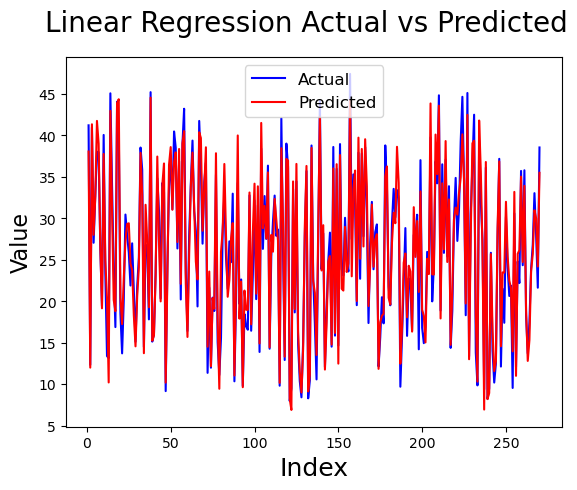

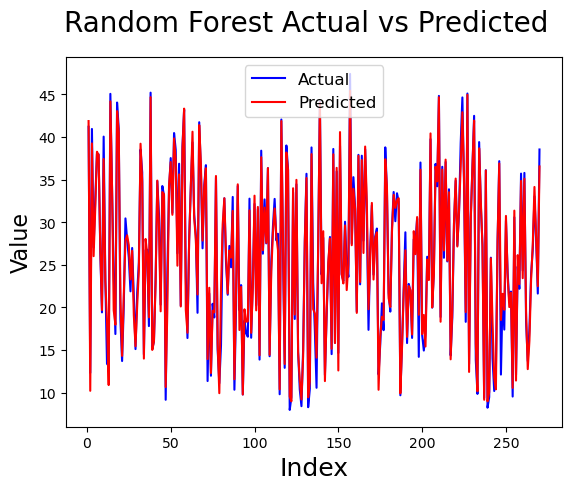

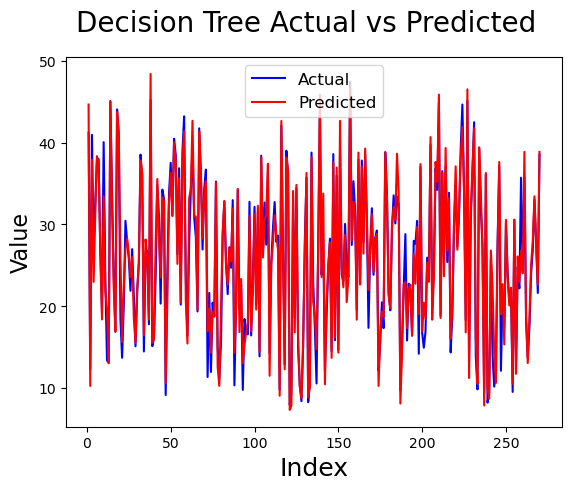

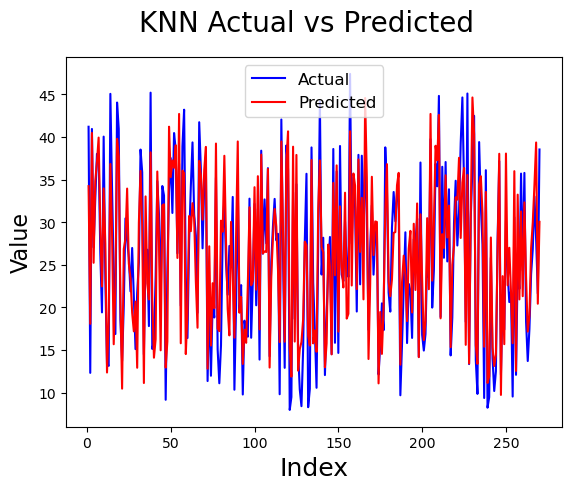

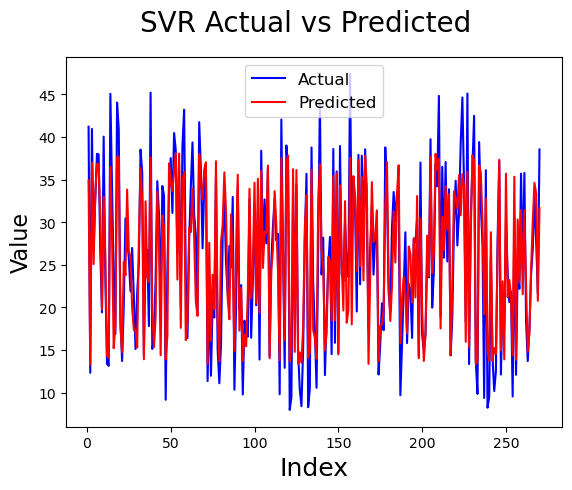

               Model  Split  MAE   MSE  R2 Score  Train R² Score  \
0  Linear Regression   0.30 1.83  5.46      0.94            0.93   
1      Random Forest   0.30 0.94  1.87      0.98            1.00   
2      Decision Tree   0.30 1.40  4.28      0.95            1.00   
3                KNN   0.30 3.73 20.46      0.78            0.85   
4                SVR   0.30 3.32 16.37      0.82            0.81   

   Test R² Score  
0           0.94  
1           0.98  
2           0.95  
3           0.78  
4           0.82  


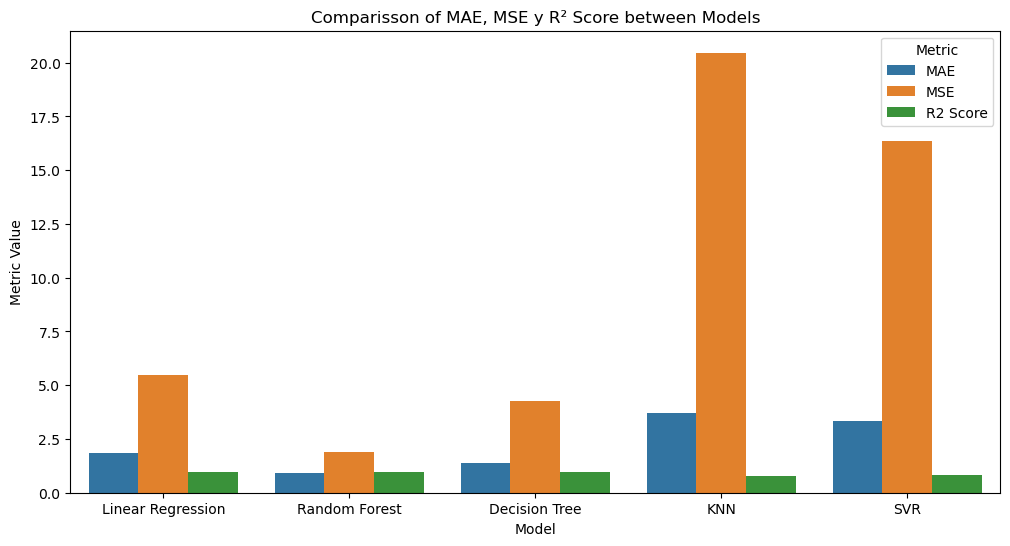

In [141]:
modeling(df.drop(columns="Cost"),df["Cost"],0.3)

In [142]:
#Appliying cross-validaton to best model before using GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Cost"), df["Cost"], test_size=0.3, random_state=42)
rf = RandomForestRegressor().fit(X_train, y_train)

cv_scores = cross_val_score(rf,df.drop(columns="Cost"),df["Cost"], cv=10, scoring='r2')
print(f'Mean Score: {np.mean(cv_scores)}')
print(f'Std Score: {np.std(cv_scores)}')

Mean Score: 0.9774422641496212
Std Score: 0.01198437579568015


## Tuning the Hyperparameters
### Using GridSearchCV to get the best combination of parameters

In [144]:
#Importing GridSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best parameter combination: {grid_search.best_params_}')

Best parameter combination: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### Classifier Model after best parameters

MSE: 1.9734296198148142
R^2: 0.9787160620398713
Train R2: 0.9961712255221912


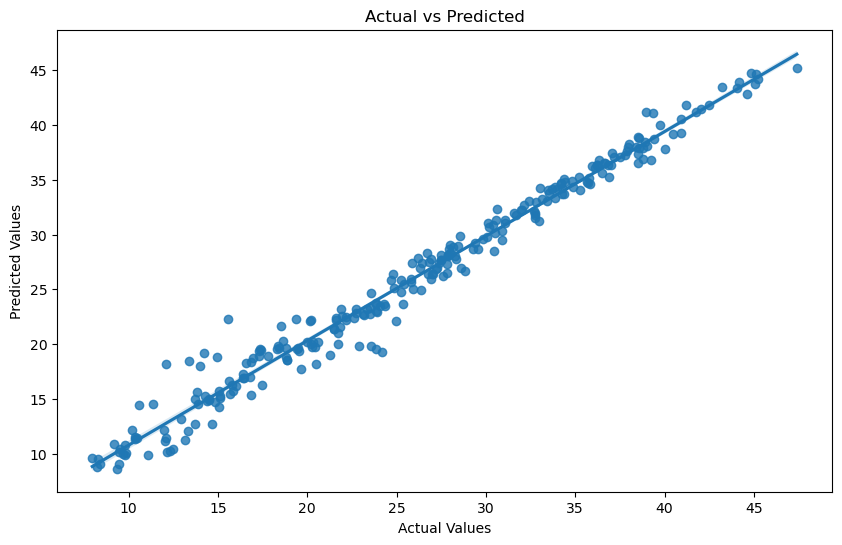

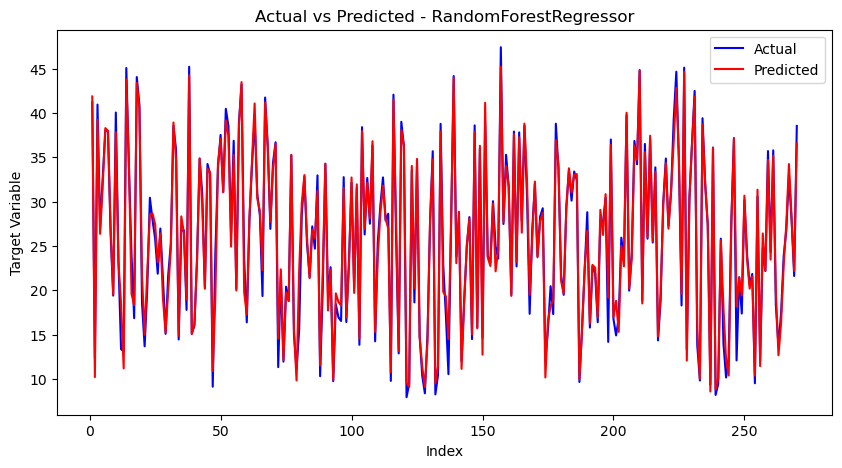

In [146]:
# Setting parameters
best_params = {'max_depth': 20, 'min_samples_leaf':1, 'min_samples_split': 2, 'n_estimators': 50}

# Creating the random forest model with best parameters
rf = RandomForestRegressor(**best_params,random_state=42)

# Training the model
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#Calculing MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_score = rf.score(X_train, y_train)  # Training R² score

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Train R2: {train_score}")
plt.figure(figsize=(10, 6))
sns.regplot(x = y_test, y = y_pred)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Graphs to compare current values against predicted
plt.figure(figsize=(10, 5))
index = [i for i in range(1, len(y_test) + 1)]
plt.plot(index, y_test, label="Actual", color="blue", linewidth=1.5)
plt.plot(index, y_pred, label="Predicted", color="red", linewidth=1.5)
plt.title("Actual vs Predicted - RandomForestRegressor")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.show()

In [245]:
# Using cross validation to random forest model with best parameters
cv_scores = cross_val_score(rf,X_train, y_train, cv=10, scoring='r2')
print(f'Mean CV Score: {np.mean(cv_scores)}')
print(f'Std CV Score: {np.std(cv_scores)}')

Mean CV Score: 0.9699497282646561
Std CV Score: 0.015322103565798882
